In [146]:
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
import math
import numpy as np
import string
import statistics as stat
import nltk
from nltk.corpus import cess_esp
from nltk.corpus import words as english_dict
import os
import json
import datetime
from dateutil.relativedelta import relativedelta
from collections import Counter
from string import digits
from scipy.stats import mannwhitneyu,kruskal
from scikit_posthocs import posthoc_dunn

# DENUNCIANTE

Hacer el estudio con el target siendo las características demográficas del denunciante

In [133]:
files = os.listdir('Atestados')
files.remove('.DS_Store')

In [134]:
df = pd.read_excel('Tabla Provincias.xls')
df.head()

Código País Nombre País Código CCAA  \
0          724      ESPAÑA          PV   
1          724      ESPAÑA          CM   
2          724      ESPAÑA          CV   
3          724      ESPAÑA          AN   
4          724      ESPAÑA          CL   

                                Nombre CCAA  Código Provincia  \
0         COMUNIDAD AUTONOMA DEL PAIS VASCO                 1   
1  COMUNIDAD AUTONOMA DE CASTILLA-LA MANCHA                 2   
2                      COMUNIDAD VALENCIANA                 3   
3           COMUNIDAD AUTONOMA DE ANDALUCIA                 4   
4     COMUNIDAD AUTONOMA DE CASTILLA Y LEON                 5   

     Nombre Provincia  Fecha Fin  Fecha Inicio  
0         ARABA/ALAVA        NaN           NaN  
1            ALBACETE        NaN           NaN  
2  ALICANTE - ALACANT        NaN           NaN  
3             ALMERIA        NaN           NaN  
4               AVILA        NaN           NaN

In [135]:
def get_region(provincia):
    
    df = pd.read_excel('Tabla Provincias.xls')
    ccaa = list(df.loc[df['Nombre Provincia'].str.contains(provincia.upper())]['Nombre CCAA'])
    if len(ccaa) == 0:
        return provincia
    
    return ccaa[0]

def get_edad(fn,file):
    # fn del denunciante
    if '/' not in fn:
        if len(fn) != 8:
            return -1
        year = fn[:4]
        month = fn[4:6]
        day = fn[6:]
    else:
        aux = fn.split('/')
        if len(aux) != 3:
            return -1
        
        day = aux[0]
        month = aux[1]
        year = aux[-1]
    
    try:
        fecha = datetime.date(int(year),int(month),int(day))
    except:
        print(file)
    diff = relativedelta(datetime.date.today(),fecha).years

    if diff < 25:
        edad = '18-24'
    elif diff < 35:
        edad = '25-34'
    elif diff < 45:
        edad = '35-44'
    elif diff < 55:
        edad = '45-54'
    else:
        edad = '+55'
    return edad
        

In [136]:
def quitar_guiones(text,file):
    aux = text.split('--')
    aux2 = []
    for w in aux:
        if len(w)>0:
            text = replace_multi_whitespaces(w)
            aux2.append(text)
    return '\n'.join(aux2)

def replace_multi_whitespaces(line):
    return ' '.join(line.split())

def quitar_tags(text):
    tags = 'LOC|NUM|TIEM|PER'
    regex = re.compile(tags,re.S)
    res = regex.sub('', text)
    return res.replace('<','')

In [137]:
def clean_text(text,file):
    text = quitar_guiones(text,file)
    return text

### Dataframe denunciante

In [140]:
paises = pd.read_excel('../paises_estandar.xls')
paises['Continente'] = [s.translate(str.maketrans('', '', digits)) for s in paises['Continente']]
paises.head()

Continente  Código   País o  territorio
0   UNIÓN EUROPEA      102             AUSTRIA
1   UNIÓN EUROPEA      103             BELGICA
2   UNIÓN EUROPEA      104            BULGARIA
3   UNIÓN EUROPEA      106              CHIPRE
4   UNIÓN EUROPEA      107           DINAMARCA

In [141]:
from geopy.geocoders import Nominatim 
from string import digits
geolocator = Nominatim(user_agent="preprocessing")

denunciante_df = pd.DataFrame()  

list_genero = []
list_region = []
list_edad = [] 

files_with_errors = []
paises_hispanohablantes = ['Argentina', 'Bolivia', 'Chile', 'Colombia', 'Costa Rica', 'Cuba', 'Ecuador', 'El Salvador', 'Guatemala', 'Guinea Ecuatorial', 'Honduras', 'México', 'Nicaragua', 'Panamá', 'Uruguay', 'Perú', 'Puerto Rico', 'República Dominicana', 'Uruguay', 'Venezuela']

i = 0
for file in files:
    with open(f'Atestados/{file}') as f:
        _dict = json.load(f)
        # denunciante
        denunciante = _dict['denunciante']
        provincia = denunciante['provincia'].title()
        genero = denunciante['sexo']
        fn = denunciante['fn']
        # obtener comunidad autonoma
        try:
            location = geolocator.geocode(provincia,language='es').raw['display_name']
            location = location.translate(str.maketrans('', '', digits))
            location_aux = [l for l in location.split(', ') if len(l)>0]

            if len(location_aux) == 1:
                if location_aux[-1] == 'España':
                    region = 'Comunidad de Madrid'
                elif location_aux[-1] in paises_hispanohablantes:
                    region = 'LATINOS'
                else:
                    region = paises.loc[paises[' País o  territorio'] == location_aux[-1].upper()]['Continente'].item()

            else:
                ccaa = location_aux[-2]
                pais = location_aux[-1]
                if pais != 'España':
                    if pais in paises_hispanohablantes:
                        region = 'LATINOS'
                    else:
                        region = paises.loc[paises[' País o  territorio'] == location_aux[-1].upper()]['Continente'].item()
                else:
                    region = ccaa

            edad = get_edad(fn,file)
            if edad == -1:
                files_with_errors.append(file)
            else:
                list_genero.append(genero)
                list_edad.append(edad)
                list_region.append(region)
        except:
            files_with_errors.append(file)

    i += 1
    print(f'{i} de {len(files)}')

denunciante_df['gender'] = list_genero
denunciante_df['age'] = list_edad
denunciante_df['region'] = list_region

1 de 3898
2 de 3898
3 de 3898
4 de 3898
5 de 3898
6 de 3898
7 de 3898
8 de 3898
9 de 3898
10 de 3898
11 de 3898
12 de 3898
13 de 3898
14 de 3898
15 de 3898
16 de 3898
17 de 3898
18 de 3898
19 de 3898
20 de 3898
21 de 3898
22 de 3898
23 de 3898
24 de 3898
25 de 3898
26 de 3898
27 de 3898
28 de 3898
29 de 3898
30 de 3898
31 de 3898
32 de 3898
33 de 3898
34 de 3898
35 de 3898
36 de 3898
37 de 3898
38 de 3898
39 de 3898
40 de 3898
41 de 3898
42 de 3898
43 de 3898
44 de 3898
45 de 3898
46 de 3898
47 de 3898
48 de 3898
49 de 3898
50 de 3898
51 de 3898
52 de 3898
53 de 3898
54 de 3898
55 de 3898
56 de 3898
57 de 3898
58 de 3898
59 de 3898
60 de 3898
61 de 3898
62 de 3898
63 de 3898
64 de 3898
65 de 3898
66 de 3898
67 de 3898
68 de 3898
69 de 3898
70 de 3898
71 de 3898
72 de 3898
73 de 3898
74 de 3898
75 de 3898
76 de 3898
77 de 3898
78 de 3898
79 de 3898
80 de 3898
81 de 3898
82 de 3898
83 de 3898
84 de 3898
85 de 3898
86 de 3898
87 de 3898
88 de 3898
89 de 3898
90 de 3898
91 de 3898
92 de 38

In [15]:
# arreglar df
ccaas = ['Andalucía','Castilla-La Mancha','Comunitat Valenciana','Extremadura','Comunidad de Madrid','Illes Balears','Región de Murcia','Castilla y León','Euskadi','Galicia','Melilla','Catalunya','Asturias / Asturies','Cantabria','Aragón','Navarra - Nafarroa']
hispanos = paises_hispanohablantes + ccaas

new_region = []
for reg in denunciante_df['region']:
    if reg not in hispanos:
        if reg == 'España':
            new_region.append('Comunidad de Madrid')
        else:
            new_region.append('No hispanohablante')
    else:
        new_region.append(reg)

denunciante_df['region'] = new_region

In [142]:
denunciante_df.head()

gender    age                region
0      H  25-34             Andalucía
1      M    +55    Castilla-La Mancha
2      M  25-34               LATINOS
3      M    +55                  ASIA
4      M    +55  Comunidad Valenciana

In [143]:
# remove files with errors
files = [file for file in files if file not in files_with_errors]

In [144]:
# load data for character based features analysis
def df_character_based():
    data = pd.DataFrame()    
    punctuation_list = list(string.punctuation)

    num_char = []
    num_capital = []
    num_punctuation = []

    for file in files:
        with open(f'Atestados/{file}') as f:
            _dict = json.load(f)

            # denuncia
            text = _dict['denuncia']
            text = quitar_tags(text)
            cleaned_text = clean_text(text,file)
            num_char.append(len(cleaned_text))
            num_capital.append(sum(1 for c in cleaned_text if c.isupper()))
            num_punctuation.append(sum(1 for c in cleaned_text if c in punctuation_list))
    
    data['characters'] = num_char
    data['capital_letters'] = num_capital
    data['punctuations'] = num_punctuation

    return pd.concat([denunciante_df,data],axis=1)

In [145]:
df_char = df_character_based()

In [20]:
df_char.head()

gender    age                region  characters  capital_letters  \
0      H  25-34             Andalucía         269                6   
1      M    +55    Castilla-La Mancha         896                9   
2      M  25-34                  Cuba         682               29   
3      M    +55    No hispanohablante        1919              121   
4      M    +55  Comunitat Valenciana        4053              235   

   punctuations  
0             7  
1            21  
2            13  
3            72  
4           102

In [21]:
mujeres = len(denunciante_df.loc[denunciante_df['gender'] == 'M'])
hombres = len(denunciante_df.loc[denunciante_df['gender'] == 'H'])

edad = {}
for e in denunciante_df['age'].unique():
    edad[e] = len(denunciante_df.loc[denunciante_df['age'] == e])

region = {}
for r in denunciante_df['region'].unique():
    region[r] = len(denunciante_df.loc[denunciante_df['region'] == r])

In [22]:
total = len(denunciante_df)
print('\n------- FREQUENCY GENDER -------\n')
print(f'Mujeres: {(mujeres/total)*100} %')
print(f'Hombres: {(hombres/total)*100} %')

#freq age
print('\n-------- FREQUENCY AGE ---------\n')
for key in edad.keys():
    freq = (edad[key]/total)*100
    print(f'{key}: {freq} %')

#freq region
print('\n------- FREQUENCY REGION -------\n')
for key in region.keys():
    freq = (region[key]/total)*100
    print(f'{key}: {freq} %')


------- FREQUENCY GENDER -------

Mujeres: 43.59173126614987 %
Hombres: 56.40826873385013 %

-------- FREQUENCY AGE ---------

25-34: 16.48578811369509 %
+55: 28.217054263565895 %
35-44: 20.41343669250646 %
45-54: 19.431524547803615 %
18-24: 15.45219638242894 %

------- FREQUENCY REGION -------

Andalucía: 11.912144702842378 %
Castilla-La Mancha: 10.0 %
Cuba: 0.516795865633075 %
No hispanohablante: 21.3953488372093 %
Comunitat Valenciana: 26.589147286821706 %
Extremadura: 8.708010335917313 %
Comunidad de Madrid: 2.9715762273901807 %
Venezuela: 0.9043927648578811 %
Colombia: 3.7209302325581395 %
Honduras: 0.12919896640826875 %
Uruguay: 0.1808785529715762 %
Argentina: 1.0077519379844961 %
Illes Balears: 0.20671834625322996 %
Región de Murcia: 2.4806201550387597 %
Castilla y León: 1.8087855297157622 %
Euskadi: 0.6201550387596899 %
Galicia: 0.3359173126614987 %
Melilla: 0.2583979328165375 %
Bolivia: 0.3617571059431524 %
Perú: 0.3359173126614987 %
Catalunya: 1.7054263565891472 %
Ecuador: 1

In [147]:
denunciante_df['region'].unique()

array(['Andalucía', 'Castilla-La Mancha', 'LATINOS', 'ASIA',
       'Comunidad Valenciana', 'Extremadura', ' UNIÓN EUROPEA',
       ' RESTO DE EUROPA', 'Comunidad de Madrid', 'AFRICA',
       'CENTRO AMERICA Y CARIBE', 'Islas Baleares', 'Región de Murcia',
       'Castilla y León', 'País Vasco', 'Galicia', 'Melilla',
       'SUDAMERICA', 'Cataluña', 'Asturias', 'Plazas de Soberanía',
       'Cantabria', 'Aragón', 'Navarra', 'OCEANÍA'], dtype=object)

In [152]:
def remove_outliers(data,column,value=None):
    outliers_index = np.where(data[column] > value)
    data.drop(outliers_index[0], inplace=True)
    data.reset_index(drop=True,inplace=True)

    return data

def box_plot(column,data):
    fig,ax = plt.subplots(1,2,figsize=(15,7))

    sns.boxplot(x='gender',y=column,data=data,ax=ax[0])
    sns.boxplot(x='age',y=column,data=data,ax=ax[1],order=['18-24','25-34','35-44','45-54','+55'])

    fig,ax = plt.subplots(1,1,figsize=(15,7))
    sns.boxplot(x='region',y=column,data=data)
    plt.xticks(rotation=75)

def mann_whitney(df,column):
    # Mann-Whitney U test
    fem_df = df.loc[df['gender'] == 'M'][column].tolist()
    male_df = df.loc[df['gender'] == 'H'][column].tolist()

    res = mannwhitneyu(fem_df,male_df)
    return res

def kruskal_posthoc(df,column):
    # Kruskal-Wallis test
    df_aux = df.copy()
    df_aux = df_aux.groupby('age')[column]
    data = [df_aux.get_group(x).tolist() for x in df_aux.groups]

    data1 = df_aux.get_group('18-24').tolist()
    data2 = df_aux.get_group('25-34').tolist()
    data3 = df_aux.get_group('35-44').tolist()
    data4 = df_aux.get_group('45-54').tolist()
    data5 = df_aux.get_group('+55').tolist()

    res = kruskal(data1,data2,data3,data4,data5)
    print(f'AGE: {res}')

    posthoc = posthoc_dunn(data,p_adjust='holm')
    posthoc.set_axis(['18-24','25-34','35-44','45-54','+55'],axis=0,inplace=True)
    posthoc.set_axis(['18-24','25-34','35-44','45-54','+55'],axis=1,inplace=True)
    print(f'AGE: {posthoc}')

    # REGION
    df_aux = df.copy()
    df_aux = df_aux.groupby('region')[column]
    data = [df_aux.get_group(x).tolist() for x in df_aux.groups]

    data1 = df_aux.get_group('Comunidad de Madrid').tolist()
    data2 = df_aux.get_group('Andalucía').tolist()
    data3 = df_aux.get_group('Extremadura').tolist()
    data5 = df_aux.get_group('Castilla y León').tolist()
    data6 = df_aux.get_group('Comunidad Valenciana').tolist()
    data7 = df_aux.get_group('Galicia').tolist()
    data8 = df_aux.get_group('Cataluña').tolist()
    data9 = df_aux.get_group('Plazas de Soberanía').tolist()
    data10 = df_aux.get_group('País Vasco').tolist()
    data11 = df_aux.get_group('Castilla-La Mancha').tolist()
    data12 = df_aux.get_group('Asturias').tolist()
    data13 = df_aux.get_group('Aragón').tolist()
    data14 = df_aux.get_group('Cantabria').tolist()
    data15 = df_aux.get_group('Región de Murcia').tolist()
    data16 = df_aux.get_group('Navarra').tolist()
    data17 = df_aux.get_group('Islas Baleares').tolist()
    data18 = df_aux.get_group('Melilla').tolist()
    data19 = df_aux.get_group('LATINOS').tolist()
    data20 = df_aux.get_group('ASIA').tolist()
    data21 = df_aux.get_group(' UNIÓN EUROPEA').tolist()
    data22 = df_aux.get_group(' RESTO DE EUROPA').tolist()
    data23 = df_aux.get_group('CENTRO AMERICA Y CARIBE').tolist()
    data24 = df_aux.get_group('SUDAMERICA').tolist()
    data25 = df_aux.get_group('OCEANÍA').tolist()

    res = kruskal(data1,data2,data3,data5,data6,data7,data8,data9,data10,data11,data12,data13,data14,data15,data16,data17,data18,data19,data20,data21,data22,data23,data24,data25)
    print(f'REGION: {res}')

    posthoc = posthoc_dunn(data,p_adjust='holm')
    posthoc.set_axis(['Comunidad de Madrid','Andalucía','Extremadura','Castilla y León','Comunidad Valenciana','Galicia','Cataluña','Plazas de Soberanía','País Vasco','Castilla-La Mancha','Asturias','Aragón','Cantabria','Región de Murcia','Navarra','Islas Baleares','Melilla','LATINOS','ASIA',' UNIÓN EUROPEA',' RESTO DE EUROPA','AFRICA','CENTRO AMERICA Y CARIBE','SUDAMERICA','OCEANÍA'],axis=0,inplace=True)
    posthoc.set_axis(['Comunidad de Madrid','Andalucía','Extremadura','Castilla y León','Comunidad Valenciana','Galicia','Cataluña','Plazas de Soberanía','País Vasco','Castilla-La Mancha','Asturias','Aragón','Cantabria','Región de Murcia','Navarra','Islas Baleares','Melilla','LATINOS','ASIA',' UNIÓN EUROPEA',' RESTO DE EUROPA','AFRICA','CENTRO AMERICA Y CARIBE','SUDAMERICA','OCEANÍA'],axis=1,inplace=True)
    
    print(f'REGION: {posthoc}')

def d_cohen(mean1, mean2, std):
    return (mean1 - mean2)/std

def f_cohen(mean_list,count_list,total_mean,length):

    suma = 0
    for mean, count in zip(mean_list,count_list):
        suma += count * math.pow((mean - total_mean),2)

    return math.sqrt(suma/length)

def statistics(column,data):
    # d of Cohen
    mean_col = data[column].mean()
    std_col = data[column].std()
    # gender
    mean_gender = data.groupby(['gender'])[column].mean()

    d_gender = d_cohen(mean_gender['M'],mean_gender['H'],std_col)
    print(f'The d of Cohen for gender is: {d_gender}')

    # f of Cohen
    # age
    mean_age = data.groupby(['age'])[column].mean()
    count_age = data.groupby(['age'])[column].count()
    f_cohen_age = f_cohen(mean_age,count_age,mean_col,len(data))
    f_cohen_age_normalized = f_cohen_age/(max(mean_age) - min(mean_age))
    print(f'The f of Cohen for age is: {f_cohen_age}')
    print(f'The f of Cohen normalized for age is: {f_cohen_age_normalized}')

    # demography
    mean_dem = data.groupby(['region'])[column].mean()
    count_dem = data.groupby(['region'])[column].count()
    f_cohen_dem = f_cohen(mean_dem,count_dem,mean_col,len(data))
    f_cohen_dem_normalized = f_cohen_dem/(max(mean_dem) - min(mean_dem))
    print(f'The f of Cohen for demography is: {f_cohen_dem}')
    print(f'The f of Cohen normalized for demography is: {f_cohen_dem_normalized}')
    

## CHARACTER BASED

### 1. Number of characters 

In [149]:
# Mann-Whitney U test
data = df_char.copy()
res = mann_whitney(data,'characters')
print(res)

MannwhitneyuResult(statistic=1554928.5, pvalue=3.204734682686297e-05)


In [153]:
# Kruskal-Wallis test
kruskal_posthoc(df_char,'characters')


AGE: KruskalResult(statistic=39.08185548346463, pvalue=6.700434488089306e-08)
AGE:               18-24         25-34     35-44     45-54       +55
18-24  1.000000e+00  1.417683e-07  0.010174  0.067262  0.822227
25-34  1.417683e-07  1.000000e+00  0.097513  0.010509  0.000012
35-44  1.017378e-02  9.751292e-02  1.000000  0.822227  0.067262
45-54  6.726242e-02  1.050853e-02  0.822227  1.000000  0.203596
+55    8.222273e-01  1.211960e-05  0.067262  0.203596  1.000000
REGION: KruskalResult(statistic=240.75435914296102, pvalue=3.3908563272108734e-38)
REGION:                          Comunidad de Madrid     Andalucía  Extremadura  \
Comunidad de Madrid                 1.000000  1.000000e+00     1.000000   
Andalucía                           1.000000  1.000000e+00     0.023557   
Extremadura                         1.000000  2.355683e-02     1.000000   
Castilla y León                     1.000000  2.024861e-01     1.000000   
Comunidad Valenciana                1.000000  1.559708e-10     1.00

/var/folders/_x/cddkf2k97y19q18kzrrrxrzw0000gn/T/ipykernel_36317/2864299129.py:42: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  posthoc.set_axis(['18-24','25-34','35-44','45-54','+55'],axis=0,inplace=True)
/var/folders/_x/cddkf2k97y19q18kzrrrxrzw0000gn/T/ipykernel_36317/2864299129.py:43: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  posthoc.set_axis(['18-24','25-34','35-44','45-54','+55'],axis=1,inplace=True)
/var/folders/_x/cddkf2k97y19q18kzrrrxrzw0000gn/T/ipykernel_36317/2864299129.py:80: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  posthoc.set_axis(['Comunidad de Madrid','Andalucía','Extremadura','Castilla y León','Comunidad Valenciana','Galicia','

The d of Cohen for gender is: -0.12469064381238679
The f of Cohen for age is: 56.47565927970771
The f of Cohen normalized for age is: 0.3467140214751175
The f of Cohen for demography is: 120.12297068516929
The f of Cohen normalized for demography is: 0.1530066498484271


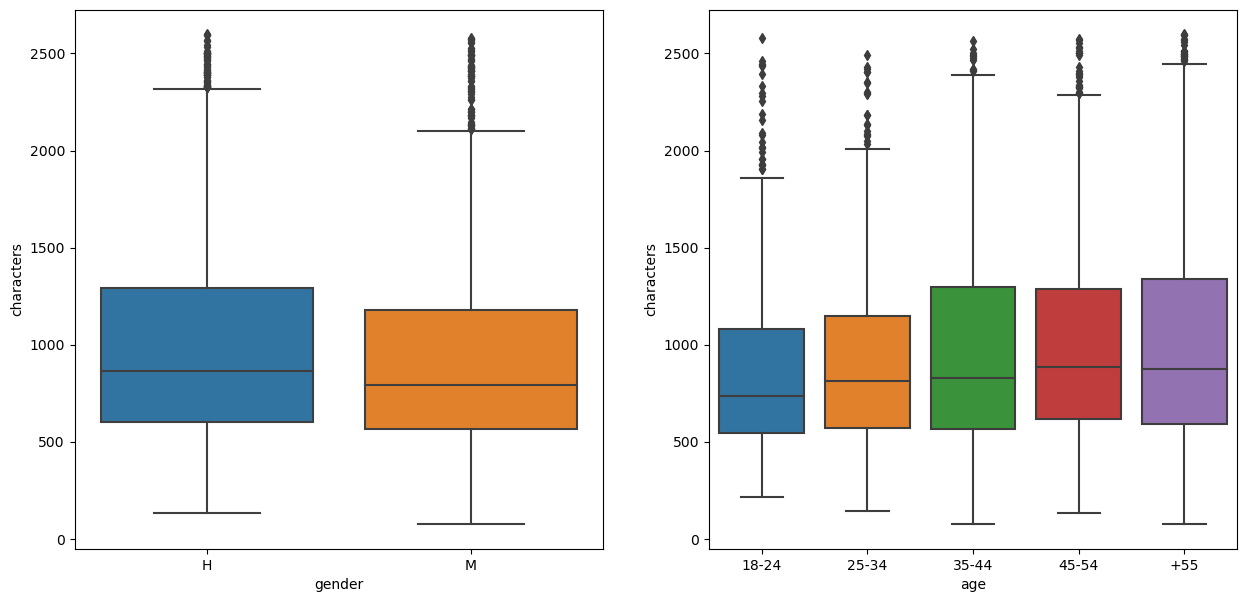

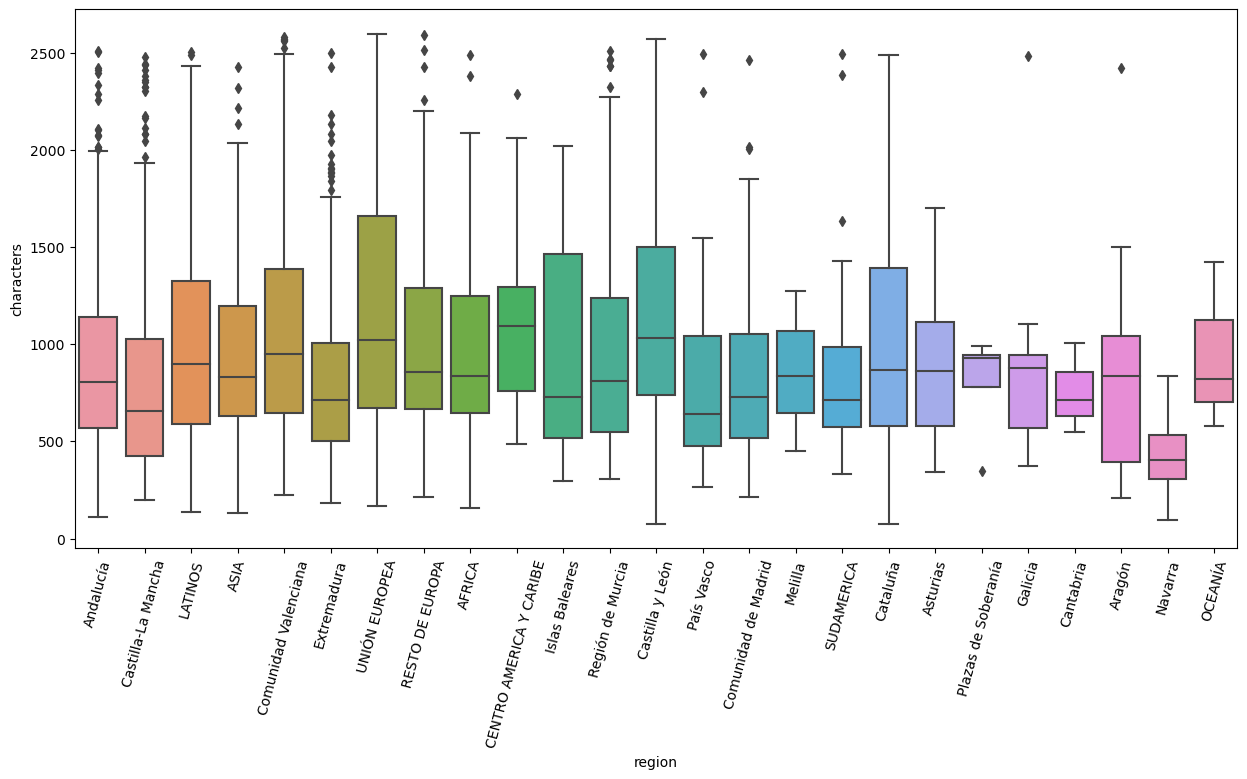

In [156]:
# remove outliers
data = df_char.copy()
data = remove_outliers(data,column='characters',value=2600)
# boxplot
box_plot('characters',data)
# statistics
statistics('characters',data)

### 2. Number of capital letters 

In [157]:
# Mann-Whitney U test
data = df_char.copy()
res = mann_whitney(data,'capital_letters')
print(res)

MannwhitneyuResult(statistic=1512759.0, pvalue=4.617589765057155e-08)


In [158]:
# Kruskal-Wallis test
kruskal_posthoc(df_char,'capital_letters')


AGE: KruskalResult(statistic=33.090050372562665, pvalue=1.1448296129036627e-06)
AGE:           18-24     25-34     35-44     45-54       +55
18-24  1.000000  0.000001  0.466442  1.000000  1.000000
25-34  0.000001  1.000000  0.010212  0.000021  0.000062
35-44  0.466442  0.010212  1.000000  0.805665  0.958807
45-54  1.000000  0.000021  0.805665  1.000000  1.000000
+55    1.000000  0.000062  0.958807  1.000000  1.000000
REGION: KruskalResult(statistic=207.1212203339588, pvalue=1.4260358817020012e-31)
REGION:                          Comunidad de Madrid     Andalucía  Extremadura  \
Comunidad de Madrid                 1.000000  1.000000e+00     1.000000   
Andalucía                           1.000000  1.000000e+00     0.095543   
Extremadura                         1.000000  9.554261e-02     1.000000   
Castilla y León                     1.000000  7.658813e-02     1.000000   
Comunidad Valenciana                1.000000  4.154414e-07     1.000000   
Galicia                             1.0

/var/folders/_x/cddkf2k97y19q18kzrrrxrzw0000gn/T/ipykernel_36317/2864299129.py:42: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  posthoc.set_axis(['18-24','25-34','35-44','45-54','+55'],axis=0,inplace=True)
/var/folders/_x/cddkf2k97y19q18kzrrrxrzw0000gn/T/ipykernel_36317/2864299129.py:43: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  posthoc.set_axis(['18-24','25-34','35-44','45-54','+55'],axis=1,inplace=True)
/var/folders/_x/cddkf2k97y19q18kzrrrxrzw0000gn/T/ipykernel_36317/2864299129.py:80: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  posthoc.set_axis(['Comunidad de Madrid','Andalucía','Extremadura','Castilla y León','Comunidad Valenciana','Galicia','

The d of Cohen for gender is: -0.10960612881713613
The f of Cohen for age is: 4.6854525016132795
The f of Cohen normalized for age is: 0.3386437479925308
The f of Cohen for demography is: 10.07820113758639
The f of Cohen normalized for demography is: 0.11231279128068042


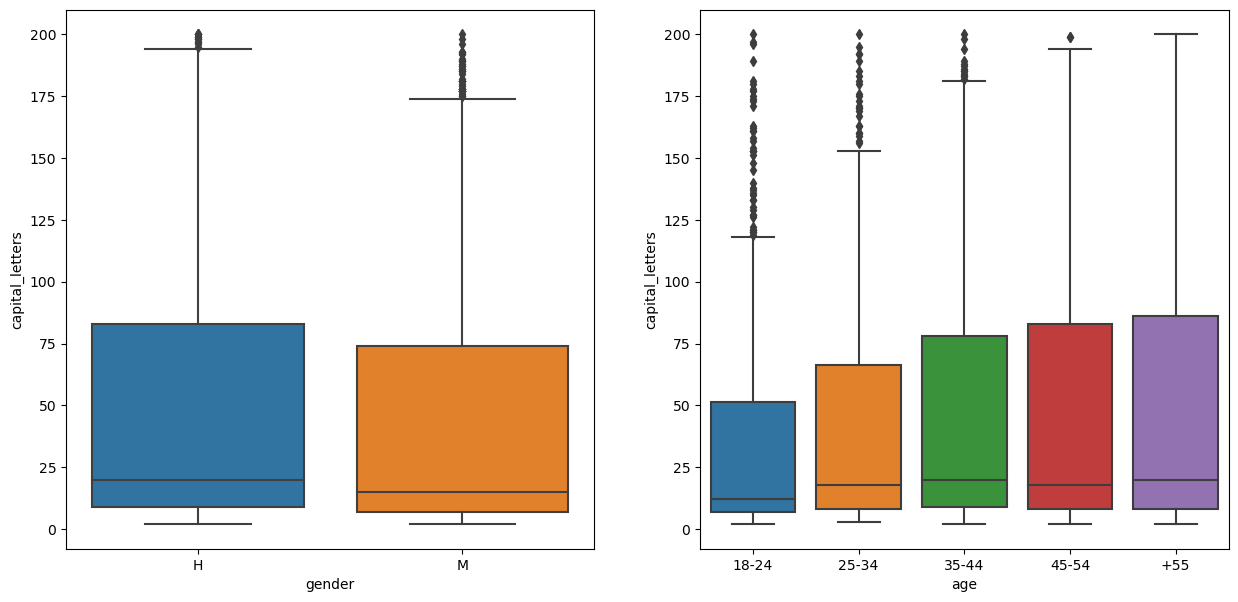

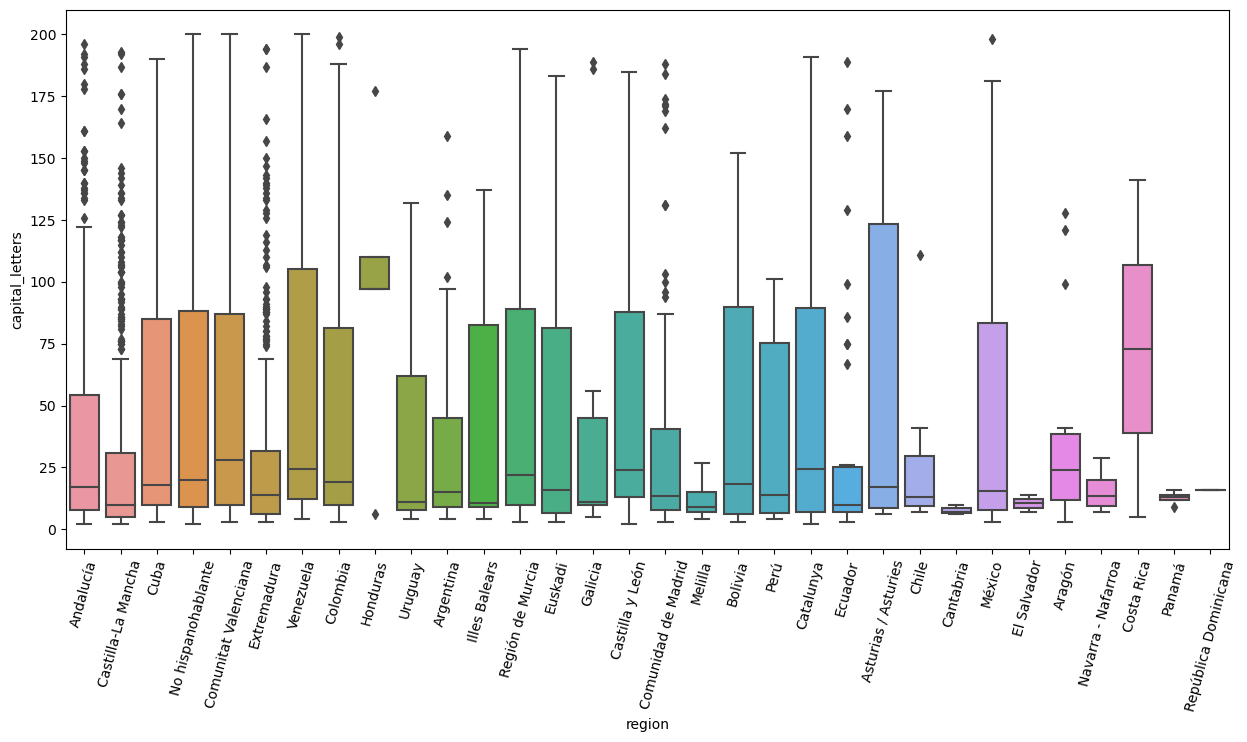

In [34]:
# remove outliers
data = df_char.copy()
data = remove_outliers(data,column='capital_letters',value=200)
# boxplot
box_plot('capital_letters',data)
# statistics
statistics('capital_letters',data)

### 3. Number of puntuation marks 

In [159]:
# Mann-Whitney U test
data = df_char.copy()
res = mann_whitney(data,'punctuations')
print(res)

MannwhitneyuResult(statistic=1554013.0, pvalue=2.8013726617101497e-05)


In [160]:
# Kruskal-Wallis test
kruskal_posthoc(df_char,'punctuations')


AGE: KruskalResult(statistic=24.977966588572777, pvalue=5.082562028127721e-05)
AGE:           18-24     25-34     35-44     45-54       +55
18-24  1.000000  0.000088  0.019876  0.093438  0.871656
25-34  0.000088  1.000000  0.550954  0.203177  0.004768
35-44  0.019876  0.550954  1.000000  0.871656  0.203177
45-54  0.093438  0.203177  0.871656  1.000000  0.488247
+55    0.871656  0.004768  0.203177  0.488247  1.000000
REGION: KruskalResult(statistic=192.86409724890459, pvalue=8.479235946090703e-29)
REGION:                          Comunidad de Madrid     Andalucía  Extremadura  \
Comunidad de Madrid                 1.000000  6.028764e-01     1.000000   
Andalucía                           0.602876  1.000000e+00     0.043479   
Extremadura                         1.000000  4.347879e-02     1.000000   
Castilla y León                     1.000000  4.890737e-02     1.000000   
Comunidad Valenciana                1.000000  5.234729e-12     1.000000   
Galicia                             1.00

/var/folders/_x/cddkf2k97y19q18kzrrrxrzw0000gn/T/ipykernel_36317/2864299129.py:42: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  posthoc.set_axis(['18-24','25-34','35-44','45-54','+55'],axis=0,inplace=True)
/var/folders/_x/cddkf2k97y19q18kzrrrxrzw0000gn/T/ipykernel_36317/2864299129.py:43: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  posthoc.set_axis(['18-24','25-34','35-44','45-54','+55'],axis=1,inplace=True)
/var/folders/_x/cddkf2k97y19q18kzrrrxrzw0000gn/T/ipykernel_36317/2864299129.py:80: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  posthoc.set_axis(['Comunidad de Madrid','Andalucía','Extremadura','Castilla y León','Comunidad Valenciana','Galicia','

The d of Cohen for gender is: -0.1035860734496109
The f of Cohen for age is: 1.6847726675326744
The f of Cohen normalized for age is: 0.33477389134124463
The f of Cohen for demography is: 3.8364134302152095
The f of Cohen normalized for demography is: 0.07842753179315591


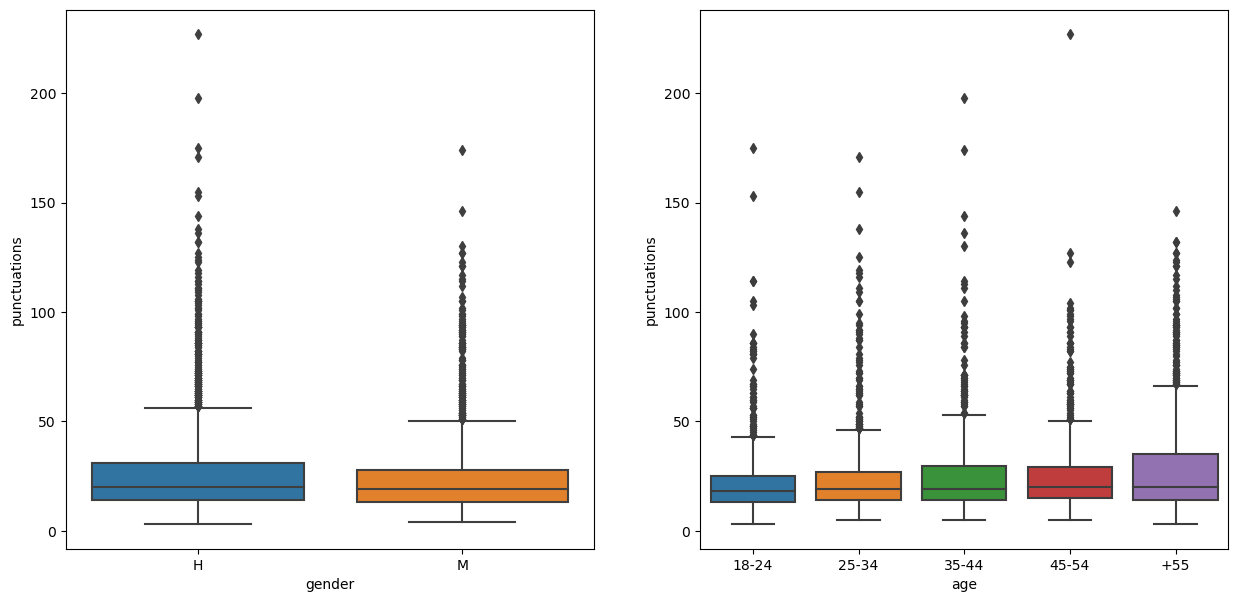

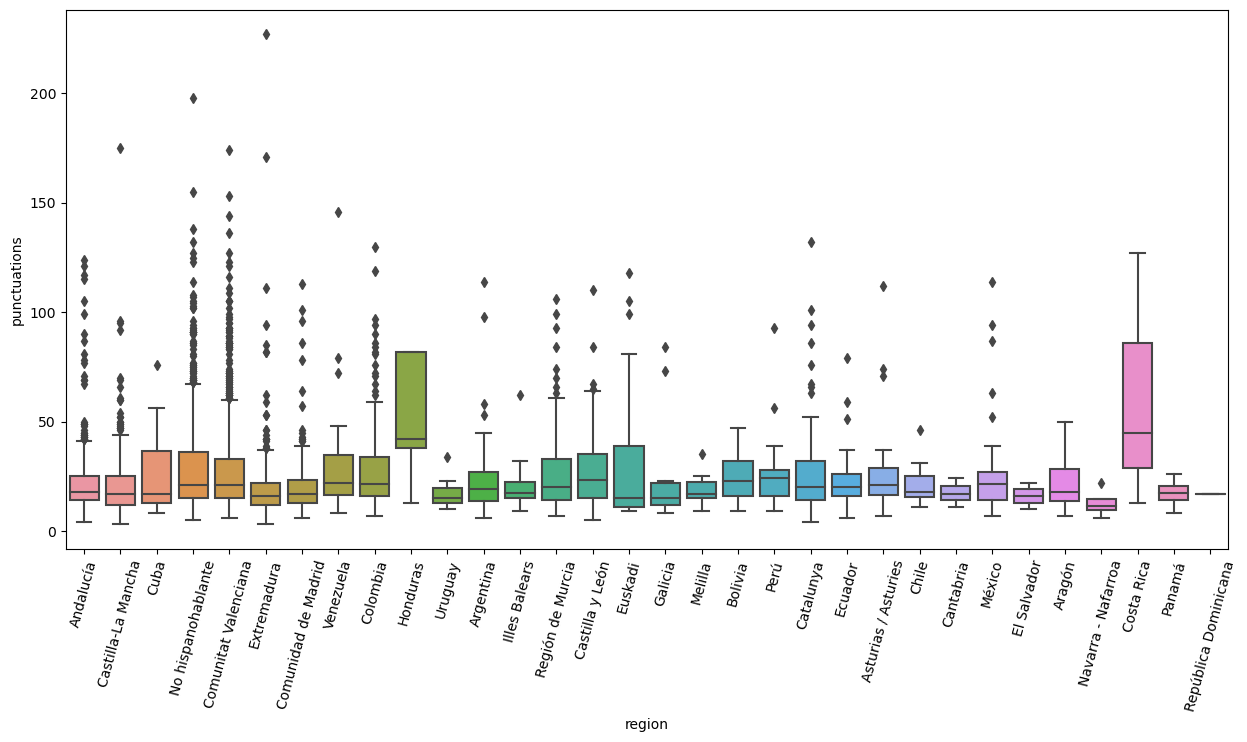

In [35]:
# remove outliers
data = df_char.copy()
#data = remove_outliers(data,column='punctuations',value=50)
# boxplot
box_plot('punctuations',data)
# statistics
statistics('punctuations',data)

## STRUCTURAL FEATURES ANALYSIS: 

1. Sentence count
2. Average count of sentence per paragraph
3. Average count of words per paragraph
4. Average count of characters per paragraph
5. Variation in paragraphs length 

#### Steps:

- Create boxplots to visualize independence between studied features and the users personal traits (gender, age and demography)
- Statistical measures: d of Cohen for traits with only 2 options, f of Cohen for traits with more than 2 possibilities.
The d of Cohen can be either positive or negative. Two variables are considered independant when the absolute value of d is 0 or very close to 0, and as the absolute value of d gets bigger, the relationship between the variables becomes stronger. Normaly, when the value is below 0.2 the dependency between the variables is considered small, when it is around 0.5 it's considered moderate, and the dependency is big when the value is greater than 0.8. These measures apply as well for the f of Cohen normilized. This measure is calculated dividing the f of Cohen between the difference of the max and min values of the groups of each of the studied features.

In [161]:
# load data for character based features analysis
def df_structural_based():    
    data = pd.DataFrame()   
    num_sentence = []
    av_sentence_par = []
    av_words_par = []
    av_char_par = []
    variation = []

    for file in files:
        with open(f'Atestados/{file}') as f:
            _dict = json.load(f)

            # denuncia
            text = _dict['denuncia']
            text = quitar_tags(text)
            cleaned_text = clean_text(text,file)

            num_par = len(cleaned_text.split('\n'))

            cleaned_text = cleaned_text.replace('\n','')
            sentences = cleaned_text.split('.')
            num_sentence_user = len(sentences)
            num_sentence.append(num_sentence_user)
            av_sentence_par.append(num_sentence_user/num_par)
            
            words = [w for w in cleaned_text.split(' ') if len(w) > 0]
            num_words = len(words)
            av_words_par.append(num_words/num_par)
            av_char_par.append(len(cleaned_text)/num_par)

            len_sentence_list = [len(sentence) for sentence in sentences]
            if len(len_sentence_list) > 1:
                var = stat.variance(len_sentence_list)
            else:
                var = 0
            variation.append(var)     


    data['num_sentence'] = num_sentence
    data['av_sentence_par'] = av_sentence_par
    data['av_words_par'] = av_words_par
    data['av_char_par'] = av_char_par
    data['variation'] = variation


    return pd.concat([denunciante_df,data],axis=1)

In [162]:
df_struct = df_structural_based()
df_struct.head()

gender    age                region  num_sentence  av_sentence_par  \
0      H  25-34             Andalucía             3         1.000000   
1      M    +55    Castilla-La Mancha             6         1.000000   
2      M  25-34               LATINOS             6         1.000000   
3      M    +55                  ASIA            24         3.428571   
4      M    +55  Comunidad Valenciana            31         1.631579   

   av_words_par  av_char_par     variation  
0     14.000000    89.000000   7922.333333  
1     26.000000   148.500000   6501.466667  
2     19.333333   112.833333   6874.400000  
3     45.428571   273.285714   5368.717391  
4     36.157895   212.368421  12857.094624

### 1. Number of sentences

In [163]:
# Mann-Whitney U test
data = df_struct.copy()
res = mann_whitney(data,'num_sentence')
print(res)

MannwhitneyuResult(statistic=1530649.0, pvalue=8.117226497294344e-07)


In [164]:
# Kruskal-Wallis test
kruskal_posthoc(df_struct,'num_sentence')


AGE: KruskalResult(statistic=29.491303402679836, pvalue=6.211628508891342e-06)
AGE:           18-24     25-34     35-44     45-54       +55
18-24  1.000000  0.000005  0.056947  0.094192  1.000000
25-34  0.000005  1.000000  0.164268  0.056947  0.000367
35-44  0.056947  0.164268  1.000000  1.000000  0.221472
45-54  0.094192  0.056947  1.000000  1.000000  0.327069
+55    1.000000  0.000367  0.221472  0.327069  1.000000
REGION: KruskalResult(statistic=303.3968365374165, pvalue=9.41705554056829e-51)
REGION:                          Comunidad de Madrid     Andalucía  Extremadura  \
Comunidad de Madrid             1.000000e+00  1.000000e+00     1.000000   
Andalucía                       1.000000e+00  1.000000e+00     0.023537   
Extremadura                     1.000000e+00  2.353656e-02     1.000000   
Castilla y León                 1.000000e+00  7.980974e-01     1.000000   
Comunidad Valenciana            5.391624e-01  4.152415e-11     1.000000   
Galicia                         1.000000e+

/var/folders/_x/cddkf2k97y19q18kzrrrxrzw0000gn/T/ipykernel_36317/2864299129.py:42: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  posthoc.set_axis(['18-24','25-34','35-44','45-54','+55'],axis=0,inplace=True)
/var/folders/_x/cddkf2k97y19q18kzrrrxrzw0000gn/T/ipykernel_36317/2864299129.py:43: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  posthoc.set_axis(['18-24','25-34','35-44','45-54','+55'],axis=1,inplace=True)
/var/folders/_x/cddkf2k97y19q18kzrrrxrzw0000gn/T/ipykernel_36317/2864299129.py:80: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  posthoc.set_axis(['Comunidad de Madrid','Andalucía','Extremadura','Castilla y León','Comunidad Valenciana','Galicia','

The d of Cohen for gender is: -0.1465663815971584
The f of Cohen for age is: 0.24176480864569014
The f of Cohen normalized for age is: 0.35580452012914454
The f of Cohen for demography is: 0.8269884918315848
The f of Cohen normalized for demography is: 0.09904053794390238


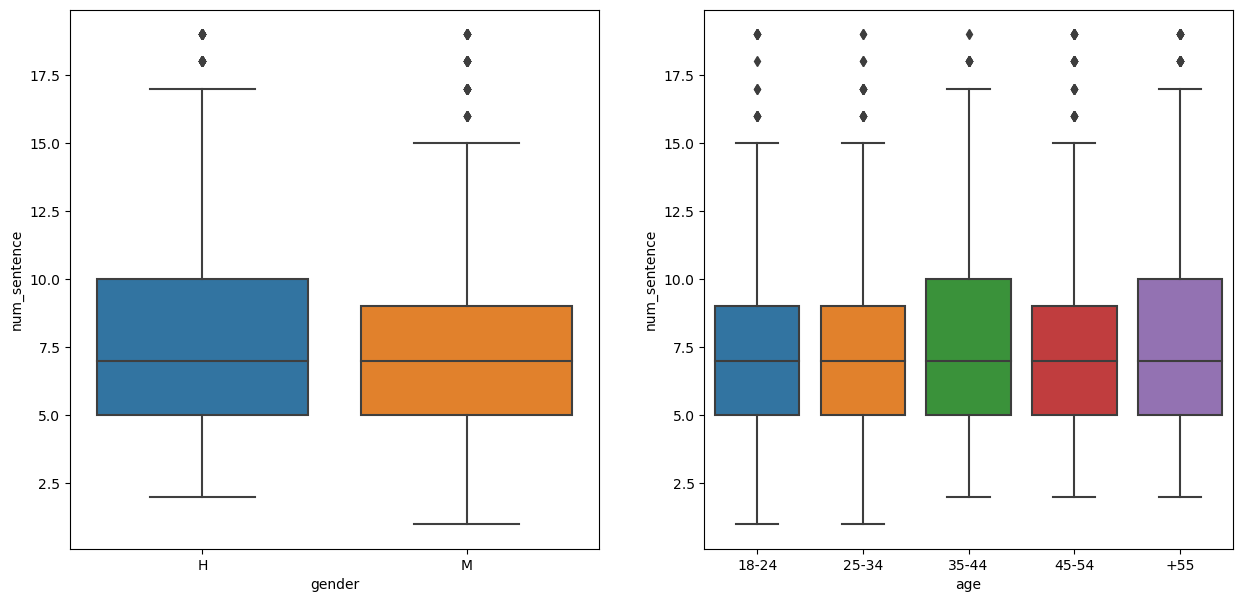

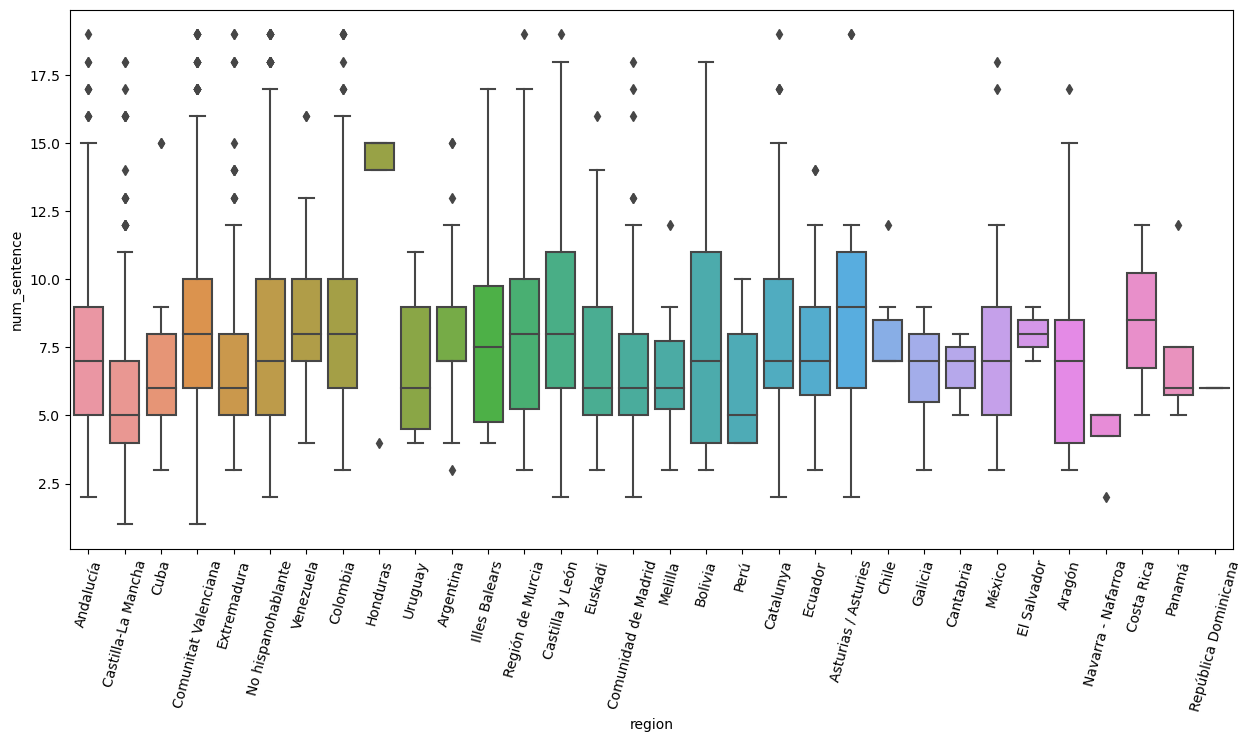

In [60]:
# remove outliers
data = df_struct.copy()
data = remove_outliers(data,column='num_sentence',value=19)
# boxplot
box_plot('num_sentence',data)
# statistics
statistics('num_sentence',data)

### 2. Average number of sentences per paragraph

In [165]:
# Mann-Whitney U test
data = df_struct.copy()
res = mann_whitney(data,'av_sentence_par')
print(res)

MannwhitneyuResult(statistic=1519419.5, pvalue=2.7289904737632796e-08)


In [166]:
# Kruskal-Wallis test
kruskal_posthoc(df_struct,'av_sentence_par')


AGE: KruskalResult(statistic=15.63730965687641, pvalue=0.0035465304769386322)
AGE:           18-24     25-34     35-44     45-54       +55
18-24  1.000000  0.001461  0.796791  1.000000  1.000000
25-34  0.001461  1.000000  0.264933  0.018139  0.061391
35-44  0.796791  0.264933  1.000000  1.000000  1.000000
45-54  1.000000  0.018139  1.000000  1.000000  1.000000
+55    1.000000  0.061391  1.000000  1.000000  1.000000
REGION: KruskalResult(statistic=58.97982455046864, pvalue=5.358010351341774e-05)
REGION:                          Comunidad de Madrid  Andalucía  Extremadura  \
Comunidad de Madrid                 1.000000   1.000000     1.000000   
Andalucía                           1.000000   1.000000     1.000000   
Extremadura                         1.000000   1.000000     1.000000   
Castilla y León                     1.000000   1.000000     1.000000   
Comunidad Valenciana                0.637314   0.011195     1.000000   
Galicia                             1.000000   1.000000     

/var/folders/_x/cddkf2k97y19q18kzrrrxrzw0000gn/T/ipykernel_36317/2864299129.py:42: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  posthoc.set_axis(['18-24','25-34','35-44','45-54','+55'],axis=0,inplace=True)
/var/folders/_x/cddkf2k97y19q18kzrrrxrzw0000gn/T/ipykernel_36317/2864299129.py:43: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  posthoc.set_axis(['18-24','25-34','35-44','45-54','+55'],axis=1,inplace=True)
/var/folders/_x/cddkf2k97y19q18kzrrrxrzw0000gn/T/ipykernel_36317/2864299129.py:80: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  posthoc.set_axis(['Comunidad de Madrid','Andalucía','Extremadura','Castilla y León','Comunidad Valenciana','Galicia','

The d of Cohen for gender is: -0.1353377757808501
The f of Cohen for age is: 0.01720407314657931
The f of Cohen normalized for age is: 0.3530964089680381
The f of Cohen for demography is: 0.03157926507081313
The f of Cohen normalized for demography is: 0.0990909365129455


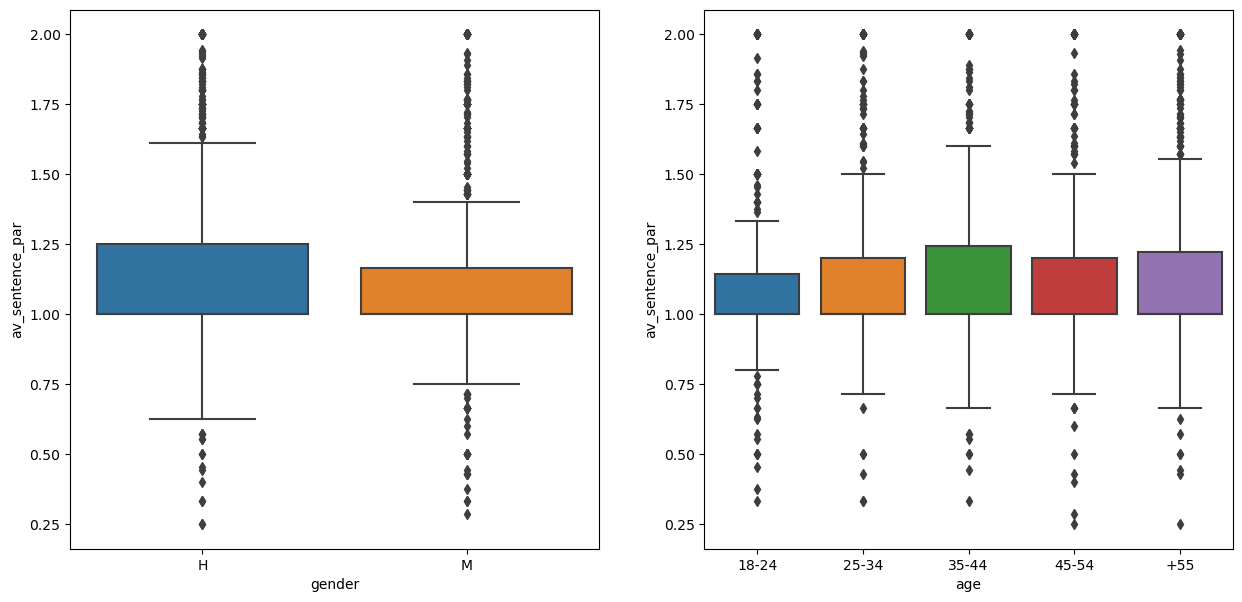

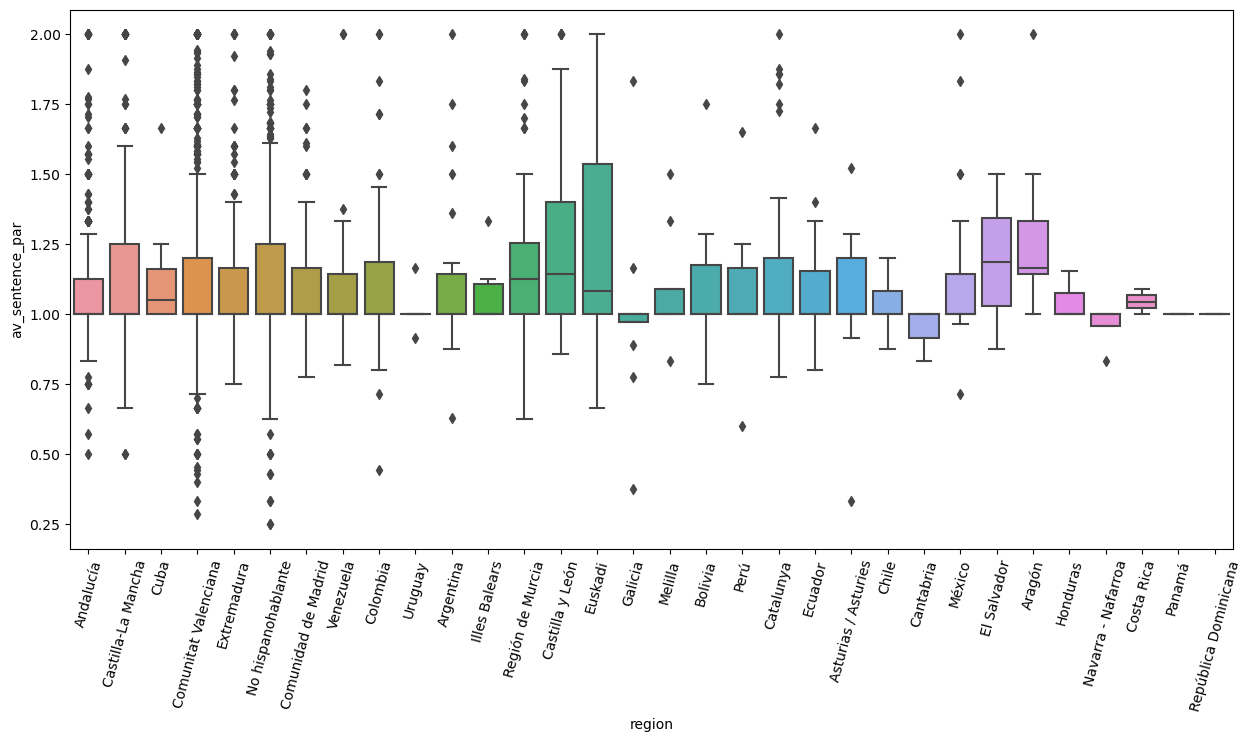

In [62]:
# remove outliers
data = df_struct.copy()
data = remove_outliers(data,column='av_sentence_par',value=2)
# boxplot
box_plot('av_sentence_par',data)
# statistics
statistics('av_sentence_par',data)

### 3. Average number of words per paragraph

In [167]:
# Mann-Whitney U test
data = df_struct.copy()
res = mann_whitney(data,'av_words_par')
print(res)

MannwhitneyuResult(statistic=1584624.0, pvalue=0.0011979739825407633)


In [168]:
# Kruskal-Wallis test
kruskal_posthoc(df_struct,'av_words_par')


AGE: KruskalResult(statistic=15.054142902301686, pvalue=0.0045902285091276)
AGE:           18-24     25-34     35-44     45-54       +55
18-24  1.000000  0.009740  0.039036  0.664138  1.000000
25-34  0.009740  1.000000  1.000000  0.422189  0.160189
35-44  0.039036  1.000000  1.000000  0.700381  0.414049
45-54  0.664138  0.422189  0.700381  1.000000  1.000000
+55    1.000000  0.160189  0.414049  1.000000  1.000000
REGION: KruskalResult(statistic=57.73895672354693, pvalue=8.053894875554195e-05)
REGION:                          Comunidad de Madrid  Andalucía  Extremadura  \
Comunidad de Madrid                 1.000000   1.000000          1.0   
Andalucía                           1.000000   1.000000          1.0   
Extremadura                         1.000000   1.000000          1.0   
Castilla y León                     1.000000   1.000000          1.0   
Comunidad Valenciana                1.000000   1.000000          1.0   
Galicia                             1.000000   1.000000       

/var/folders/_x/cddkf2k97y19q18kzrrrxrzw0000gn/T/ipykernel_36317/2864299129.py:42: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  posthoc.set_axis(['18-24','25-34','35-44','45-54','+55'],axis=0,inplace=True)
/var/folders/_x/cddkf2k97y19q18kzrrrxrzw0000gn/T/ipykernel_36317/2864299129.py:43: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  posthoc.set_axis(['18-24','25-34','35-44','45-54','+55'],axis=1,inplace=True)
/var/folders/_x/cddkf2k97y19q18kzrrrxrzw0000gn/T/ipykernel_36317/2864299129.py:80: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  posthoc.set_axis(['Comunidad de Madrid','Andalucía','Extremadura','Castilla y León','Comunidad Valenciana','Galicia','

The d of Cohen for gender is: -0.10082677859616543
The f of Cohen for age is: 0.5519924695754236
The f of Cohen normalized for age is: 0.3307653224742939
The f of Cohen for demography is: 0.8434458348704083
The f of Cohen normalized for demography is: 0.07668941739922334


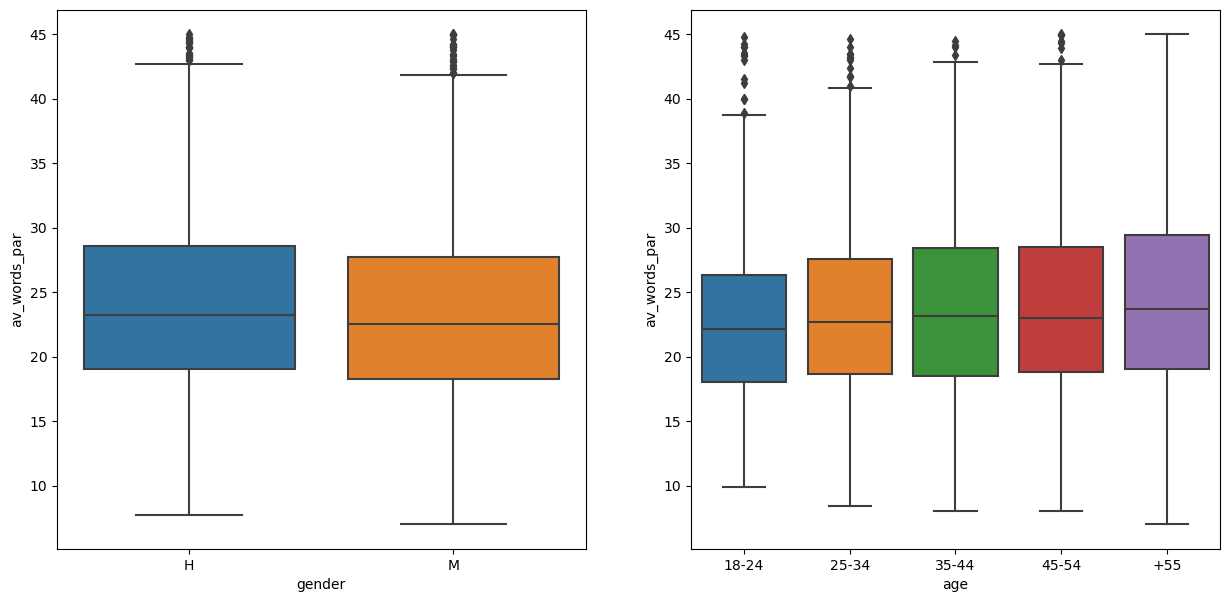

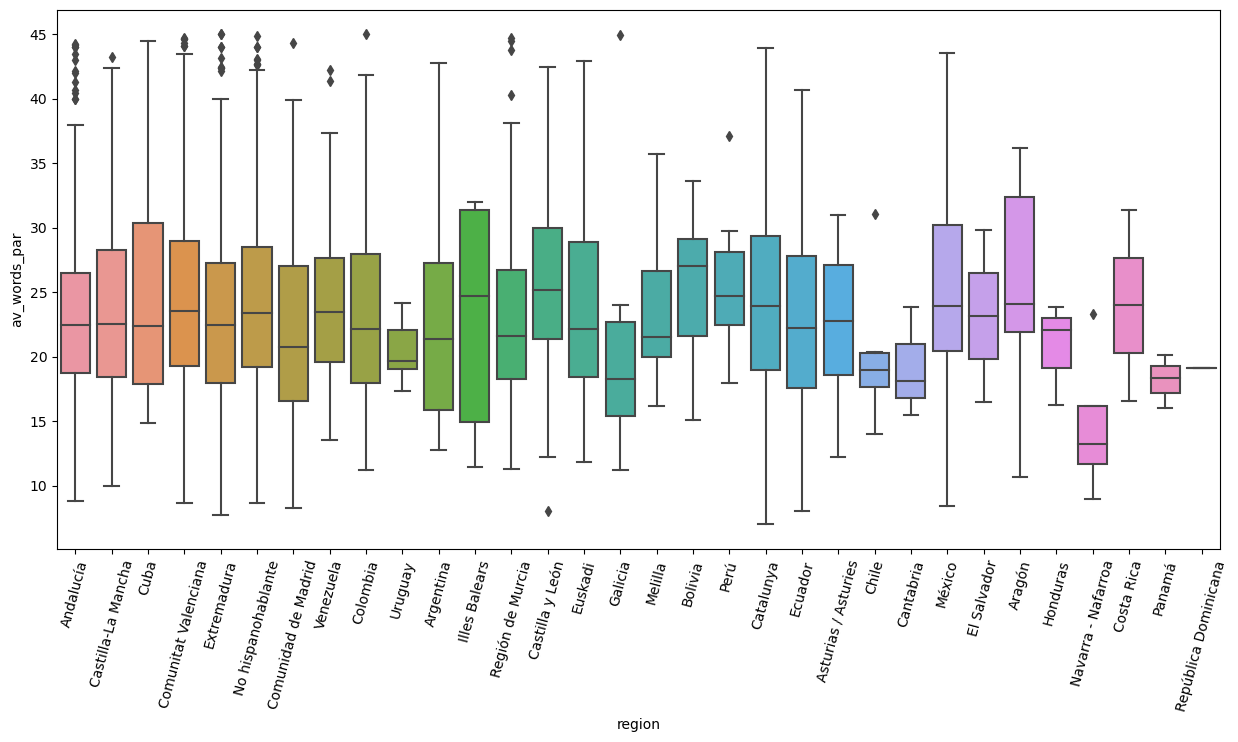

In [64]:
# remove outliers
data = df_struct.copy()
data = remove_outliers(data,column='av_words_par',value=45)
# boxplot
box_plot('av_words_par',data)
# statistics
statistics('av_words_par',data)

### 4. Average number of characters per paragraph

In [169]:
# Mann-Whitney U test
data = df_struct.copy()
res = mann_whitney(data,'av_char_par')
print(res)

MannwhitneyuResult(statistic=1566731.5, pvalue=0.00014877213940770937)


In [170]:
# Kruskal-Wallis test
kruskal_posthoc(df_struct,'av_char_par')


AGE: KruskalResult(statistic=20.03883459051134, pvalue=0.0004906603750826809)
AGE:          18-24     25-34     35-44     45-54       +55
18-24  1.00000  0.000710  0.048190  1.000000  1.000000
25-34  0.00071  1.000000  0.936045  0.026578  0.017734
35-44  0.04819  0.936045  1.000000  0.427396  0.350998
45-54  1.00000  0.026578  0.427396  1.000000  1.000000
+55    1.00000  0.017734  0.350998  1.000000  1.000000
REGION: KruskalResult(statistic=55.32510891967097, pvalue=0.00017574555564304318)
REGION:                          Comunidad de Madrid  Andalucía  Extremadura  \
Comunidad de Madrid                      1.0   1.000000          1.0   
Andalucía                                1.0   1.000000          1.0   
Extremadura                              1.0   1.000000          1.0   
Castilla y León                          1.0   1.000000          1.0   
Comunidad Valenciana                     1.0   1.000000          1.0   
Galicia                                  1.0   1.000000          

/var/folders/_x/cddkf2k97y19q18kzrrrxrzw0000gn/T/ipykernel_36317/2864299129.py:42: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  posthoc.set_axis(['18-24','25-34','35-44','45-54','+55'],axis=0,inplace=True)
/var/folders/_x/cddkf2k97y19q18kzrrrxrzw0000gn/T/ipykernel_36317/2864299129.py:43: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  posthoc.set_axis(['18-24','25-34','35-44','45-54','+55'],axis=1,inplace=True)
/var/folders/_x/cddkf2k97y19q18kzrrrxrzw0000gn/T/ipykernel_36317/2864299129.py:80: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  posthoc.set_axis(['Comunidad de Madrid','Andalucía','Extremadura','Castilla y León','Comunidad Valenciana','Galicia','

The d of Cohen for gender is: -0.10699635319862481
The f of Cohen for age is: 3.6749664048504567
The f of Cohen normalized for age is: 0.32980339553376575
The f of Cohen for demography is: 5.4795156620852525
The f of Cohen normalized for demography is: 0.055362648438761805


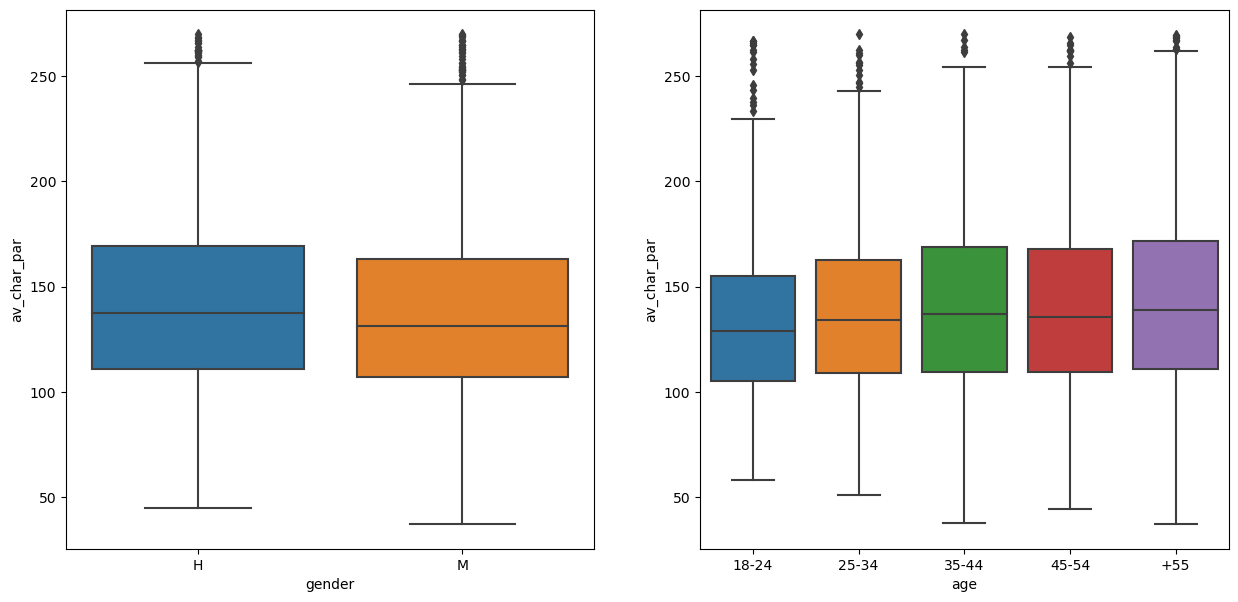

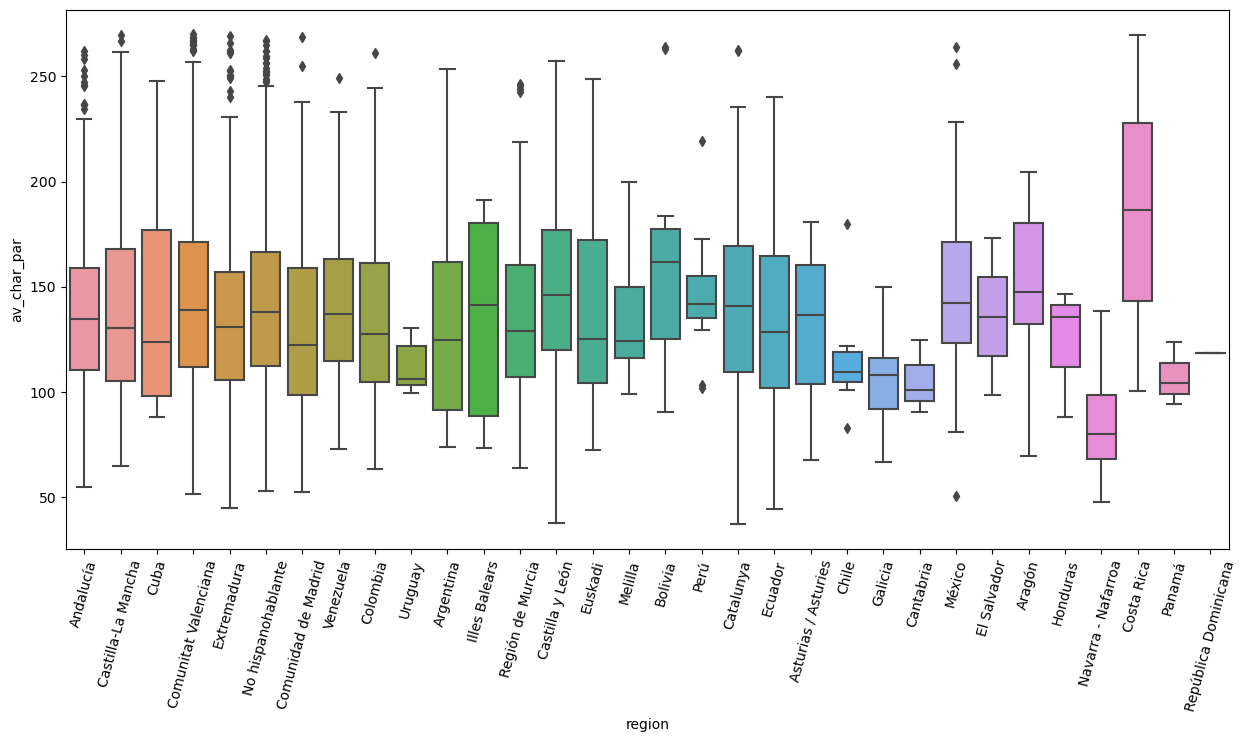

In [66]:
# remove outliers
data = df_struct.copy()
data = remove_outliers(data,column='av_char_par',value=270)
# boxplot
box_plot('av_char_par',data)
# statistics
statistics('av_char_par',data)

### 5. Variation in length

In [171]:
# Mann-Whitney U test
data = df_struct.copy()
res = mann_whitney(data,'variation')
print(res)

MannwhitneyuResult(statistic=1692913.5, pvalue=0.9107202961301162)


In [172]:
# Kruskal-Wallis test
kruskal_posthoc(df_struct,'variation')


AGE: KruskalResult(statistic=10.064303757999262, pvalue=0.0393583129510887)
AGE:           18-24     25-34    35-44    45-54       +55
18-24  1.000000  0.272444  0.30039  1.00000  1.000000
25-34  0.272444  1.000000  1.00000  0.30039  0.272444
35-44  0.300390  1.000000  1.00000  0.30039  0.300390
45-54  1.000000  0.300390  0.30039  1.00000  1.000000
+55    1.000000  0.272444  0.30039  1.00000  1.000000
REGION: KruskalResult(statistic=64.47805517963504, pvalue=8.392659677955326e-06)
REGION:                          Comunidad de Madrid  Andalucía  Extremadura  \
Comunidad de Madrid                      1.0   1.000000          1.0   
Andalucía                                1.0   1.000000          1.0   
Extremadura                              1.0   1.000000          1.0   
Castilla y León                          1.0   1.000000          1.0   
Comunidad Valenciana                     1.0   1.000000          1.0   
Galicia                                  1.0   1.000000          1.0   
Ca

/var/folders/_x/cddkf2k97y19q18kzrrrxrzw0000gn/T/ipykernel_36317/2864299129.py:42: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  posthoc.set_axis(['18-24','25-34','35-44','45-54','+55'],axis=0,inplace=True)
/var/folders/_x/cddkf2k97y19q18kzrrrxrzw0000gn/T/ipykernel_36317/2864299129.py:43: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  posthoc.set_axis(['18-24','25-34','35-44','45-54','+55'],axis=1,inplace=True)
/var/folders/_x/cddkf2k97y19q18kzrrrxrzw0000gn/T/ipykernel_36317/2864299129.py:80: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  posthoc.set_axis(['Comunidad de Madrid','Andalucía','Extremadura','Castilla y León','Comunidad Valenciana','Galicia','

The d of Cohen for gender is: 0.02230541721621913
The f of Cohen for age is: 305.2354055820686
The f of Cohen normalized for age is: 0.39472582832941294
The f of Cohen for demography is: 555.5014338179694
The f of Cohen normalized for demography is: 0.11656140234706393


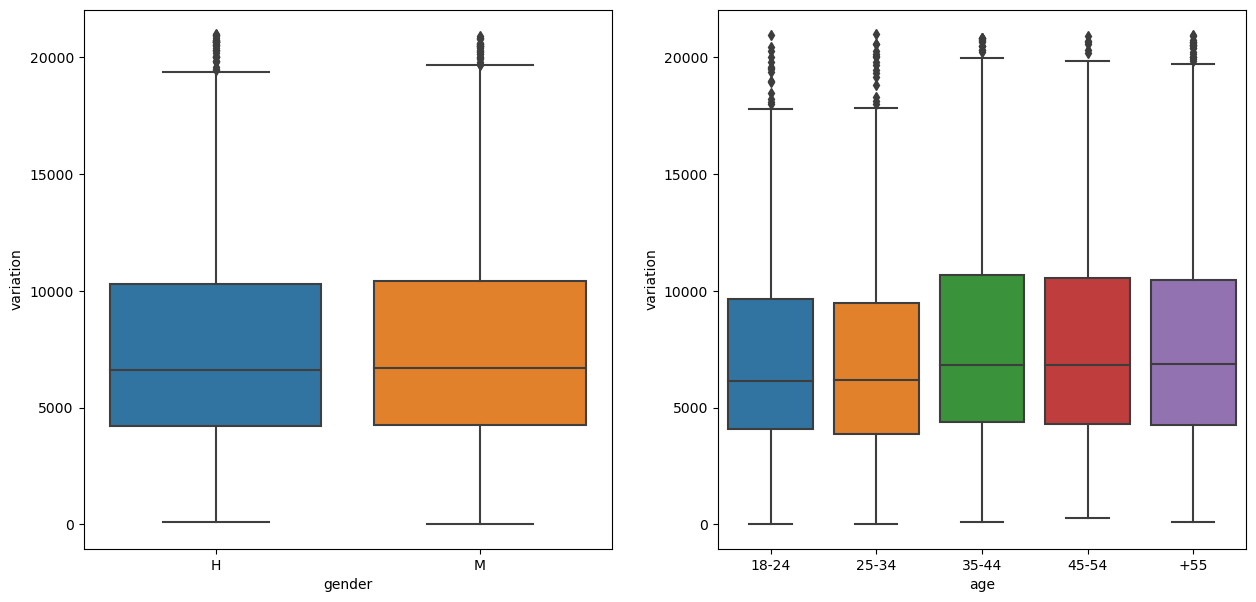

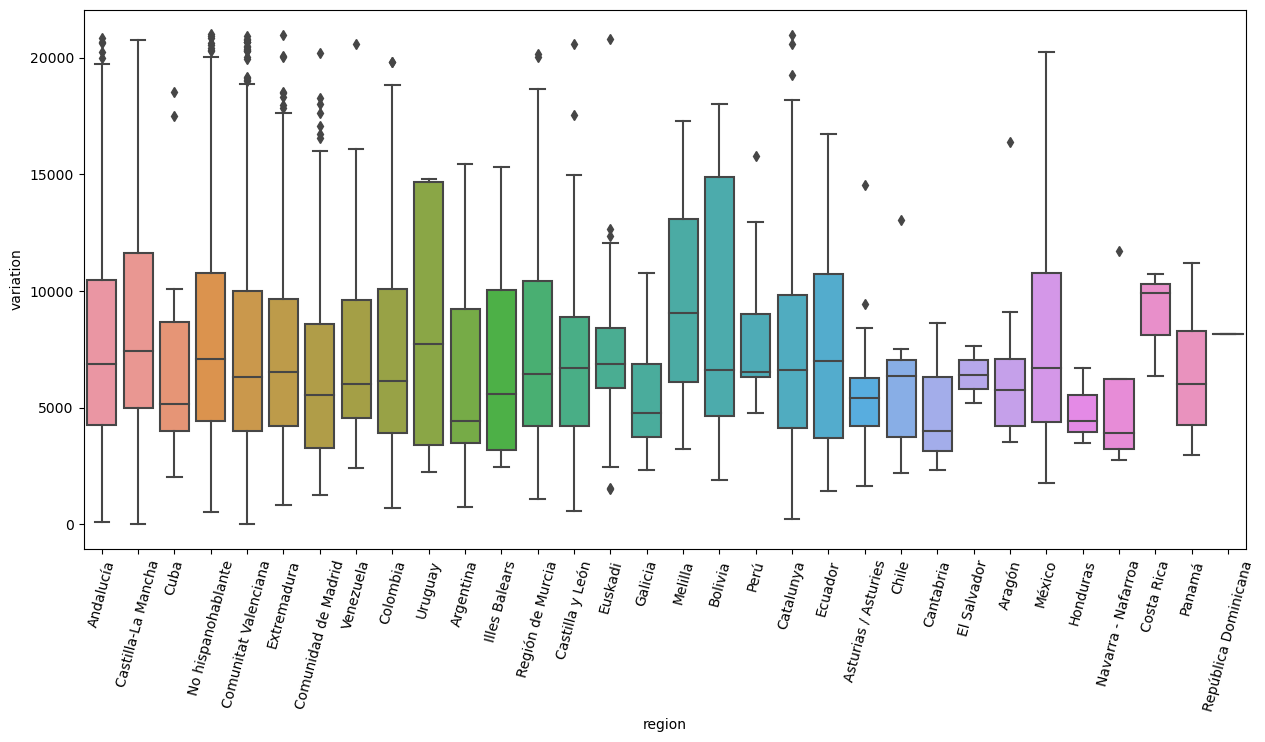

In [69]:
# remove outliers
data = df_struct.copy()
data = remove_outliers(data,column='variation',value=21000)
# boxplot
box_plot('variation',data)
# statistics
statistics('variation',data)

## SYNTACTIC BASED FEATURES ANALYSIS: 

1. Number of determiners
2. Number of prepositions
3. Number of singular nouns
4. Number of plurar nouns
5. Number of adverbs
6. Number of adjetives
7. Number of proper nouns
8. Number of pronouns
9. Number of past tense verbs
10. Number of future tense verbs
11. Number of conjunctions

#### Steps:

- Create boxplots to visualize independence between studied features and the users personal traits (gender, age and demography)
- Statistical measures: d of Cohen for traits with only 2 options, f of Cohen for traits with more than 2 possibilities.
The d of Cohen can be either positive or negative. Two variables are considered independant when the absolute value of d is 0 or very close to 0, and as the absolute value of d gets bigger, the relationship between the variables becomes stronger. Normaly, when the value is below 0.2 the dependency between the variables is considered small, when it is around 0.5 it's considered moderate, and the dependency is big when the value is greater than 0.8. These measures apply as well for the f of Cohen normilized. This measure is calculated dividing the f of Cohen between the difference of the max and min values of the groups of each of the studied features.

In [173]:
# load data for character based features analysis
def df_syntactic_based():
    data = pd.DataFrame() 
    pos_tag = nltk.UnigramTagger(cess_esp.tagged_sents())

    tags_dict = {}
    num_det = []
    num_pre = []
    num_sing = []
    num_plural = []
    num_adv = []
    num_adj = []
    num_prop = []
    num_pronouns = []
    num_past = []
    num_future = []
    num_conj = []

    for file in files:
        with open(f'Atestados/{file}') as f:
            _dict = json.load(f)

            # denuncia
            text = _dict['denuncia']
            
            # clean text
            text = quitar_tags(text)
            cleaned_text = clean_text(text,file)
            cleaned_text = cleaned_text.translate(str.maketrans('','',string.punctuation))
            cleaned_text = cleaned_text.replace('\n','')
            analysis = pos_tag.tag(cleaned_text.split(' '))

            det = 0
            pre = 0
            sing = 0
            plural = 0
            adv = 0
            adj = 0
            prop = 0
            pronouns = 0
            past = 0
            future = 0
            conj = 0

            for word,tag in analysis:
                if tag != None:
                    if tag[0] == 'd':
                        det += 1
                    elif tag[0] == 'a':
                        adj += 1
                    elif tag[0] == 'c':
                        conj += 1
                    elif tag[0] == 'p':
                        pronouns += 1
                    elif tag[0] == 'n':
                        if tag[1] == 'p':
                            prop += 1
                        if tag[3] == 's':
                            sing += 1
                        elif tag[3] == 'p':
                            plural += 1
                    elif tag[0] == 'r':
                        adv += 1
                    elif (tag[0] == 'v' and tag[3] == 'f'):
                        future += 1
                    elif (tag[0] == 'v' and tag[3] == 's'):
                        past += 1
                    elif tag[0] == 's':
                        pre += 1

            
            num_det.append(det)
            num_pre.append(pre)
            num_sing.append(sing)
            num_plural.append(plural)
            num_adv.append(adv)
            num_adj.append(adj)
            num_prop.append(prop)
            num_pronouns.append(pronouns)
            num_past.append(past)
            num_future.append(future)
            num_conj.append(conj)

    for k,v in tags_dict.items():
        data[k] = v
    
    data['num_det'] = num_det
    data['num_pre'] = num_pre
    data['num_sing'] = num_sing
    data['num_plural'] = num_plural
    data['num_adv'] = num_adv
    data['num_adj'] = num_adj
    data['num_prop'] = num_prop
    data['num_pronouns'] = num_pronouns
    data['num_past'] = num_past
    data['num_future'] = num_future
    data['num_conj'] = num_conj

    return pd.concat([denunciante_df,data],axis=1)

In [174]:
df_syntactic = df_syntactic_based()
df_syntactic.head()

gender    age                region  num_det  num_pre  num_sing  num_plural  \
0      H  25-34             Andalucía        5       10         5           0   
1      M    +55    Castilla-La Mancha       24       30        17           3   
2      M  25-34               LATINOS       18       21         9           3   
3      M    +55                  ASIA       26       60        29           7   
4      M    +55  Comunidad Valenciana       98      133        76          14   

   num_adv  num_adj  num_prop  num_pronouns  num_past  num_future  num_conj  
0        0        3         0             3         0           0         2  
1        5        6         0            17         0           0         6  
2        1        5         0             9         1           0         8  
3        0       16         1            13         1           0        17  
4       13       32         3            49         0           0        31

### 1. Number of determiners

In [175]:
# Mann-Whitney U test
data = df_syntactic.copy()
res = mann_whitney(data,'num_det')
print(res)

MannwhitneyuResult(statistic=1586107.5, pvalue=0.0014017831373771441)


In [176]:
# Kruskal-Wallis test
kruskal_posthoc(df_syntactic,'num_det')


AGE: KruskalResult(statistic=32.975365925130866, pvalue=1.2084329018958036e-06)
AGE:           18-24     25-34     35-44     45-54       +55
18-24  1.000000  0.000003  0.011607  0.035498  1.000000
25-34  0.000003  1.000000  0.224590  0.095042  0.000218
35-44  0.011607  0.224590  1.000000  1.000000  0.095042
45-54  0.035498  0.095042  1.000000  1.000000  0.182327
+55    1.000000  0.000218  0.095042  0.182327  1.000000
REGION: KruskalResult(statistic=219.96211689898936, pvalue=4.337825126136082e-34)
REGION:                          Comunidad de Madrid     Andalucía  Extremadura  \
Comunidad de Madrid                 1.000000  1.000000e+00     1.000000   
Andalucía                           1.000000  1.000000e+00     0.021620   
Extremadura                         1.000000  2.162028e-02     1.000000   
Castilla y León                     1.000000  4.817190e-01     1.000000   
Comunidad Valenciana                1.000000  2.931879e-10     1.000000   
Galicia                             1.0

/var/folders/_x/cddkf2k97y19q18kzrrrxrzw0000gn/T/ipykernel_36317/2864299129.py:42: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  posthoc.set_axis(['18-24','25-34','35-44','45-54','+55'],axis=0,inplace=True)
/var/folders/_x/cddkf2k97y19q18kzrrrxrzw0000gn/T/ipykernel_36317/2864299129.py:43: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  posthoc.set_axis(['18-24','25-34','35-44','45-54','+55'],axis=1,inplace=True)
/var/folders/_x/cddkf2k97y19q18kzrrrxrzw0000gn/T/ipykernel_36317/2864299129.py:80: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  posthoc.set_axis(['Comunidad de Madrid','Andalucía','Extremadura','Castilla y León','Comunidad Valenciana','Galicia','

The d of Cohen for gender is: -0.08291671720094888
The f of Cohen for age is: 1.4484508812398245
The f of Cohen normalized for age is: 0.3363429555863493
The f of Cohen for demography is: 3.0413520732431625
The f of Cohen normalized for demography is: 0.10765848046878451


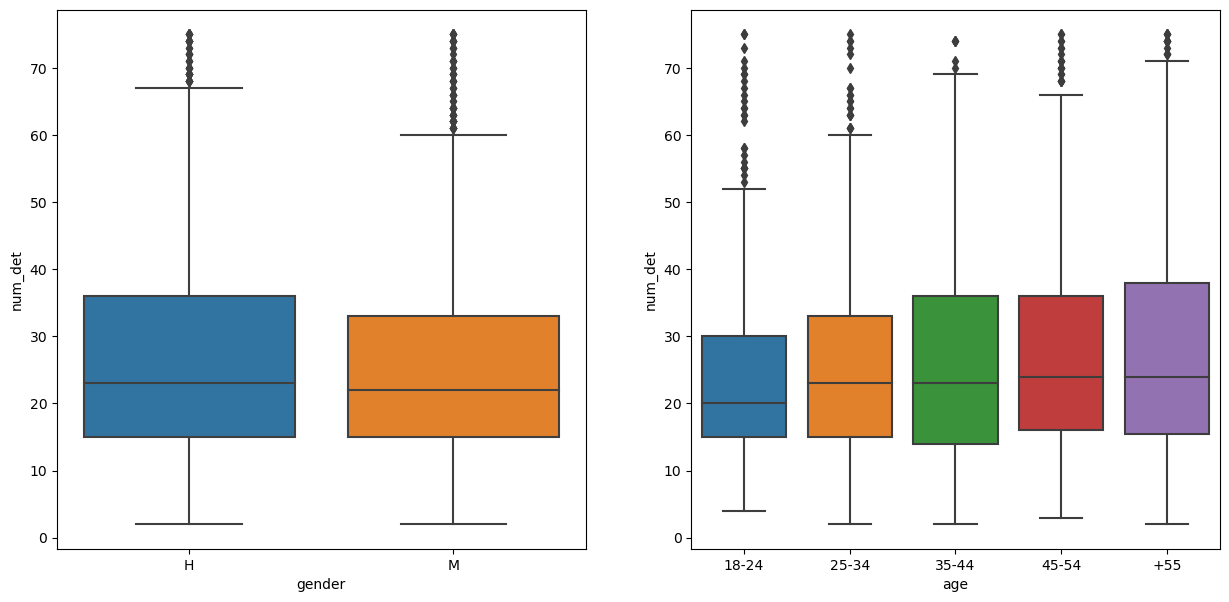

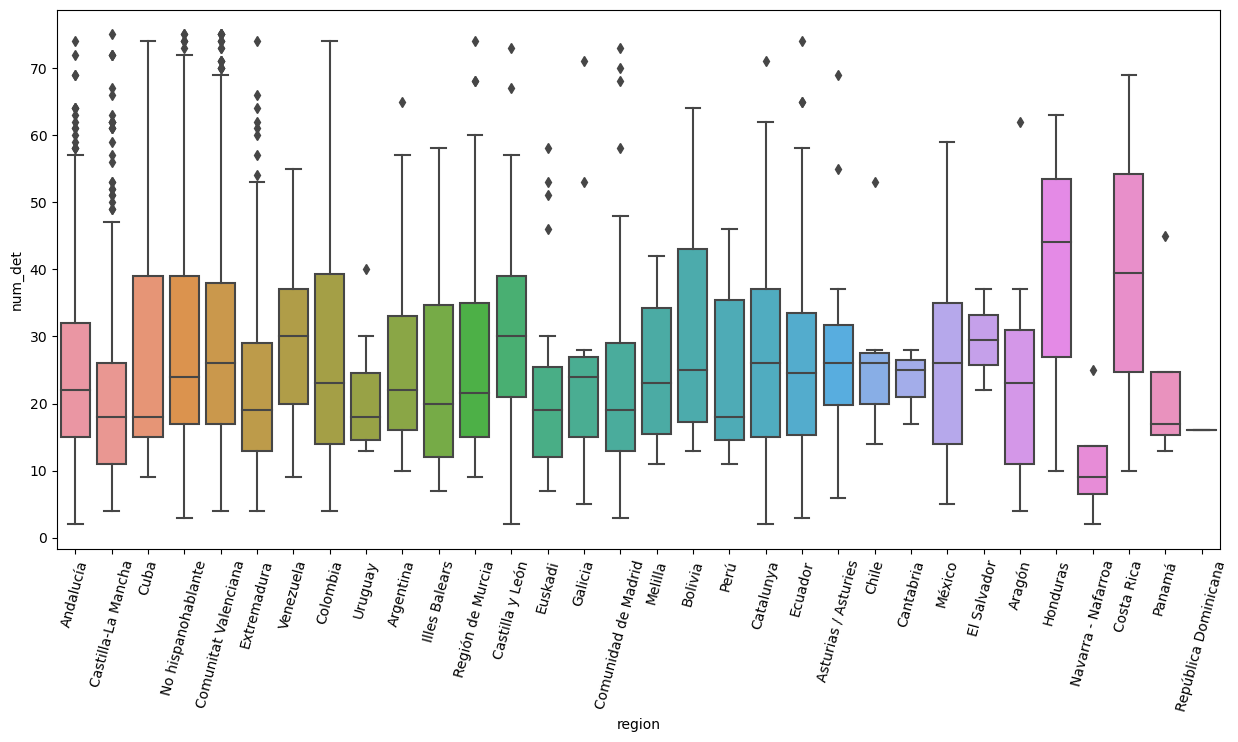

In [74]:
# remove outliers
data = df_syntactic.copy()
data = remove_outliers(data,column='num_det',value=75)
# boxplot
box_plot('num_det',data)
# statistics
statistics('num_det',data)

### 2. Number of prepositions

In [177]:
# Mann-Whitney U test
data = df_syntactic.copy()
res = mann_whitney(data,'num_pre')
print(res)

MannwhitneyuResult(statistic=1540050.0, pvalue=3.838589544181517e-06)


In [178]:
# Kruskal-Wallis test
kruskal_posthoc(df_syntactic,'num_pre')


AGE: KruskalResult(statistic=32.86155875670022, pvalue=1.275028782558403e-06)
AGE:           18-24     25-34     35-44     45-54       +55
18-24  1.000000  0.000002  0.039862  0.213889  0.735699
25-34  0.000002  1.000000  0.140868  0.008709  0.000046
35-44  0.039862  0.140868  1.000000  0.735699  0.140868
45-54  0.213889  0.008709  0.735699  1.000000  0.455493
+55    0.735699  0.000046  0.140868  0.455493  1.000000
REGION: KruskalResult(statistic=222.59236533835417, pvalue=1.3176376744869968e-34)
REGION:                          Comunidad de Madrid     Andalucía  Extremadura  \
Comunidad de Madrid                 1.000000  1.000000e+00     1.000000   
Andalucía                           1.000000  1.000000e+00     0.004459   
Extremadura                         1.000000  4.459305e-03     1.000000   
Castilla y León                     1.000000  1.582674e-01     1.000000   
Comunidad Valenciana                1.000000  3.156226e-11     1.000000   
Galicia                             1.00

/var/folders/_x/cddkf2k97y19q18kzrrrxrzw0000gn/T/ipykernel_36317/2864299129.py:42: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  posthoc.set_axis(['18-24','25-34','35-44','45-54','+55'],axis=0,inplace=True)
/var/folders/_x/cddkf2k97y19q18kzrrrxrzw0000gn/T/ipykernel_36317/2864299129.py:43: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  posthoc.set_axis(['18-24','25-34','35-44','45-54','+55'],axis=1,inplace=True)
/var/folders/_x/cddkf2k97y19q18kzrrrxrzw0000gn/T/ipykernel_36317/2864299129.py:80: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  posthoc.set_axis(['Comunidad de Madrid','Andalucía','Extremadura','Castilla y León','Comunidad Valenciana','Galicia','

The d of Cohen for gender is: -0.13347757195509452
The f of Cohen for age is: 1.2506493035484814
The f of Cohen normalized for age is: 0.34689890974086
The f of Cohen for demography is: 2.9611577811548715
The f of Cohen normalized for demography is: 0.10420496590574328


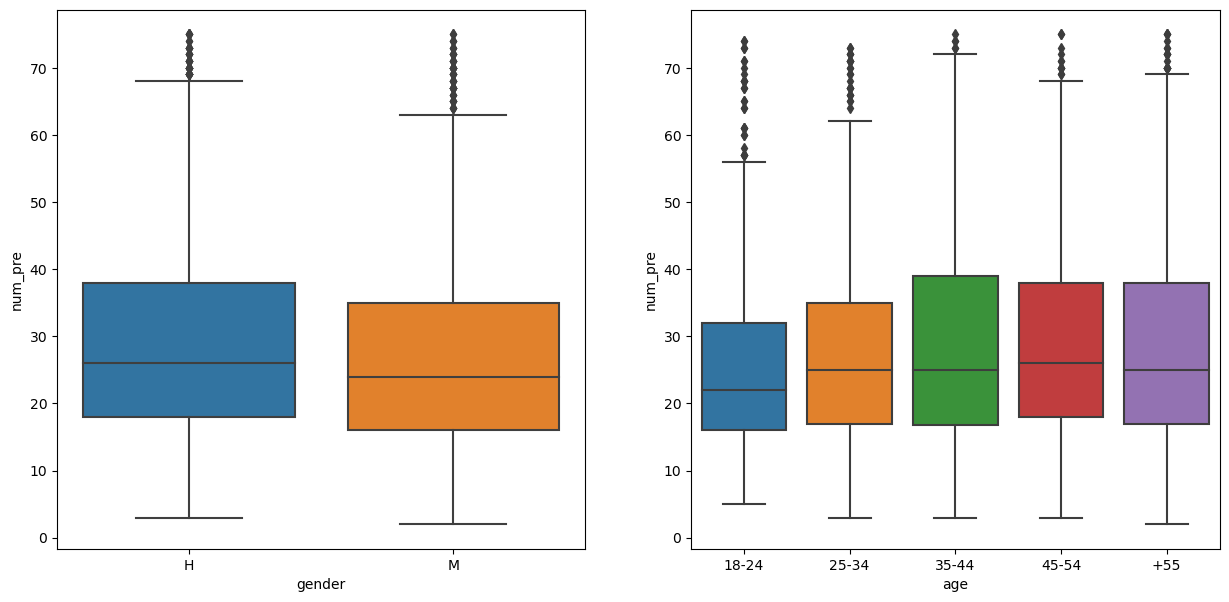

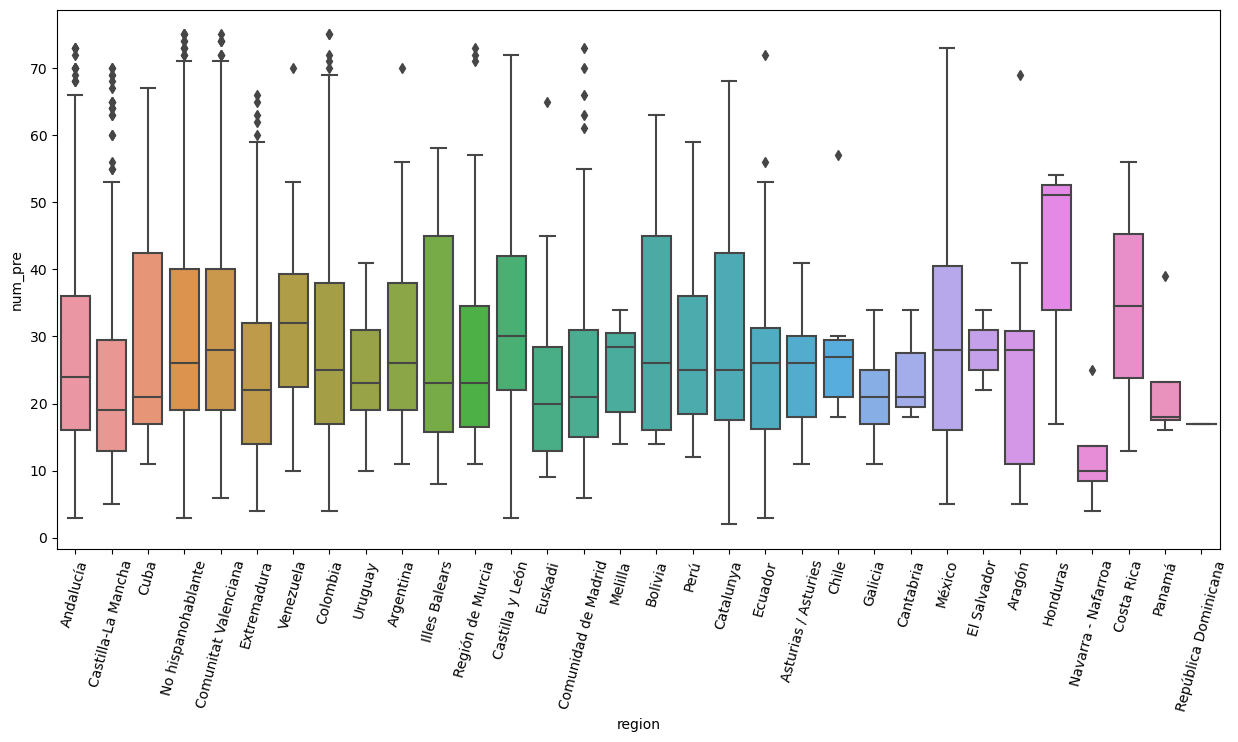

In [77]:
# remove outliers
data = df_syntactic.copy()
data = remove_outliers(data,column='num_pre',value=75)
# boxplot
box_plot('num_pre',data)
# statistics
statistics('num_pre',data)

### 3. Number of singular nouns

In [179]:
# Mann-Whitney U test
data = df_syntactic.copy()
res = mann_whitney(data,'num_sing')
print(res)

MannwhitneyuResult(statistic=1598853.5, pvalue=0.005098031585205131)


In [180]:
# Kruskal-Wallis test
kruskal_posthoc(df_syntactic,'num_sing')


AGE: KruskalResult(statistic=30.92657086204688, pvalue=3.168815640789554e-06)
AGE:           18-24     25-34     35-44     45-54       +55
18-24  1.000000  0.000007  0.041867  0.081637  1.000000
25-34  0.000007  1.000000  0.185283  0.081637  0.000128
35-44  0.041867  0.185283  1.000000  1.000000  0.103690
45-54  0.081637  0.081637  1.000000  1.000000  0.185283
+55    1.000000  0.000128  0.103690  0.185283  1.000000
REGION: KruskalResult(statistic=184.3568527346956, pvalue=3.7355685818658766e-27)
REGION:                          Comunidad de Madrid     Andalucía  Extremadura  \
Comunidad de Madrid                 1.000000  1.000000e+00     1.000000   
Andalucía                           1.000000  1.000000e+00     0.009533   
Extremadura                         1.000000  9.532958e-03     1.000000   
Castilla y León                     1.000000  3.283055e-02     1.000000   
Comunidad Valenciana                1.000000  9.881411e-07     1.000000   
Galicia                             1.000

/var/folders/_x/cddkf2k97y19q18kzrrrxrzw0000gn/T/ipykernel_36317/2864299129.py:42: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  posthoc.set_axis(['18-24','25-34','35-44','45-54','+55'],axis=0,inplace=True)
/var/folders/_x/cddkf2k97y19q18kzrrrxrzw0000gn/T/ipykernel_36317/2864299129.py:43: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  posthoc.set_axis(['18-24','25-34','35-44','45-54','+55'],axis=1,inplace=True)
/var/folders/_x/cddkf2k97y19q18kzrrrxrzw0000gn/T/ipykernel_36317/2864299129.py:80: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  posthoc.set_axis(['Comunidad de Madrid','Andalucía','Extremadura','Castilla y León','Comunidad Valenciana','Galicia','

The d of Cohen for gender is: -0.07982300476150837
The f of Cohen for age is: 0.8321443818821168
The f of Cohen normalized for age is: 0.3365660449261829
The f of Cohen for demography is: 1.739620428406209
The f of Cohen normalized for demography is: 0.09403353667060589


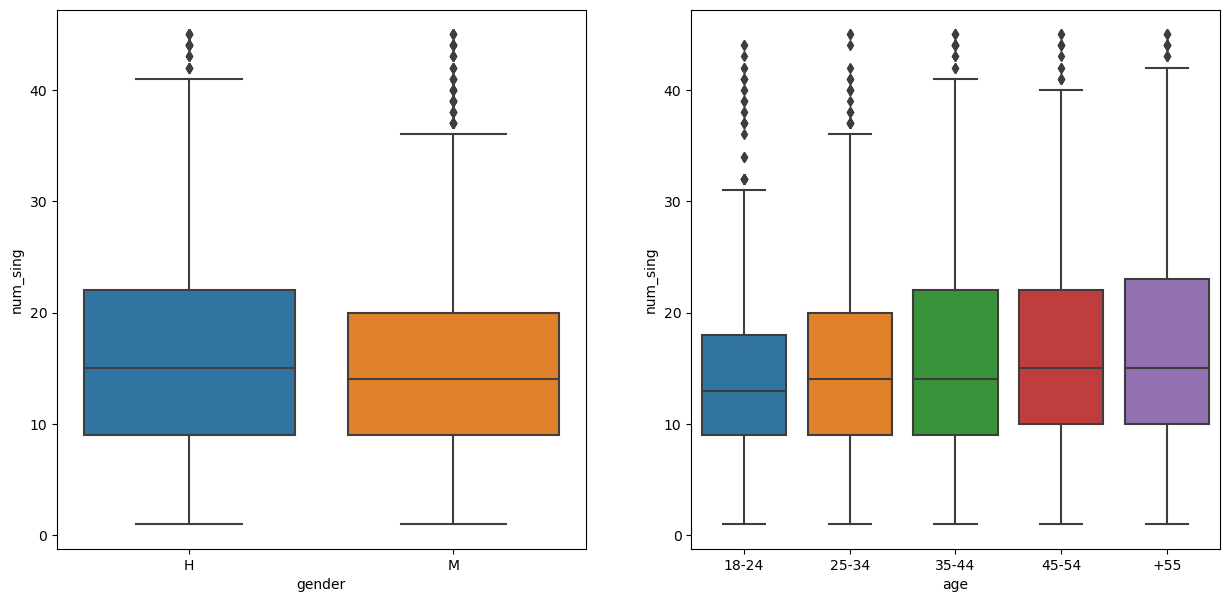

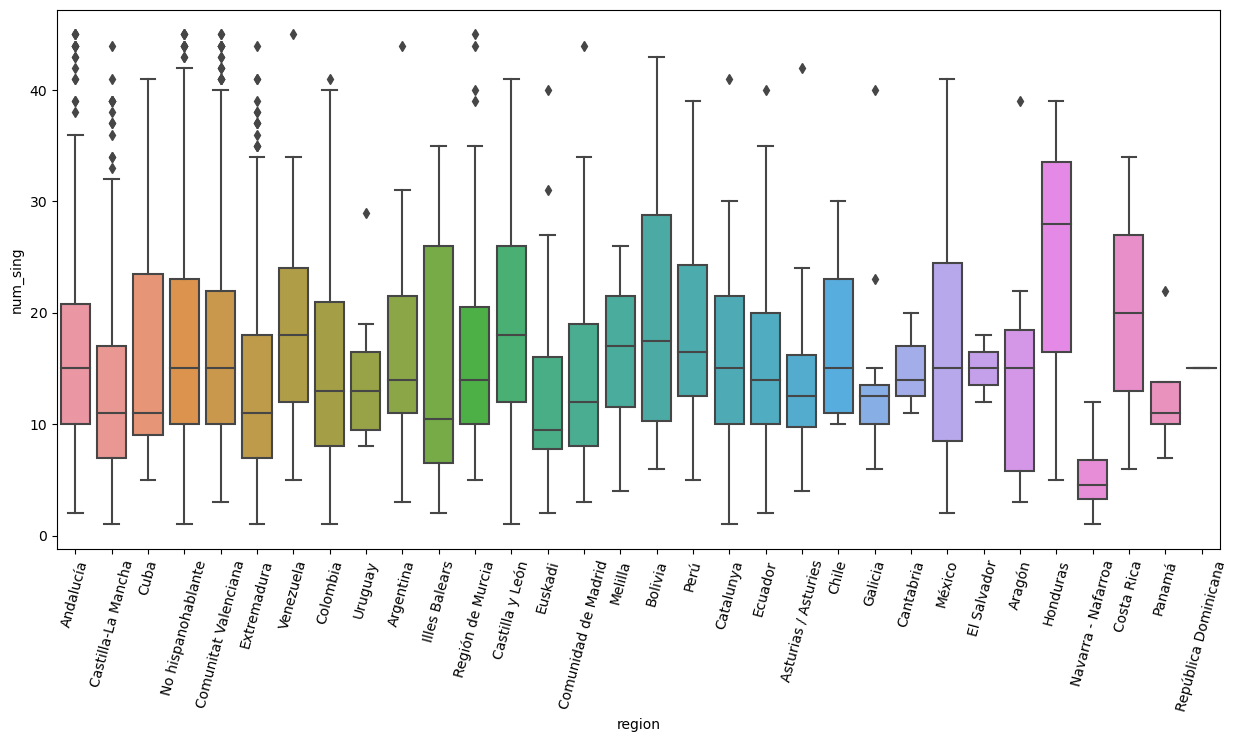

In [79]:
# remove outliers
data = df_syntactic.copy()
data = remove_outliers(data,column='num_sing',value=45)
# boxplot
box_plot('num_sing',data)
# statistics
statistics('num_sing',data)

### 4. Number of plural nouns

In [181]:
# Mann-Whitney U test
data = df_syntactic.copy()
res = mann_whitney(data,'num_plural')
print(res)

MannwhitneyuResult(statistic=1595520.5, pvalue=0.003463848371316343)


In [182]:
# Kruskal-Wallis test
kruskal_posthoc(df_syntactic,'num_plural')


AGE: KruskalResult(statistic=26.20419300370928, pvalue=2.8781635586715936e-05)
AGE:           18-24     25-34     35-44     45-54       +55
18-24  1.000000  0.000591  0.235977  0.594079  0.594079
25-34  0.000591  1.000000  0.388142  0.008082  0.000041
35-44  0.235977  0.388142  1.000000  0.576235  0.033376
45-54  0.594079  0.008082  0.576235  1.000000  0.576235
+55    0.594079  0.000041  0.033376  0.576235  1.000000
REGION: KruskalResult(statistic=120.16442268932417, pvalue=3.886744480213385e-15)
REGION:                          Comunidad de Madrid     Andalucía  Extremadura  \
Comunidad de Madrid                 1.000000  1.000000e+00     1.000000   
Andalucía                           1.000000  1.000000e+00     0.060996   
Extremadura                         1.000000  6.099574e-02     1.000000   
Castilla y León                     1.000000  9.137252e-01     1.000000   
Comunidad Valenciana                1.000000  2.222075e-05     1.000000   
Galicia                             1.00

/var/folders/_x/cddkf2k97y19q18kzrrrxrzw0000gn/T/ipykernel_36317/2864299129.py:42: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  posthoc.set_axis(['18-24','25-34','35-44','45-54','+55'],axis=0,inplace=True)
/var/folders/_x/cddkf2k97y19q18kzrrrxrzw0000gn/T/ipykernel_36317/2864299129.py:43: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  posthoc.set_axis(['18-24','25-34','35-44','45-54','+55'],axis=1,inplace=True)
/var/folders/_x/cddkf2k97y19q18kzrrrxrzw0000gn/T/ipykernel_36317/2864299129.py:80: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  posthoc.set_axis(['Comunidad de Madrid','Andalucía','Extremadura','Castilla y León','Comunidad Valenciana','Galicia','

The d of Cohen for gender is: -0.0713881618431885
The f of Cohen for age is: 0.2618117886684591
The f of Cohen normalized for age is: 0.33022017790086705
The f of Cohen for demography is: 0.5026829405190093
The f of Cohen normalized for demography is: 0.0713025447544694


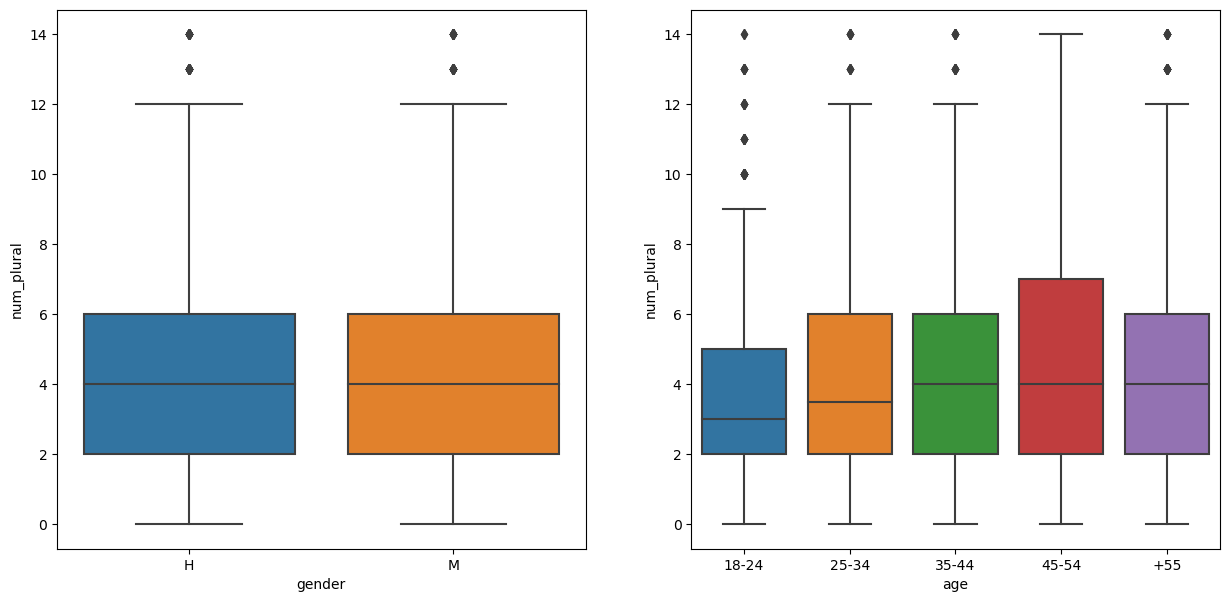

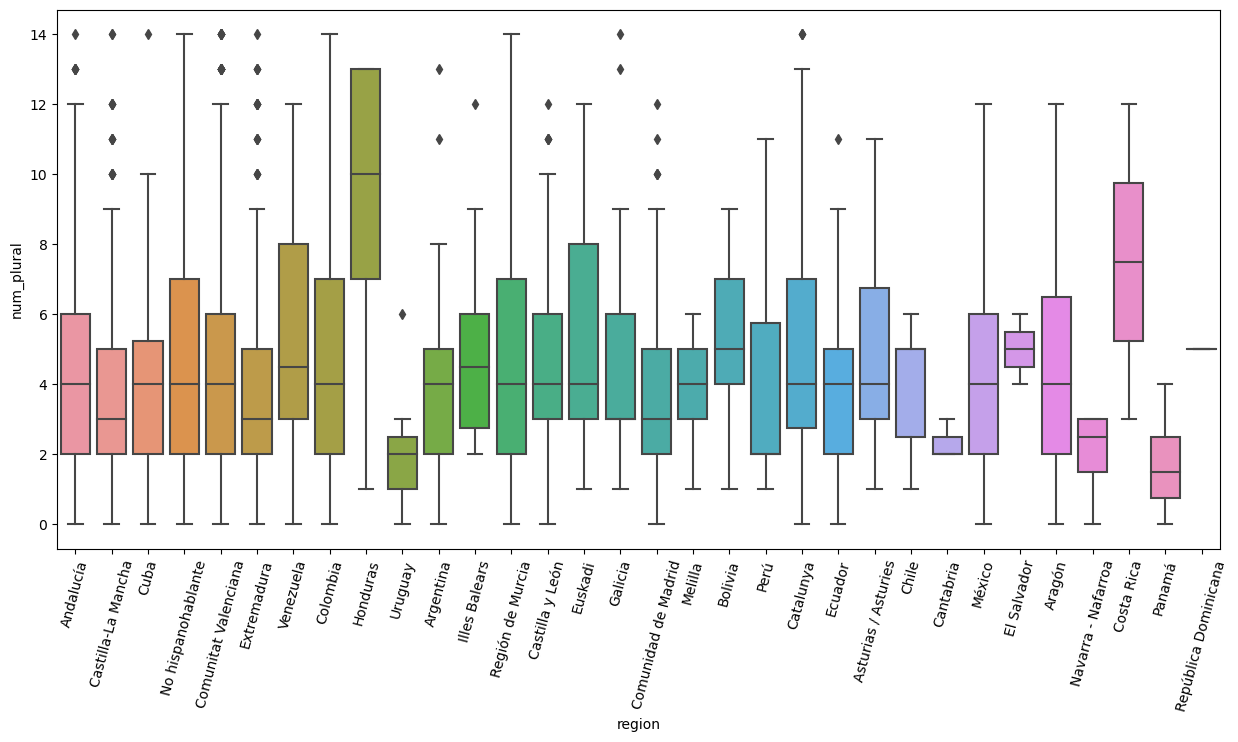

In [81]:
# remove outliers
data = df_syntactic.copy()
data = remove_outliers(data,column='num_plural',value=14)
# boxplot
box_plot('num_plural',data)
# statistics
statistics('num_plural',data)

### 5. Number of adverbs

In [183]:
# Mann-Whitney U test
data = df_syntactic.copy()
res = mann_whitney(data,'num_adv')
print(res)

MannwhitneyuResult(statistic=1705271.5, pvalue=0.6187178561962002)


In [184]:
# Kruskal-Wallis test
kruskal_posthoc(df_syntactic,'num_adv')


AGE: KruskalResult(statistic=19.461737227793552, pvalue=0.0006376352741927399)
AGE:           18-24     25-34     35-44     45-54      +55
18-24  1.000000  0.008217  0.008907  0.008907  0.02183
25-34  0.008217  1.000000  1.000000  1.000000  1.00000
35-44  0.008907  1.000000  1.000000  1.000000  1.00000
45-54  0.008907  1.000000  1.000000  1.000000  1.00000
+55    0.021830  1.000000  1.000000  1.000000  1.00000
REGION: KruskalResult(statistic=196.07109508643856, pvalue=2.0245260599621284e-29)
REGION:                          Comunidad de Madrid     Andalucía  Extremadura  \
Comunidad de Madrid                 1.000000  1.000000e+00     1.000000   
Andalucía                           1.000000  1.000000e+00     1.000000   
Extremadura                         1.000000  1.000000e+00     1.000000   
Castilla y León                     1.000000  1.000000e+00     1.000000   
Comunidad Valenciana                0.001016  1.726494e-11     0.010378   
Galicia                             1.000000 

/var/folders/_x/cddkf2k97y19q18kzrrrxrzw0000gn/T/ipykernel_36317/2864299129.py:42: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  posthoc.set_axis(['18-24','25-34','35-44','45-54','+55'],axis=0,inplace=True)
/var/folders/_x/cddkf2k97y19q18kzrrrxrzw0000gn/T/ipykernel_36317/2864299129.py:43: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  posthoc.set_axis(['18-24','25-34','35-44','45-54','+55'],axis=1,inplace=True)
/var/folders/_x/cddkf2k97y19q18kzrrrxrzw0000gn/T/ipykernel_36317/2864299129.py:80: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  posthoc.set_axis(['Comunidad de Madrid','Andalucía','Extremadura','Castilla y León','Comunidad Valenciana','Galicia','

The d of Cohen for gender is: 0.0017966047541900926
The f of Cohen for age is: 0.26887331983081597
The f of Cohen normalized for age is: 0.4080289613394338
The f of Cohen for demography is: 0.6361516716998351
The f of Cohen normalized for demography is: 0.11566394030906092


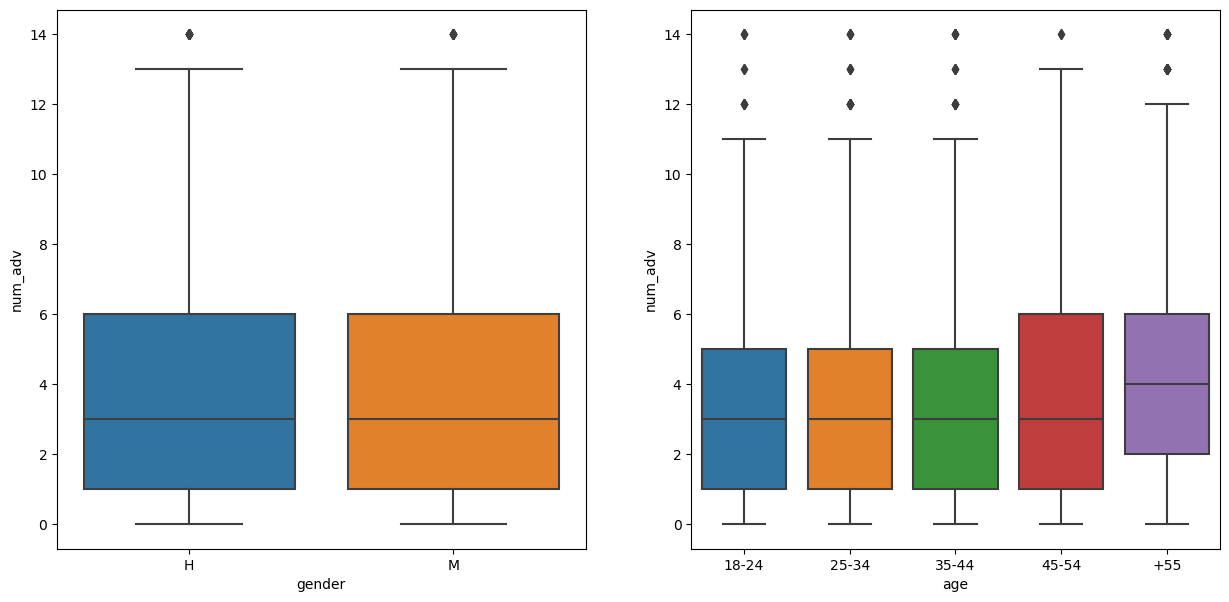

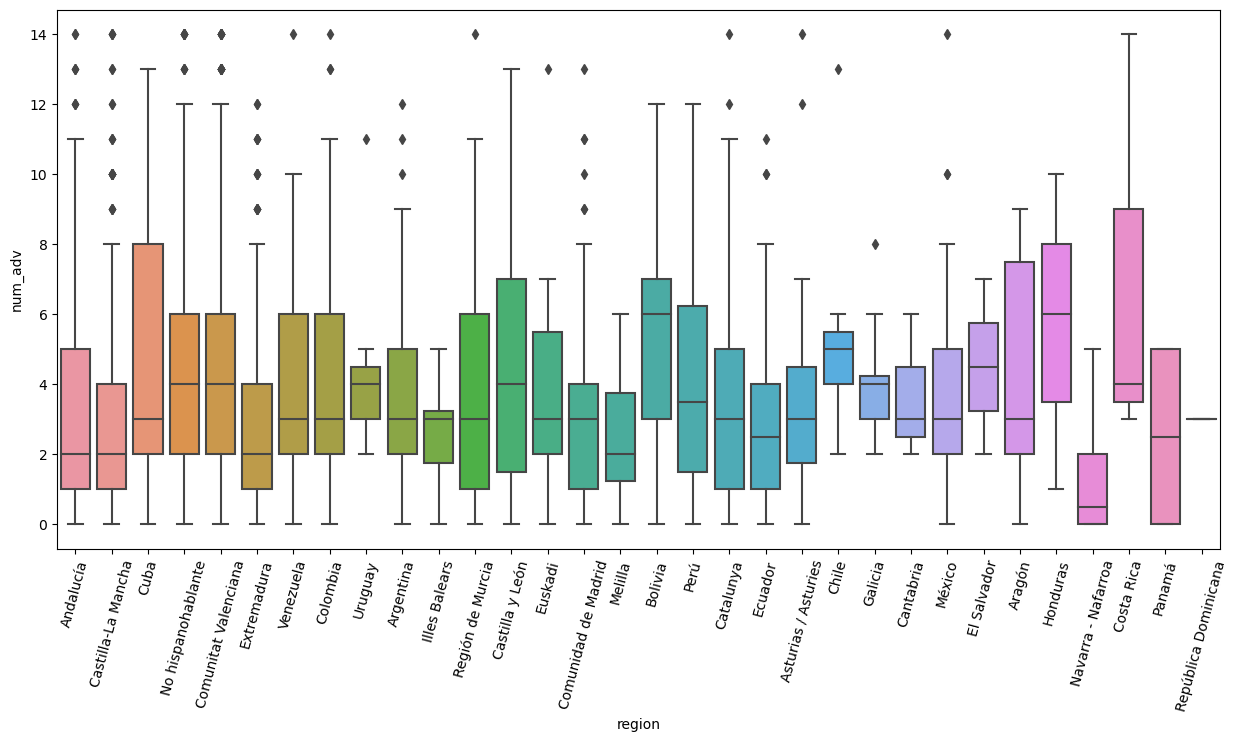

In [83]:
# remove outliers
data = df_syntactic.copy()
data = remove_outliers(data,column='num_adv',value=14)
# boxplot
box_plot('num_adv',data)
# statistics
statistics('num_adv',data)

### 6. Number of adjetives

In [185]:
# Mann-Whitney U test
data = df_syntactic.copy()
res = mann_whitney(data,'num_adj')
print(res)

MannwhitneyuResult(statistic=1558320.0, pvalue=4.783879341573256e-05)


In [186]:
# Kruskal-Wallis test
kruskal_posthoc(df_syntactic,'num_adj')


AGE: KruskalResult(statistic=27.406268346604342, pvalue=1.6451835718073993e-05)
AGE:           18-24     25-34     35-44     45-54       +55
18-24  1.000000  0.000008  0.115486  0.175420  0.994184
25-34  0.000008  1.000000  0.124172  0.037197  0.000550
35-44  0.115486  0.124172  1.000000  0.994184  0.414247
45-54  0.175420  0.037197  0.994184  1.000000  0.578134
+55    0.994184  0.000550  0.414247  0.578134  1.000000
REGION: KruskalResult(statistic=158.9081665673523, pvalue=2.690624270000352e-22)


/var/folders/_x/cddkf2k97y19q18kzrrrxrzw0000gn/T/ipykernel_36317/2864299129.py:42: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  posthoc.set_axis(['18-24','25-34','35-44','45-54','+55'],axis=0,inplace=True)
/var/folders/_x/cddkf2k97y19q18kzrrrxrzw0000gn/T/ipykernel_36317/2864299129.py:43: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  posthoc.set_axis(['18-24','25-34','35-44','45-54','+55'],axis=1,inplace=True)
/var/folders/_x/cddkf2k97y19q18kzrrrxrzw0000gn/T/ipykernel_36317/2864299129.py:80: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  posthoc.set_axis(['Comunidad de Madrid','Andalucía','Extremadura','Castilla y León','Comunidad Valenciana','Galicia','

REGION:                          Comunidad de Madrid     Andalucía  Extremadura  \
Comunidad de Madrid                 1.000000  1.000000e+00     1.000000   
Andalucía                           1.000000  1.000000e+00     0.001235   
Extremadura                         1.000000  1.235388e-03     1.000000   
Castilla y León                     1.000000  1.986946e-01     1.000000   
Comunidad Valenciana                1.000000  1.598798e-09     1.000000   
Galicia                             1.000000  1.000000e+00     1.000000   
Cataluña                            1.000000  1.000000e+00     1.000000   
Plazas de Soberanía                 1.000000  1.000000e+00     1.000000   
País Vasco                          1.000000  1.000000e+00     1.000000   
Castilla-La Mancha                  1.000000  1.000000e+00     1.000000   
Asturias                            0.154345  4.031788e-14     1.000000   
Aragón                              1.000000  1.000000e+00     1.000000   
Cantabria        

The d of Cohen for gender is: -0.09485021995209117
The f of Cohen for age is: 0.3530096445369318
The f of Cohen normalized for age is: 0.3461388965194796
The f of Cohen for demography is: 0.7118406896774798
The f of Cohen normalized for demography is: 0.12457212069355898


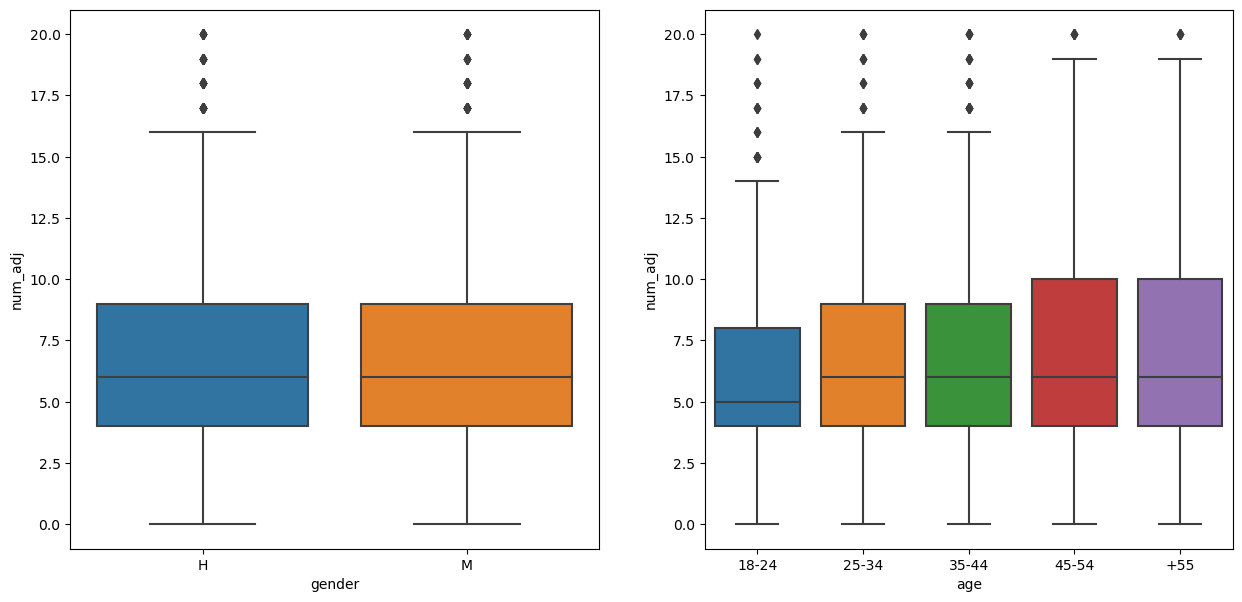

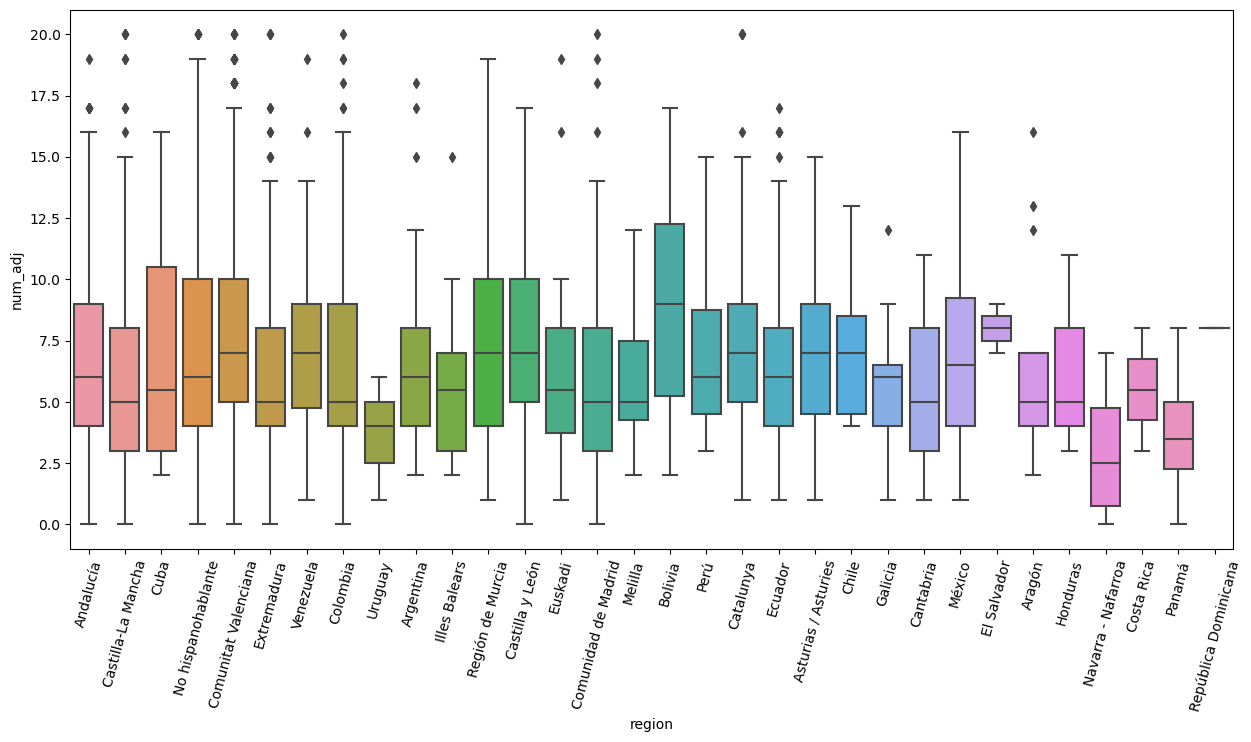

In [85]:
# remove outliers
data = df_syntactic.copy()
data = remove_outliers(data,column='num_adj',value=20)
# boxplot
box_plot('num_adj',data)
# statistics
statistics('num_adj',data)

### 7. Number of proper nouns

In [187]:
# Mann-Whitney U test
data = df_syntactic.copy()
res = mann_whitney(data,'num_prop')
print(res)

MannwhitneyuResult(statistic=1596409.0, pvalue=5.6048762536450245e-05)


In [188]:
# Kruskal-Wallis test
kruskal_posthoc(df_syntactic,'num_prop')


AGE: KruskalResult(statistic=27.529684076356766, pvalue=1.5532231811530488e-05)
AGE:           18-24     25-34     35-44     45-54       +55
18-24  1.000000  0.000040  0.002131  0.091028  0.752579
25-34  0.000040  1.000000  0.752579  0.144745  0.012518
35-44  0.002131  0.752579  1.000000  0.752579  0.144745
45-54  0.091028  0.144745  0.752579  1.000000  0.752579
+55    0.752579  0.012518  0.144745  0.752579  1.000000
REGION: KruskalResult(statistic=89.29184554481103, pvalue=9.343682017556114e-10)
REGION:                          Comunidad de Madrid     Andalucía  Extremadura  \
Comunidad de Madrid                 1.000000  3.929523e-04     1.000000   
Andalucía                           0.000393  1.000000e+00     0.000029   
Extremadura                         1.000000  2.855370e-05     1.000000   
Castilla y León                     1.000000  3.196442e-01     1.000000   
Comunidad Valenciana                1.000000  2.595680e-08     1.000000   
Galicia                             1.00

/var/folders/_x/cddkf2k97y19q18kzrrrxrzw0000gn/T/ipykernel_36317/2864299129.py:42: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  posthoc.set_axis(['18-24','25-34','35-44','45-54','+55'],axis=0,inplace=True)
/var/folders/_x/cddkf2k97y19q18kzrrrxrzw0000gn/T/ipykernel_36317/2864299129.py:43: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  posthoc.set_axis(['18-24','25-34','35-44','45-54','+55'],axis=1,inplace=True)
/var/folders/_x/cddkf2k97y19q18kzrrrxrzw0000gn/T/ipykernel_36317/2864299129.py:80: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  posthoc.set_axis(['Comunidad de Madrid','Andalucía','Extremadura','Castilla y León','Comunidad Valenciana','Galicia','

The d of Cohen for gender is: -0.11782656898484364
The f of Cohen for age is: 0.03497732370446343
The f of Cohen normalized for age is: 0.36547964483878703
The f of Cohen for demography is: 0.052082064309077095
The f of Cohen normalized for demography is: 0.08680344051512849


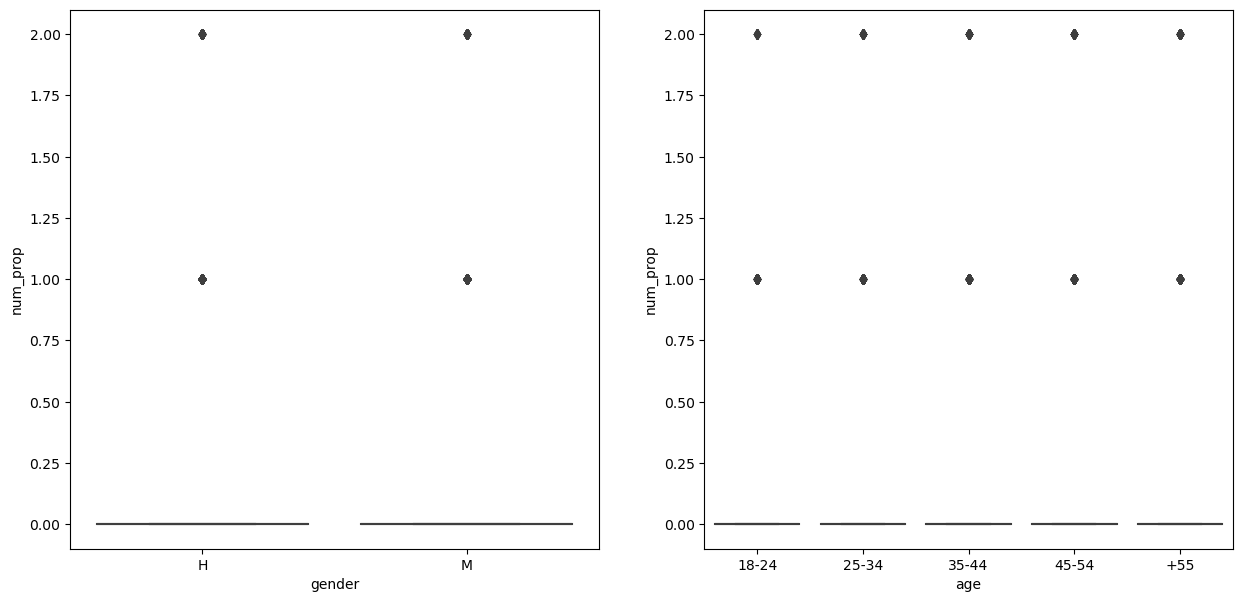

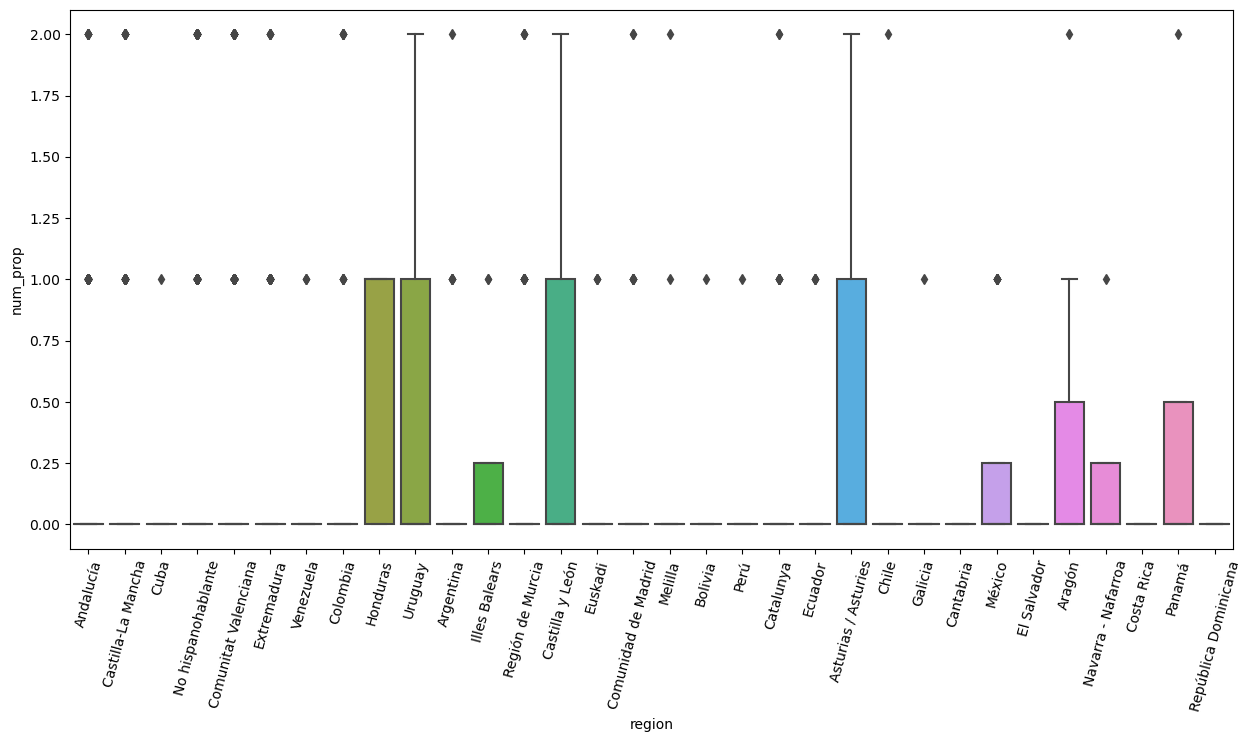

In [88]:
# remove outliers
data = df_syntactic.copy()
data = remove_outliers(data,column='num_prop',value=2)
# boxplot
box_plot('num_prop',data)
# statistics
statistics('num_prop',data)

### 8. Number of pronouns

In [189]:
# Mann-Whitney U test
data = df_syntactic.copy()
res = mann_whitney(data,'num_pronouns')
print(res)

MannwhitneyuResult(statistic=1639485.5, pvalue=0.12289842105798925)


In [190]:
# Kruskal-Wallis test
kruskal_posthoc(df_syntactic,'num_pronouns')


AGE: KruskalResult(statistic=37.708805869882156, pvalue=1.286748519373565e-07)
AGE:           18-24     25-34     35-44     45-54       +55
18-24  1.000000  0.000011  0.000054  0.000062  0.122687
25-34  0.000011  1.000000  1.000000  1.000000  0.075518
35-44  0.000054  1.000000  1.000000  1.000000  0.151316
45-54  0.000062  1.000000  1.000000  1.000000  0.204234
+55    0.122687  0.075518  0.151316  0.204234  1.000000
REGION: KruskalResult(statistic=242.2664471786328, pvalue=1.6992620081099e-38)
REGION:                          Comunidad de Madrid     Andalucía  Extremadura  \
Comunidad de Madrid                 1.000000  7.771607e-01     1.000000   
Andalucía                           0.777161  1.000000e+00     0.405891   
Extremadura                         1.000000  4.058905e-01     1.000000   
Castilla y León                     1.000000  2.052082e-01     1.000000   
Comunidad Valenciana                1.000000  2.939765e-10     1.000000   
Galicia                             1.00000

/var/folders/_x/cddkf2k97y19q18kzrrrxrzw0000gn/T/ipykernel_36317/2864299129.py:42: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  posthoc.set_axis(['18-24','25-34','35-44','45-54','+55'],axis=0,inplace=True)
/var/folders/_x/cddkf2k97y19q18kzrrrxrzw0000gn/T/ipykernel_36317/2864299129.py:43: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  posthoc.set_axis(['18-24','25-34','35-44','45-54','+55'],axis=1,inplace=True)
/var/folders/_x/cddkf2k97y19q18kzrrrxrzw0000gn/T/ipykernel_36317/2864299129.py:80: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  posthoc.set_axis(['Comunidad de Madrid','Andalucía','Extremadura','Castilla y León','Comunidad Valenciana','Galicia','

The d of Cohen for gender is: -0.03285418721231857
The f of Cohen for age is: 0.9751106538399869
The f of Cohen normalized for age is: 0.39836152904565414
The f of Cohen for demography is: 1.881010060683134
The f of Cohen normalized for demography is: 0.1437714696063542


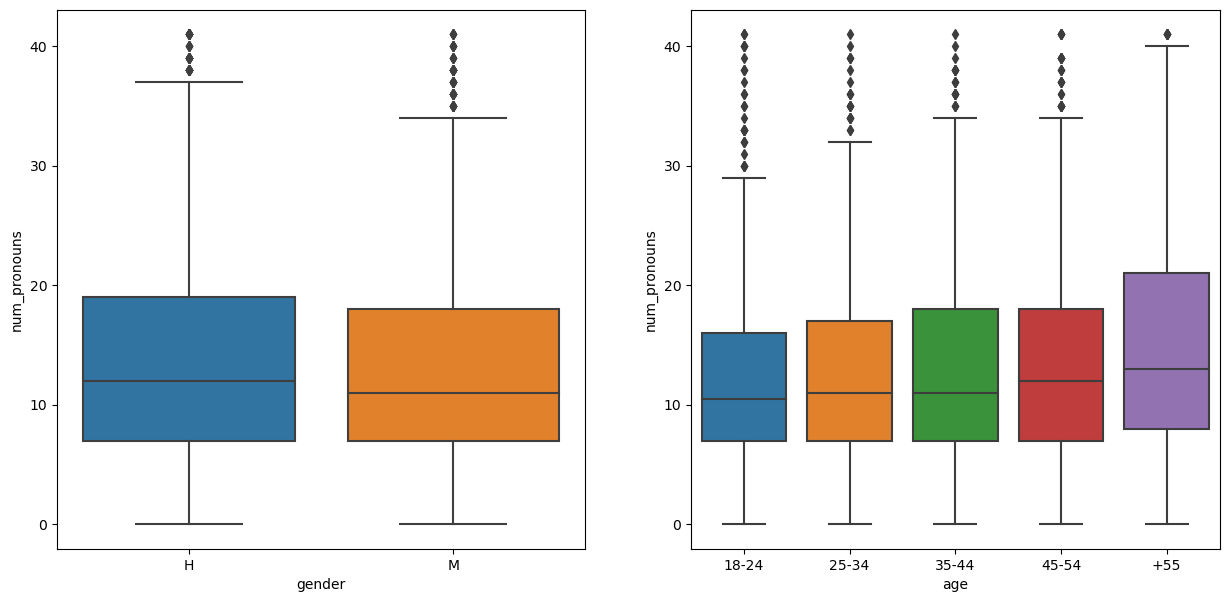

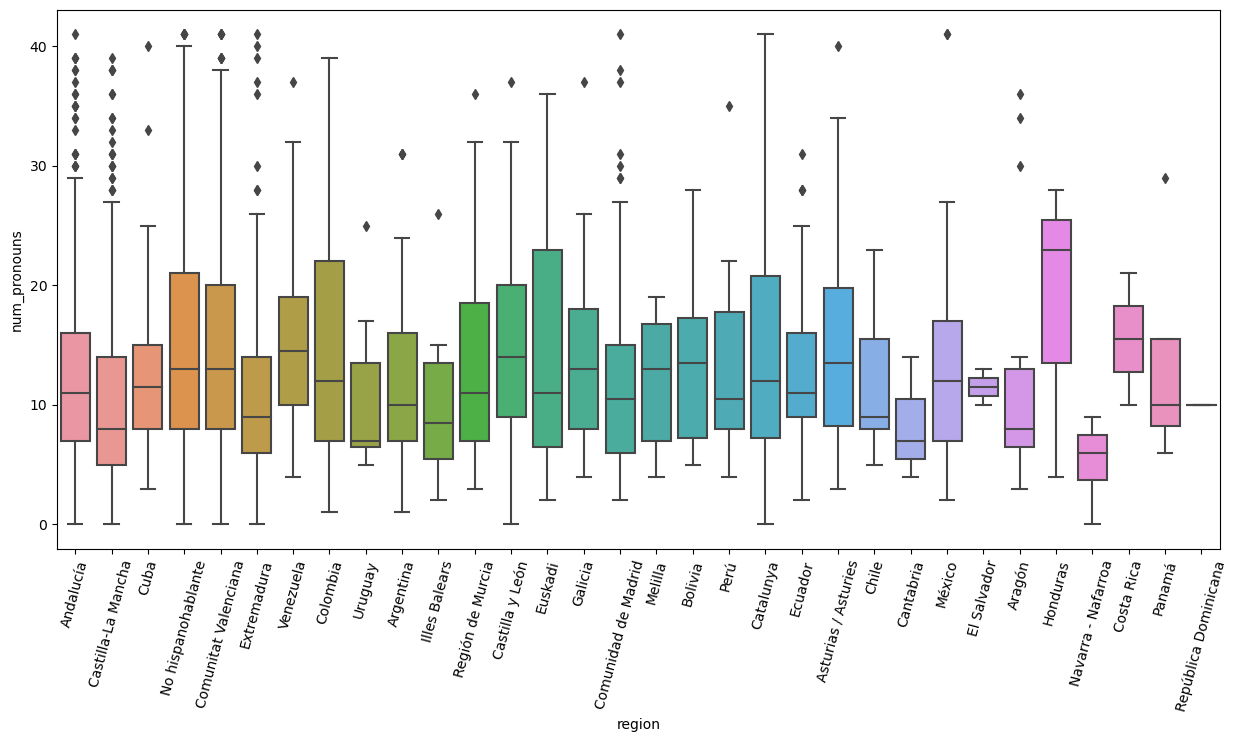

In [90]:
# remove outliers
data = df_syntactic.copy()
data = remove_outliers(data,column='num_pronouns',value=41)
# boxplot
box_plot('num_pronouns',data)
# statistics
statistics('num_pronouns',data)

### 9. Number of past tense verbs

In [191]:
# Mann-Whitney U test
data = df_syntactic.copy()
res = mann_whitney(data,'num_past')
print(res)

MannwhitneyuResult(statistic=1723252.0, pvalue=0.22856660911477533)


In [192]:
# Kruskal-Wallis test
kruskal_posthoc(df_syntactic,'num_past')


AGE: KruskalResult(statistic=16.821408349039896, pvalue=0.002093628924539364)
AGE:           18-24     25-34     35-44     45-54       +55
18-24  1.000000  0.086276  1.000000  0.419229  1.000000
25-34  0.086276  1.000000  0.419229  0.000815  0.031861
35-44  1.000000  0.419229  1.000000  0.227256  1.000000
45-54  0.419229  0.000815  0.227256  1.000000  1.000000
+55    1.000000  0.031861  1.000000  1.000000  1.000000
REGION: KruskalResult(statistic=45.2985253941747, pvalue=0.003652895948417353)
REGION:                          Comunidad de Madrid  Andalucía  Extremadura  \
Comunidad de Madrid                      1.0   1.000000          1.0   
Andalucía                                1.0   1.000000          1.0   
Extremadura                              1.0   1.000000          1.0   
Castilla y León                          1.0   1.000000          1.0   
Comunidad Valenciana                     1.0   0.865706          1.0   
Galicia                                  1.0   1.000000       

/var/folders/_x/cddkf2k97y19q18kzrrrxrzw0000gn/T/ipykernel_36317/2864299129.py:42: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  posthoc.set_axis(['18-24','25-34','35-44','45-54','+55'],axis=0,inplace=True)
/var/folders/_x/cddkf2k97y19q18kzrrrxrzw0000gn/T/ipykernel_36317/2864299129.py:43: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  posthoc.set_axis(['18-24','25-34','35-44','45-54','+55'],axis=1,inplace=True)
/var/folders/_x/cddkf2k97y19q18kzrrrxrzw0000gn/T/ipykernel_36317/2864299129.py:80: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  posthoc.set_axis(['Comunidad de Madrid','Andalucía','Extremadura','Castilla y León','Comunidad Valenciana','Galicia','

The d of Cohen for gender is: 0.07298924843027468
The f of Cohen for age is: 0.05313906278361942
The f of Cohen normalized for age is: 0.29957294803979106
The f of Cohen for demography is: 0.10263215134532094
The f of Cohen normalized for demography is: 0.06414509459082558


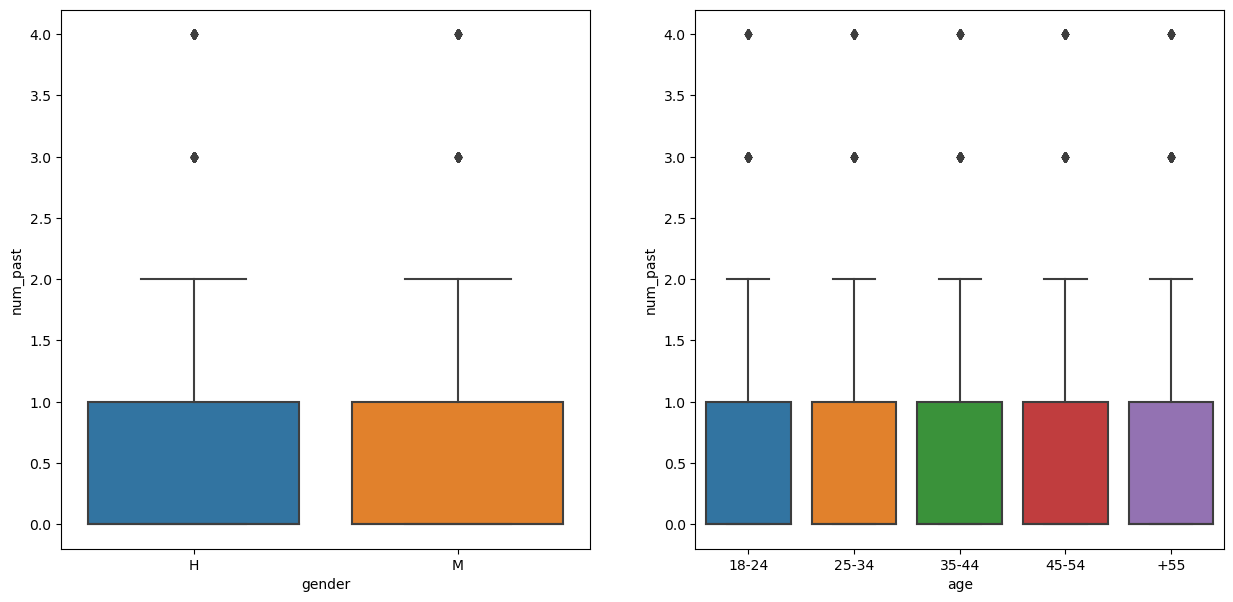

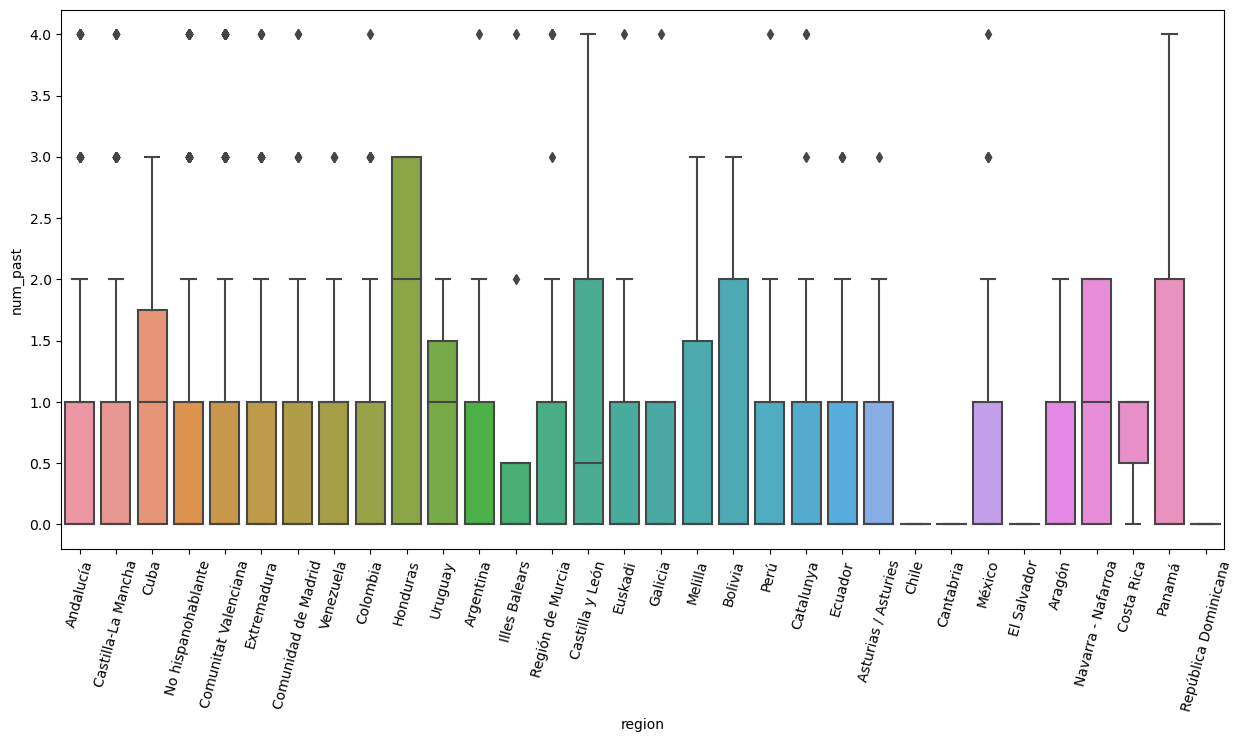

In [92]:
# remove outliers
data = df_syntactic.copy()
data = remove_outliers(data,column='num_past',value=4)
# boxplot
box_plot('num_past',data)
# statistics
statistics('num_past',data)

### 10. Number of future tense verbs

In [193]:
# Mann-Whitney U test
data = df_syntactic.copy()
res = mann_whitney(data,'num_future')
print(res)

MannwhitneyuResult(statistic=1687675.0, pvalue=0.21410685891004988)


In [194]:
# Kruskal-Wallis test
kruskal_posthoc(df_syntactic,'num_future')


AGE: KruskalResult(statistic=2.8223085264242185, pvalue=0.5879880332082127)
AGE:        18-24  25-34  35-44  45-54  +55
18-24    1.0    1.0    1.0    1.0  1.0
25-34    1.0    1.0    1.0    1.0  1.0
35-44    1.0    1.0    1.0    1.0  1.0
45-54    1.0    1.0    1.0    1.0  1.0
+55      1.0    1.0    1.0    1.0  1.0
REGION: KruskalResult(statistic=8.879935847557684, pvalue=0.9963463918554384)
REGION:                          Comunidad de Madrid  Andalucía  Extremadura  \
Comunidad de Madrid                      1.0        1.0          1.0   
Andalucía                                1.0        1.0          1.0   
Extremadura                              1.0        1.0          1.0   
Castilla y León                          1.0        1.0          1.0   
Comunidad Valenciana                     1.0        1.0          1.0   
Galicia                                  1.0        1.0          1.0   
Cataluña                                 1.0        1.0          1.0   
Plazas de Soberanía    

/var/folders/_x/cddkf2k97y19q18kzrrrxrzw0000gn/T/ipykernel_36317/2864299129.py:42: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  posthoc.set_axis(['18-24','25-34','35-44','45-54','+55'],axis=0,inplace=True)
/var/folders/_x/cddkf2k97y19q18kzrrrxrzw0000gn/T/ipykernel_36317/2864299129.py:43: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  posthoc.set_axis(['18-24','25-34','35-44','45-54','+55'],axis=1,inplace=True)
/var/folders/_x/cddkf2k97y19q18kzrrrxrzw0000gn/T/ipykernel_36317/2864299129.py:80: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  posthoc.set_axis(['Comunidad de Madrid','Andalucía','Extremadura','Castilla y León','Comunidad Valenciana','Galicia','

The d of Cohen for gender is: -0.03823692013256223
The f of Cohen for age is: 0.0008663715041173348
The f of Cohen normalized for age is: 0.4730388412480648
The f of Cohen for demography is: 0.0010990404407672948
The f of Cohen normalized for demography is: 0.45500274247766004


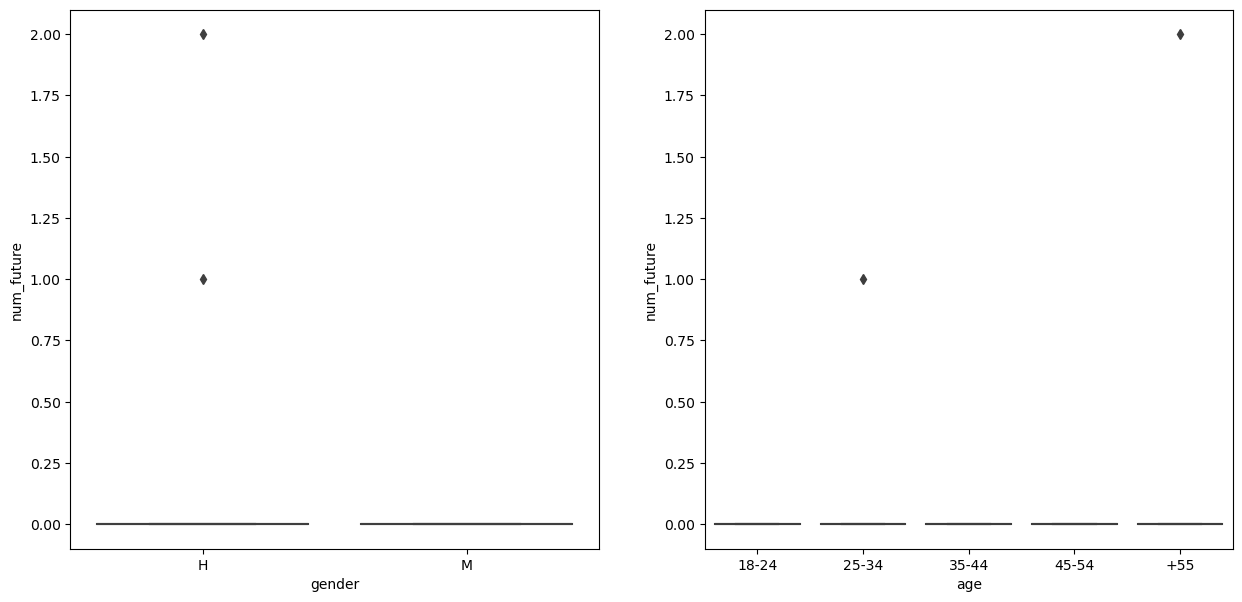

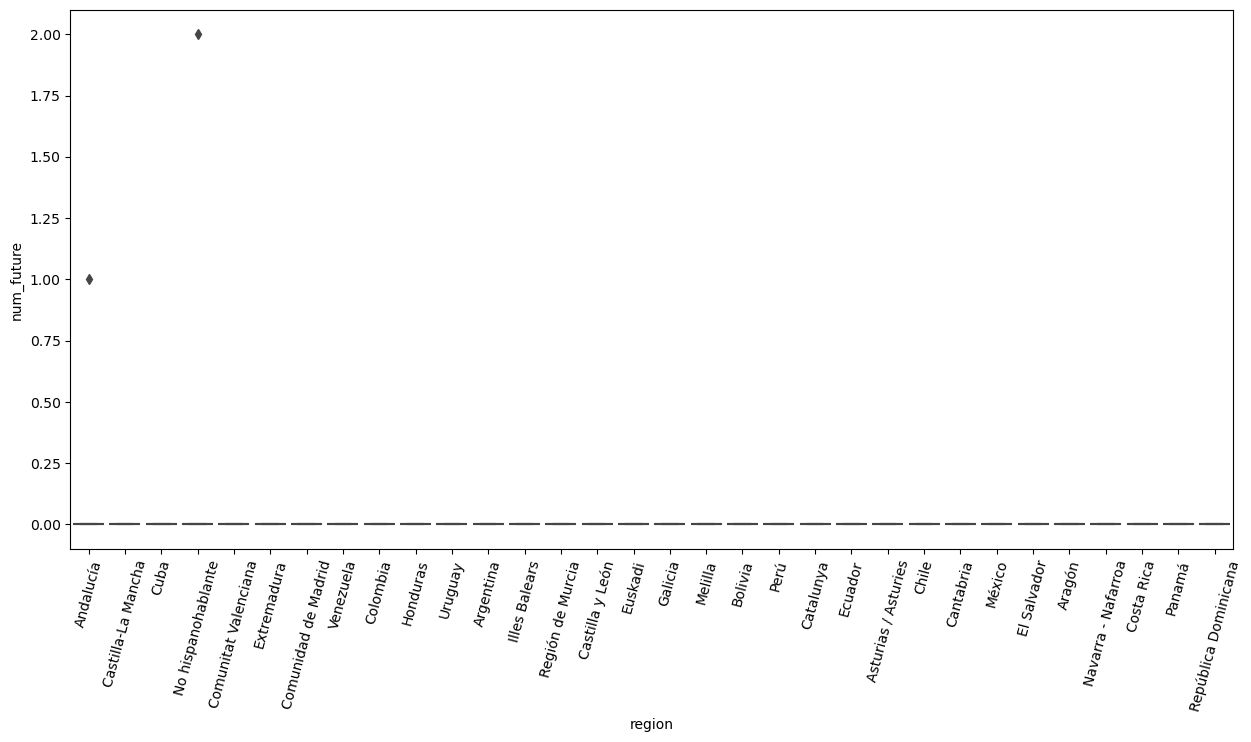

In [93]:
# remove outliers
data = df_syntactic.copy()
#data = remove_outliers(data,column='num_future',value=4)
# boxplot
box_plot('num_future',data)
# statistics
statistics('num_future',data)

### 11. Number of conjunctions

In [195]:
# Mann-Whitney U test
data = df_syntactic.copy()
res = mann_whitney(data,'num_conj')
print(res)

MannwhitneyuResult(statistic=1589397.5, pvalue=0.0019312948859109666)


In [196]:
# Kruskal-Wallis test
kruskal_posthoc(df_syntactic,'num_conj')


AGE: KruskalResult(statistic=20.386429050857483, pvalue=0.0004188880838639981)
AGE:           18-24     25-34     35-44     45-54       +55
18-24  1.000000  0.037124  0.011784  0.002065  1.000000
25-34  0.037124  1.000000  1.000000  1.000000  0.436106
35-44  0.011784  1.000000  1.000000  1.000000  0.250099
45-54  0.002065  1.000000  1.000000  1.000000  0.113295
+55    1.000000  0.436106  0.250099  0.113295  1.000000
REGION: KruskalResult(statistic=177.90573732074867, pvalue=6.497480045652265e-26)
REGION:                          Comunidad de Madrid     Andalucía  Extremadura  \
Comunidad de Madrid                 1.000000  1.000000e+00     1.000000   
Andalucía                           1.000000  1.000000e+00     0.007614   
Extremadura                         1.000000  7.614211e-03     1.000000   
Castilla y León                     1.000000  5.428245e-02     1.000000   
Comunidad Valenciana                0.943777  1.587455e-10     1.000000   
Galicia                             1.00

/var/folders/_x/cddkf2k97y19q18kzrrrxrzw0000gn/T/ipykernel_36317/2864299129.py:42: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  posthoc.set_axis(['18-24','25-34','35-44','45-54','+55'],axis=0,inplace=True)
/var/folders/_x/cddkf2k97y19q18kzrrrxrzw0000gn/T/ipykernel_36317/2864299129.py:43: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  posthoc.set_axis(['18-24','25-34','35-44','45-54','+55'],axis=1,inplace=True)
/var/folders/_x/cddkf2k97y19q18kzrrrxrzw0000gn/T/ipykernel_36317/2864299129.py:80: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  posthoc.set_axis(['Comunidad de Madrid','Andalucía','Extremadura','Castilla y León','Comunidad Valenciana','Galicia','

The d of Cohen for gender is: -0.09085718834564908
The f of Cohen for age is: 0.2762452437799723
The f of Cohen normalized for age is: 0.40417469124086497
The f of Cohen for demography is: 0.7946615873568413
The f of Cohen normalized for demography is: 0.1291814403092402


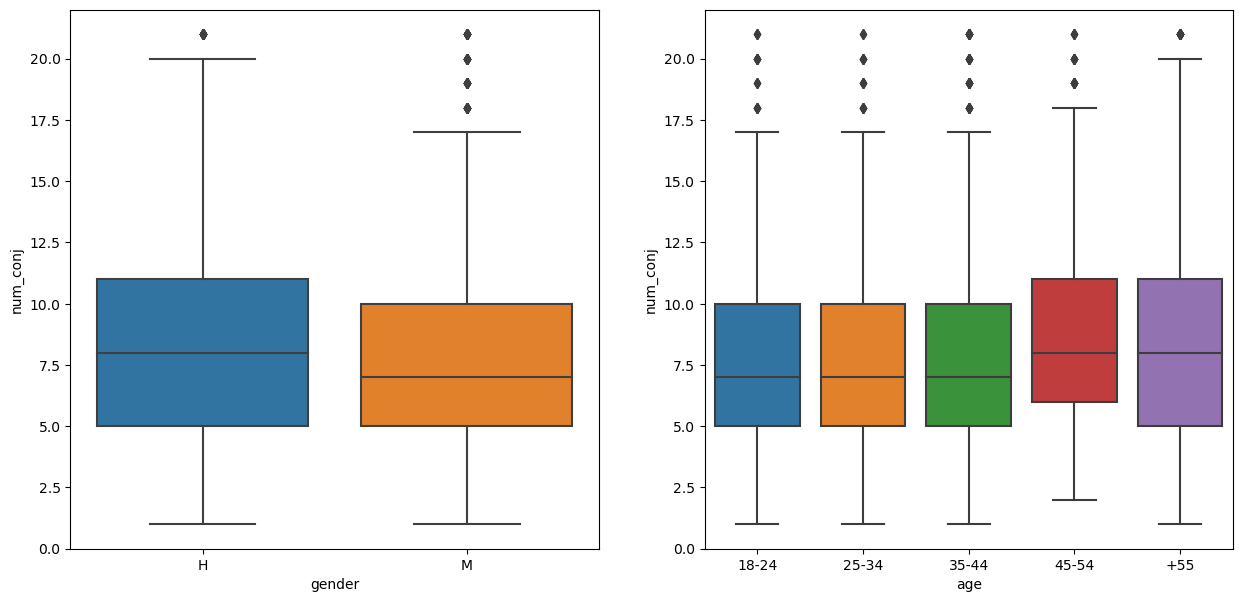

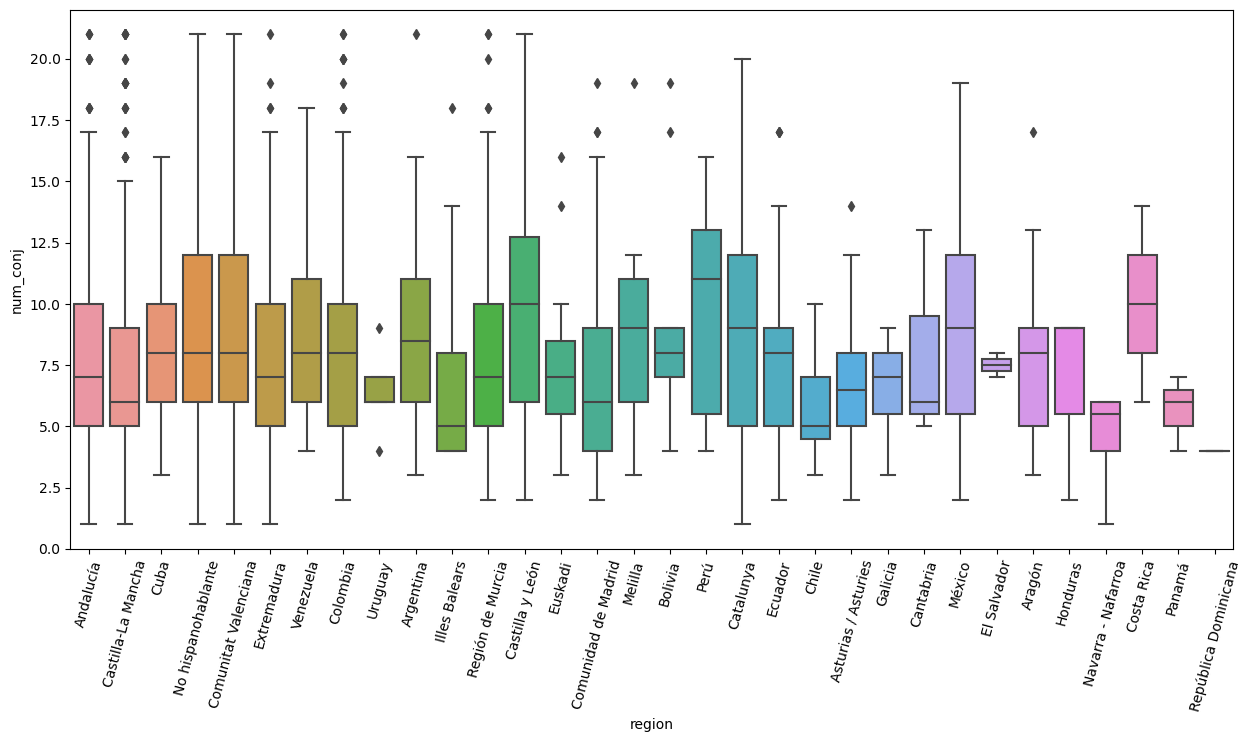

In [95]:
# remove outliers
data = df_syntactic.copy()
data = remove_outliers(data,column='num_conj',value=21)
# boxplot
box_plot('num_conj',data)
# statistics
statistics('num_conj',data)

In [197]:
# load data for character based features analysis
def df_syntactic_based_ratios():
    data = pd.DataFrame() 
    pos_tag = nltk.UnigramTagger(cess_esp.tagged_sents())

    tags_dict = {}
    ratio_det = []
    ratio_pre = []
    ratio_sing = []
    ratio_plural = []
    ratio_adv = []
    ratio_adj = []
    ratio_prop = []
    ratio_pronouns = []
    ratio_past = []
    ratio_future = []
    ratio_conj = []

    for file in files:
        with open(f'Atestados/{file}') as f:
            _dict = json.load(f)

            # denuncia
            text = _dict['denuncia']
            
            # clean text
            text = quitar_tags(text)
            text = quitar_guiones(text,file)
            cleaned_text = replace_multi_whitespaces(text)
            cleaned_text = cleaned_text.translate(str.maketrans('','',string.punctuation))
            cleaned_text = cleaned_text.replace('\n','')
            analysis = pos_tag.tag(cleaned_text.split(' '))

            num_words = len(analysis)

            det = 0
            pre = 0
            sing = 0
            plural = 0
            adv = 0
            adj = 0
            prop = 0
            pronouns = 0
            past = 0
            future = 0
            conj = 0

            for word,tag in analysis:
                if tag != None:
                    if tag[0] == 'd':
                        det += 1
                    elif tag[0] == 'a':
                        adj += 1
                    elif tag[0] == 'c':
                        conj += 1
                    elif tag[0] == 'p':
                        pronouns += 1
                    elif tag[0] == 'n':
                        if tag[1] == 'p':
                            prop += 1
                        if tag[3] == 's':
                            sing += 1
                        elif tag[3] == 'p':
                            plural += 1
                    elif tag[0] == 'r':
                        adv += 1
                    elif (tag[0] == 'v' and tag[3] == 'f'):
                        future += 1
                    elif (tag[0] == 'v' and tag[3] == 's'):
                        past += 1
                    elif tag[0] == 's':
                        pre += 1

            
            ratio_det.append(det/num_words)
            ratio_pre.append(pre/num_words)
            ratio_sing.append(sing/num_words)
            ratio_plural.append(plural/num_words)
            ratio_adv.append(adv/num_words)
            ratio_adj.append(adj/num_words)
            ratio_prop.append(prop/num_words)
            ratio_pronouns.append(pronouns/num_words)
            ratio_past.append(past/num_words)
            ratio_future.append(future/num_words)
            ratio_conj.append(conj/num_words)

    for k,v in tags_dict.items():
        data[k] = v
    
    data['ratio_det'] = ratio_det
    data['ratio_pre'] = ratio_pre
    data['ratio_sing'] = ratio_sing
    data['ratio_plural'] = ratio_plural
    data['ratio_adv'] = ratio_adv
    data['ratio_adj'] = ratio_adj
    data['ratio_prop'] = ratio_prop
    data['ratio_pronouns'] = ratio_pronouns
    data['ratio_past'] = ratio_past
    data['ratio_future'] = ratio_future
    data['ratio_conj'] = ratio_conj

    return pd.concat([denunciante_df,data],axis=1)

In [198]:
df_syntactic_ratios = df_syntactic_based_ratios()
df_syntactic_ratios.head()

gender    age                region  ratio_det  ratio_pre  ratio_sing  \
0      H  25-34             Andalucía   0.116279   0.232558    0.116279   
1      M    +55    Castilla-La Mancha   0.150000   0.187500    0.112500   
2      M  25-34               LATINOS   0.150000   0.175000    0.075000   
3      M    +55                  ASIA   0.080247   0.185185    0.089506   
4      M    +55  Comunidad Valenciana   0.139205   0.188920    0.110795   

   ratio_plural  ratio_adv  ratio_adj  ratio_prop  ratio_pronouns  ratio_past  \
0      0.000000   0.000000   0.069767    0.000000        0.069767    0.000000   
1      0.018750   0.031250   0.050000    0.000000        0.106250    0.000000   
2      0.025000   0.008333   0.050000    0.000000        0.083333    0.008333   
3      0.024691   0.000000   0.049383    0.003086        0.040123    0.003086   
4      0.019886   0.019886   0.048295    0.007102        0.071023    0.000000   

   ratio_future  ratio_conj  
0           0.0    0.046512  
1           0.0    0.056250  
2           0.0    0.091667  
3           0.0    0.064815  
4           0.0    0.063920

### 1. Ratio of determiners

In [199]:
# Mann-Whitney U test
data = df_syntactic_ratios.copy()
res = mann_whitney(data,'ratio_det')
print(res)

MannwhitneyuResult(statistic=1751178.0, pvalue=0.05544115221611272)


In [200]:
# Kruskal-Wallis test
kruskal_posthoc(df_syntactic_ratios,'ratio_det')


AGE: KruskalResult(statistic=3.806911629963714, pvalue=0.4327677248558449)
AGE:        18-24  25-34  35-44  45-54  +55
18-24    1.0    1.0    1.0    1.0  1.0
25-34    1.0    1.0    1.0    1.0  1.0
35-44    1.0    1.0    1.0    1.0  1.0
45-54    1.0    1.0    1.0    1.0  1.0
+55      1.0    1.0    1.0    1.0  1.0
REGION: KruskalResult(statistic=36.81826898838893, pvalue=0.033966502317350475)
REGION:                          Comunidad de Madrid  Andalucía  Extremadura  \
Comunidad de Madrid                      1.0   1.000000          1.0   
Andalucía                                1.0   1.000000          1.0   
Extremadura                              1.0   1.000000          1.0   
Castilla y León                          1.0   1.000000          1.0   
Comunidad Valenciana                     1.0   1.000000          1.0   
Galicia                                  1.0   1.000000          1.0   
Cataluña                                 1.0   1.000000          1.0   
Plazas de Soberanía   

/var/folders/_x/cddkf2k97y19q18kzrrrxrzw0000gn/T/ipykernel_36317/2864299129.py:42: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  posthoc.set_axis(['18-24','25-34','35-44','45-54','+55'],axis=0,inplace=True)
/var/folders/_x/cddkf2k97y19q18kzrrrxrzw0000gn/T/ipykernel_36317/2864299129.py:43: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  posthoc.set_axis(['18-24','25-34','35-44','45-54','+55'],axis=1,inplace=True)
/var/folders/_x/cddkf2k97y19q18kzrrrxrzw0000gn/T/ipykernel_36317/2864299129.py:80: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  posthoc.set_axis(['Comunidad de Madrid','Andalucía','Extremadura','Castilla y León','Comunidad Valenciana','Galicia','

The d of Cohen for gender is: 0.07779559990545065
The f of Cohen for age is: 0.0008954056078276588
The f of Cohen normalized for age is: 0.34949823030453325
The f of Cohen for demography is: 0.002448294175658078
The f of Cohen normalized for demography is: 0.06749064931588043


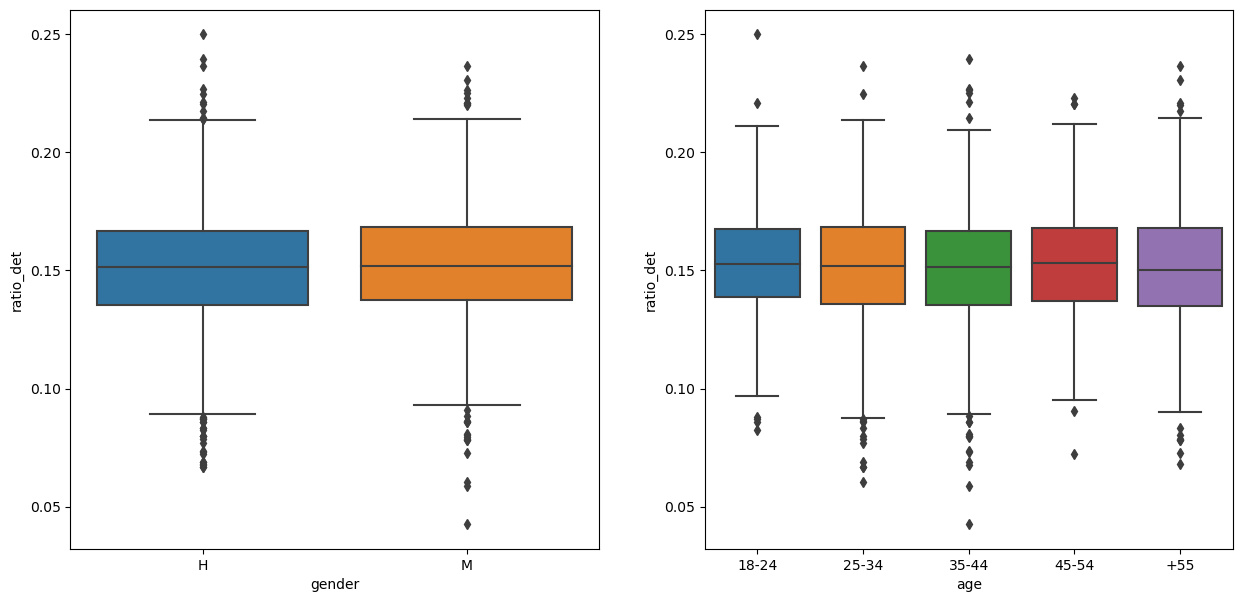

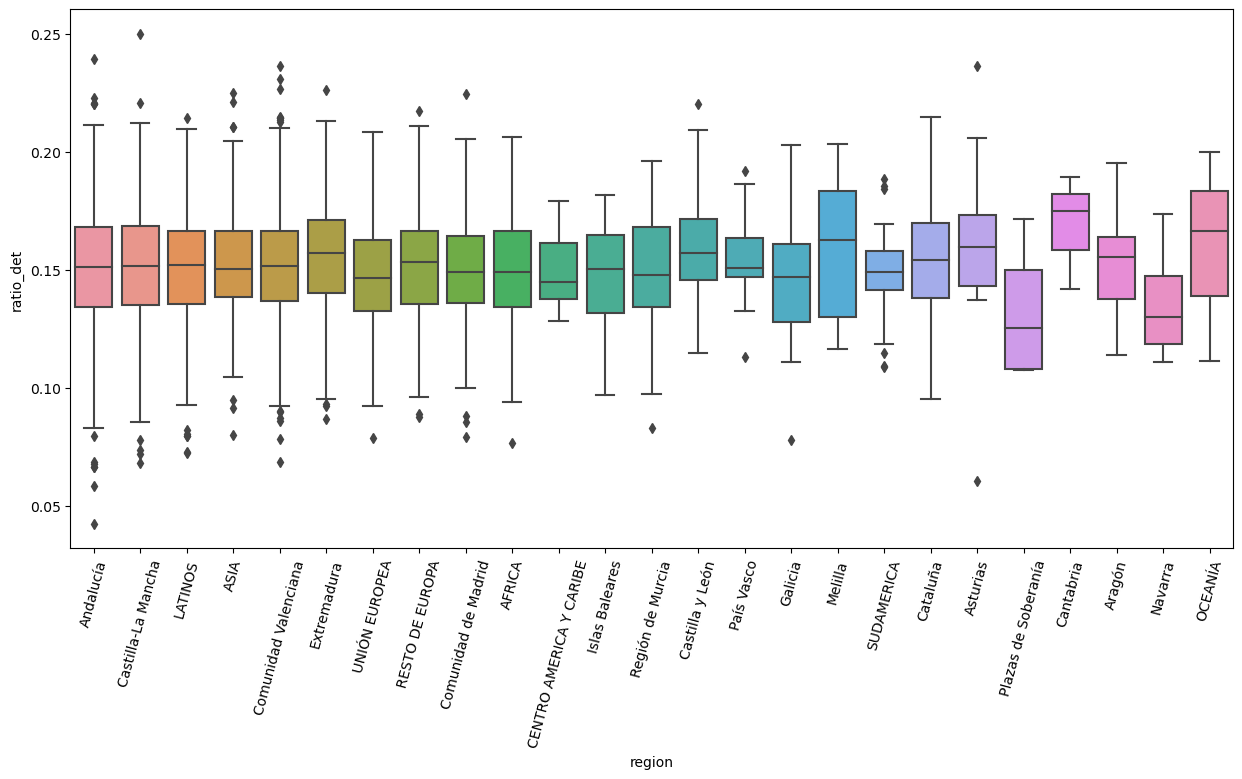

In [201]:
# remove outliers
data = df_syntactic_ratios.copy()
#data = remove_outliers(data,column='ratio_det',value=60)
# boxplot
box_plot('ratio_det',data)
# statistics
statistics('ratio_det',data)

### 2. Ratio of prepositions

In [202]:
# Mann-Whitney U test
data = df_syntactic_ratios.copy()
res = mann_whitney(data,'ratio_pre')
print(res)

MannwhitneyuResult(statistic=1599869.5, pvalue=0.005648500721738929)


In [203]:
# Kruskal-Wallis test
kruskal_posthoc(df_syntactic_ratios,'ratio_pre')


AGE: KruskalResult(statistic=16.64407877920951, pvalue=0.002266183893721429)
AGE:           18-24     25-34     35-44     45-54       +55
18-24  1.000000  0.703012  0.703012  0.017436  0.703012
25-34  0.703012  1.000000  0.190644  0.002809  0.218469
35-44  0.703012  0.190644  1.000000  0.703012  0.834836
45-54  0.017436  0.002809  0.703012  1.000000  0.703012
+55    0.703012  0.218469  0.834836  0.703012  1.000000
REGION: KruskalResult(statistic=21.415930242393625, pvalue=0.5557032251781837)
REGION:                          Comunidad de Madrid  Andalucía  Extremadura  \
Comunidad de Madrid                      1.0   1.000000     1.000000   
Andalucía                                1.0   1.000000     0.051745   
Extremadura                              1.0   0.051745     1.000000   
Castilla y León                          1.0   1.000000     1.000000   
Comunidad Valenciana                     1.0   1.000000     1.000000   
Galicia                                  1.0   1.000000     1.0

/var/folders/_x/cddkf2k97y19q18kzrrrxrzw0000gn/T/ipykernel_36317/2864299129.py:42: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  posthoc.set_axis(['18-24','25-34','35-44','45-54','+55'],axis=0,inplace=True)
/var/folders/_x/cddkf2k97y19q18kzrrrxrzw0000gn/T/ipykernel_36317/2864299129.py:43: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  posthoc.set_axis(['18-24','25-34','35-44','45-54','+55'],axis=1,inplace=True)
/var/folders/_x/cddkf2k97y19q18kzrrrxrzw0000gn/T/ipykernel_36317/2864299129.py:80: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  posthoc.set_axis(['Comunidad de Madrid','Andalucía','Extremadura','Castilla y León','Comunidad Valenciana','Galicia','

The d of Cohen for gender is: -0.11867883161224496
The f of Cohen for age is: 0.0016731092317670776
The f of Cohen normalized for age is: 0.32435027053070015
The f of Cohen for demography is: 0.002150306490942146
The f of Cohen normalized for demography is: 0.11630472364267197


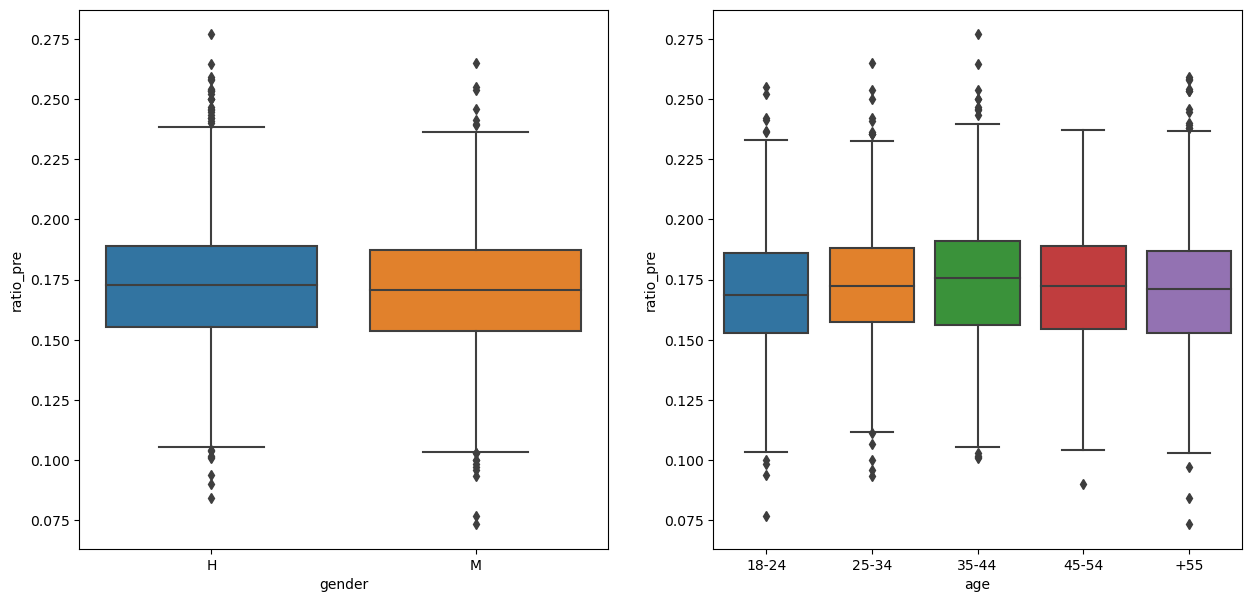

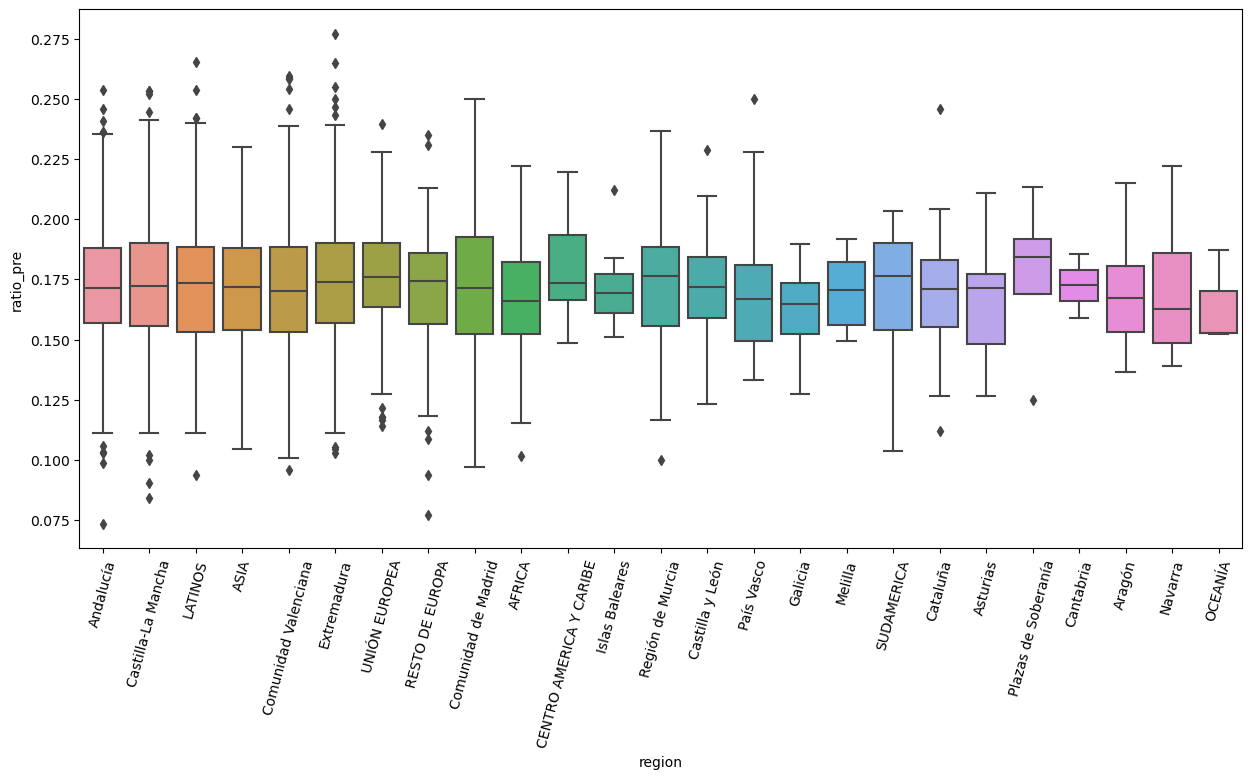

In [204]:
# remove outliers
data = df_syntactic_ratios.copy()
#data = remove_outliers(data,column='ratio_pre',value=70)
# boxplot
box_plot('ratio_pre',data)
# statistics
statistics('ratio_pre',data)

### 3. Ratio of singular nouns

In [205]:
# Mann-Whitney U test
data = df_syntactic_ratios.copy()
res = mann_whitney(data,'ratio_sing')
print(res)

MannwhitneyuResult(statistic=1786279.0, pvalue=0.002684252391268498)


In [206]:
# Kruskal-Wallis test
kruskal_posthoc(df_syntactic_ratios,'ratio_sing')


AGE: KruskalResult(statistic=3.163031541370202, pvalue=0.5309225972535989)
AGE:        18-24  25-34  35-44  45-54  +55
18-24    1.0    1.0    1.0    1.0  1.0
25-34    1.0    1.0    1.0    1.0  1.0
35-44    1.0    1.0    1.0    1.0  1.0
45-54    1.0    1.0    1.0    1.0  1.0
+55      1.0    1.0    1.0    1.0  1.0
REGION: KruskalResult(statistic=80.70707809759558, pvalue=2.4384233264558644e-08)
REGION:                          Comunidad de Madrid  Andalucía  Extremadura  \
Comunidad de Madrid                      1.0   1.000000     1.000000   
Andalucía                                1.0   1.000000     1.000000   
Extremadura                              1.0   1.000000     1.000000   
Castilla y León                          1.0   1.000000     1.000000   
Comunidad Valenciana                     1.0   0.001696     0.059047   
Galicia                                  1.0   1.000000     1.000000   
Cataluña                                 1.0   1.000000     1.000000   
Plazas de Soberanía 

/var/folders/_x/cddkf2k97y19q18kzrrrxrzw0000gn/T/ipykernel_36317/2864299129.py:42: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  posthoc.set_axis(['18-24','25-34','35-44','45-54','+55'],axis=0,inplace=True)
/var/folders/_x/cddkf2k97y19q18kzrrrxrzw0000gn/T/ipykernel_36317/2864299129.py:43: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  posthoc.set_axis(['18-24','25-34','35-44','45-54','+55'],axis=1,inplace=True)
/var/folders/_x/cddkf2k97y19q18kzrrrxrzw0000gn/T/ipykernel_36317/2864299129.py:80: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  posthoc.set_axis(['Comunidad de Madrid','Andalucía','Extremadura','Castilla y León','Comunidad Valenciana','Galicia','

The d of Cohen for gender is: 0.09697386626674227
The f of Cohen for age is: 0.0006055908679057153
The f of Cohen normalized for age is: 0.3957069983857964
The f of Cohen for demography is: 0.0036947016388213664
The f of Cohen normalized for demography is: 0.07502745371568166


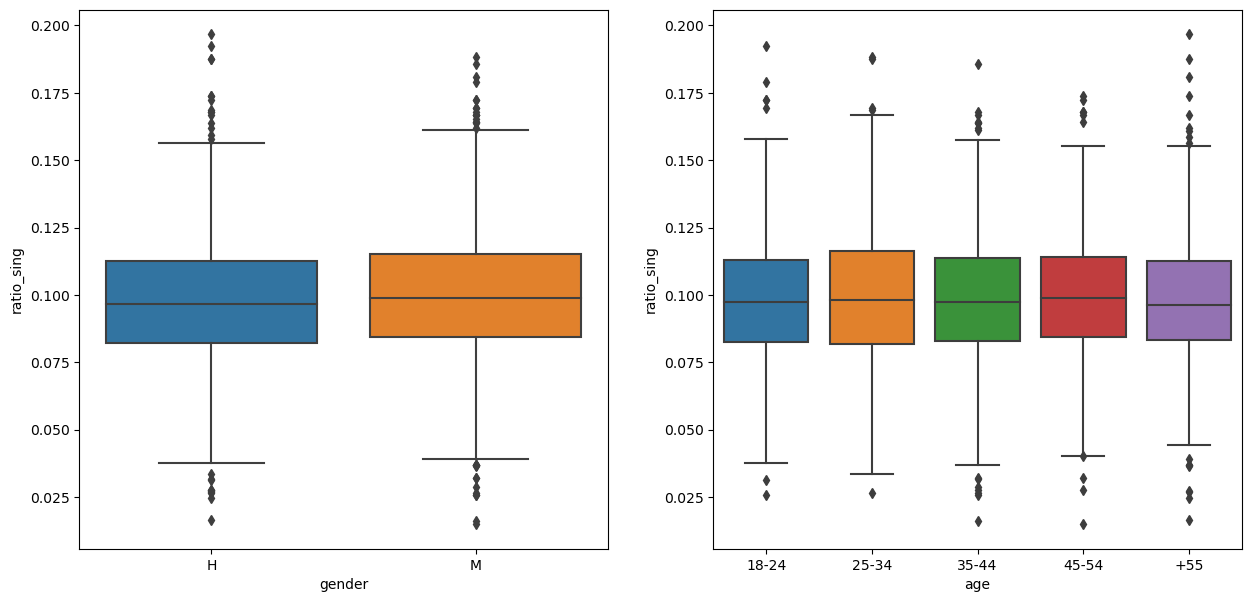

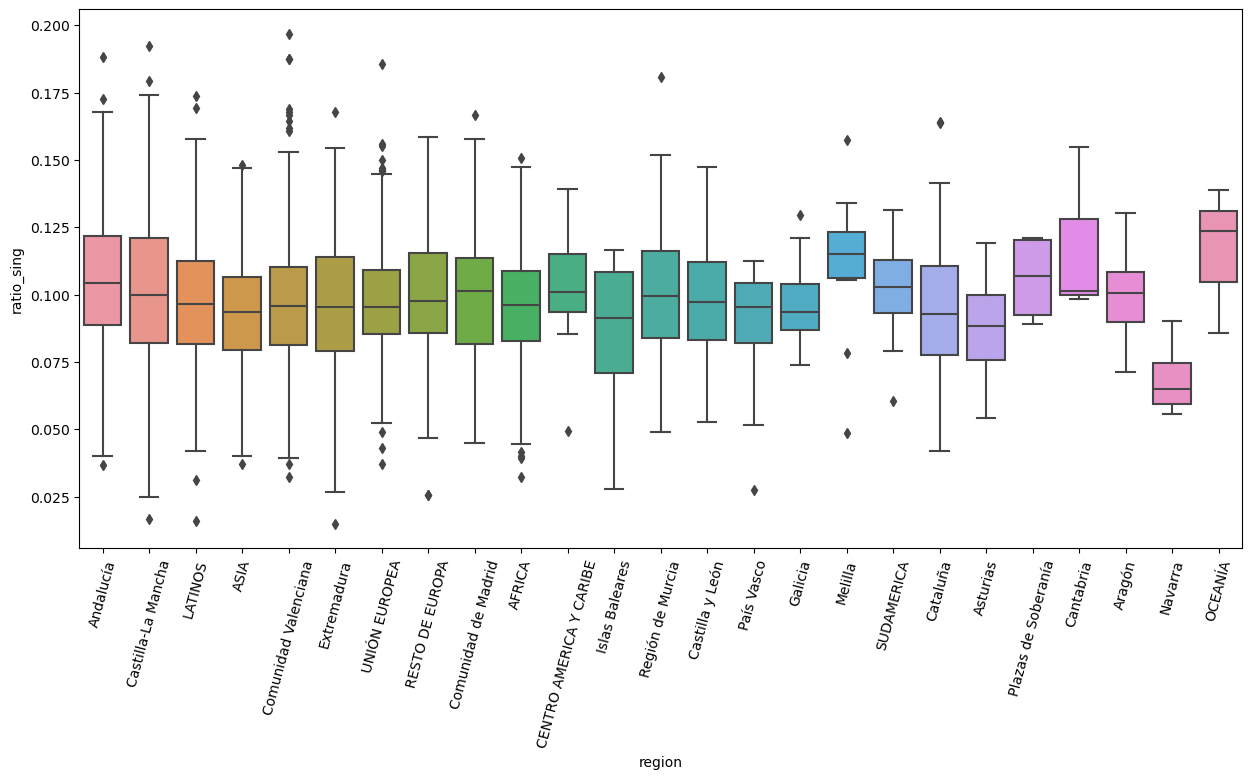

In [207]:
# remove outliers
data = df_syntactic_ratios.copy()
#data = remove_outliers(data,column='num_sing',value=40)
# boxplot
box_plot('ratio_sing',data)
# statistics
statistics('ratio_sing',data)

### 4. Ratio of plural nouns

In [208]:
# Mann-Whitney U test
data = df_syntactic_ratios.copy()
res = mann_whitney(data,'ratio_plural')
print(res)

MannwhitneyuResult(statistic=1677610.0, pvalue=0.7177420045911933)


In [209]:
# Kruskal-Wallis test
kruskal_posthoc(df_syntactic_ratios,'ratio_plural')


AGE: KruskalResult(statistic=14.402575895081972, pvalue=0.006115084210317106)
AGE:           18-24     25-34     35-44     45-54       +55
18-24  1.000000  1.000000  0.558993  0.013960  0.081389
25-34  1.000000  1.000000  1.000000  0.108686  0.335764
35-44  0.558993  1.000000  1.000000  1.000000  1.000000
45-54  0.013960  0.108686  1.000000  1.000000  1.000000
+55    0.081389  0.335764  1.000000  1.000000  1.000000
REGION: KruskalResult(statistic=22.8219660723018, pvalue=0.47120664344724705)
REGION:                          Comunidad de Madrid  Andalucía  Extremadura  \
Comunidad de Madrid                      1.0        1.0          1.0   
Andalucía                                1.0        1.0          1.0   
Extremadura                              1.0        1.0          1.0   
Castilla y León                          1.0        1.0          1.0   
Comunidad Valenciana                     1.0        1.0          1.0   
Galicia                                  1.0        1.0        

/var/folders/_x/cddkf2k97y19q18kzrrrxrzw0000gn/T/ipykernel_36317/2864299129.py:42: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  posthoc.set_axis(['18-24','25-34','35-44','45-54','+55'],axis=0,inplace=True)
/var/folders/_x/cddkf2k97y19q18kzrrrxrzw0000gn/T/ipykernel_36317/2864299129.py:43: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  posthoc.set_axis(['18-24','25-34','35-44','45-54','+55'],axis=1,inplace=True)
/var/folders/_x/cddkf2k97y19q18kzrrrxrzw0000gn/T/ipykernel_36317/2864299129.py:80: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  posthoc.set_axis(['Comunidad de Madrid','Andalucía','Extremadura','Castilla y León','Comunidad Valenciana','Galicia','

The d of Cohen for gender is: -0.014793932930600688
The f of Cohen for age is: 0.0008133334596818641
The f of Cohen normalized for age is: 0.3832437588167801
The f of Cohen for demography is: 0.0011635473441556925
The f of Cohen normalized for demography is: 0.05169304075037153


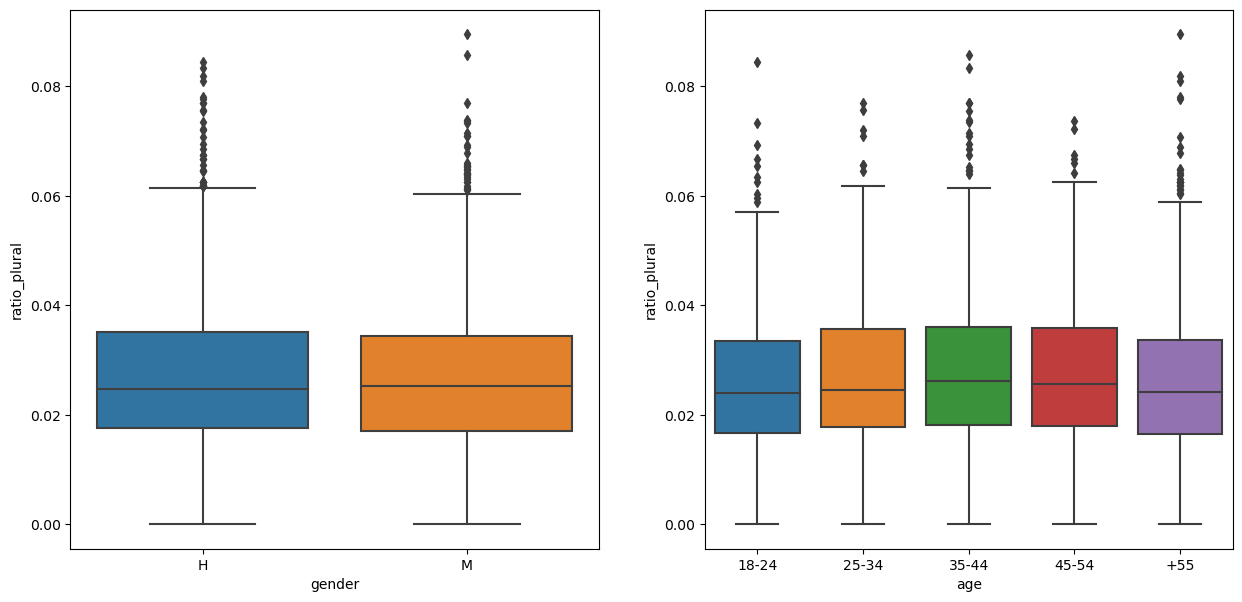

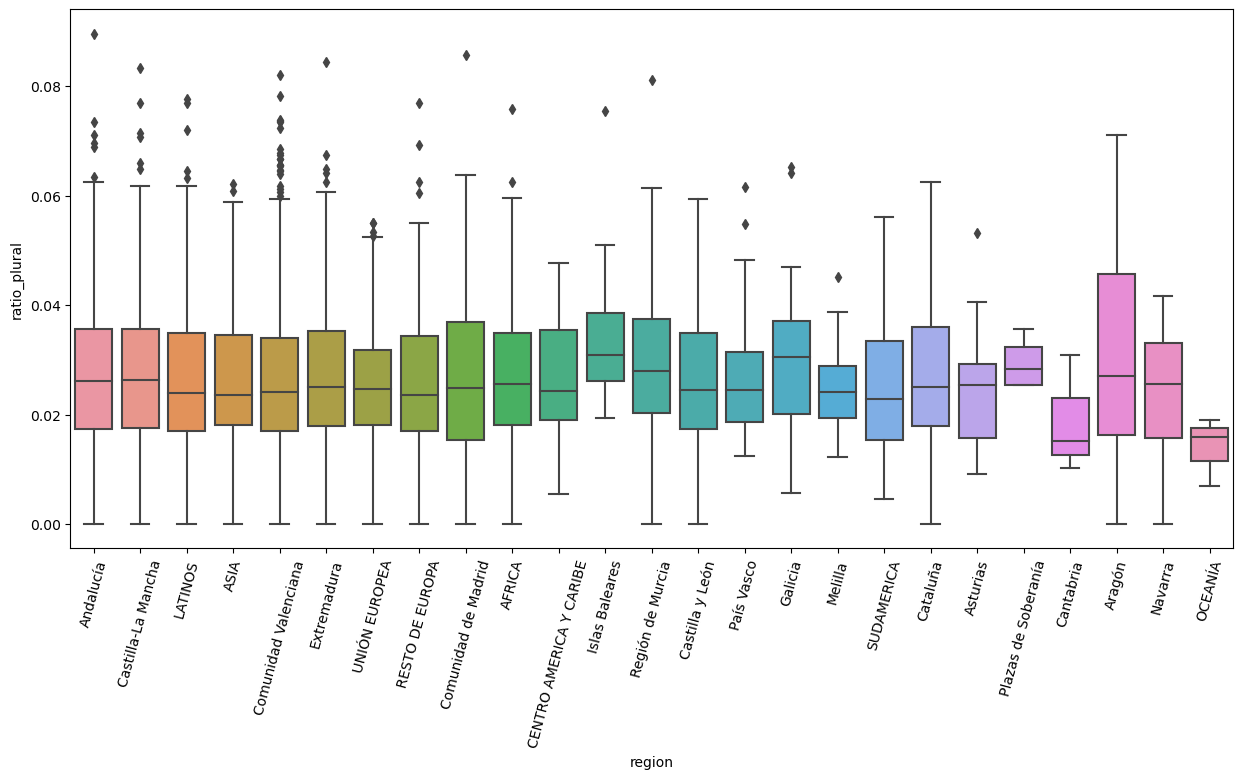

In [210]:
# remove outliers
data = df_syntactic_ratios.copy()
#data = remove_outliers(data,column='num_plural',value=12)
# boxplot
box_plot('ratio_plural',data)
# statistics
statistics('ratio_plural',data)

### 5. Ratio of adverbs

In [211]:
# Mann-Whitney U test
data = df_syntactic_ratios.copy()
res = mann_whitney(data,'ratio_adv')
print(res)

MannwhitneyuResult(statistic=1822156.0, pvalue=3.873921105211774e-05)


In [212]:
# Kruskal-Wallis test
kruskal_posthoc(df_syntactic_ratios,'ratio_adv')


AGE: KruskalResult(statistic=8.47419532297758, pvalue=0.07567327660279563)
AGE:           18-24     25-34  35-44     45-54       +55
18-24  1.000000  1.000000    1.0  0.671221  0.278909
25-34  1.000000  1.000000    1.0  0.426423  0.185610
35-44  1.000000  1.000000    1.0  1.000000  1.000000
45-54  0.671221  0.426423    1.0  1.000000  1.000000
+55    0.278909  0.185610    1.0  1.000000  1.000000
REGION: KruskalResult(statistic=83.94129161623704, pvalue=7.220746969337573e-09)
REGION:                          Comunidad de Madrid  Andalucía  Extremadura  \
Comunidad de Madrid                 1.000000        1.0     1.000000   
Andalucía                           1.000000        1.0     1.000000   
Extremadura                         1.000000        1.0     1.000000   
Castilla y León                     1.000000        1.0     1.000000   
Comunidad Valenciana                0.001002        1.0     0.001735   
Galicia                             1.000000        1.0     1.000000   
Cataluña 

/var/folders/_x/cddkf2k97y19q18kzrrrxrzw0000gn/T/ipykernel_36317/2864299129.py:42: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  posthoc.set_axis(['18-24','25-34','35-44','45-54','+55'],axis=0,inplace=True)
/var/folders/_x/cddkf2k97y19q18kzrrrxrzw0000gn/T/ipykernel_36317/2864299129.py:43: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  posthoc.set_axis(['18-24','25-34','35-44','45-54','+55'],axis=1,inplace=True)
/var/folders/_x/cddkf2k97y19q18kzrrrxrzw0000gn/T/ipykernel_36317/2864299129.py:80: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  posthoc.set_axis(['Comunidad de Madrid','Andalucía','Extremadura','Castilla y León','Comunidad Valenciana','Galicia','

The d of Cohen for gender is: 0.13177053635221733
The f of Cohen for age is: 0.0006305959289269117
The f of Cohen normalized for age is: 0.3128440691064126
The f of Cohen for demography is: 0.0020742155265752733
The f of Cohen normalized for demography is: 0.09172409933654767


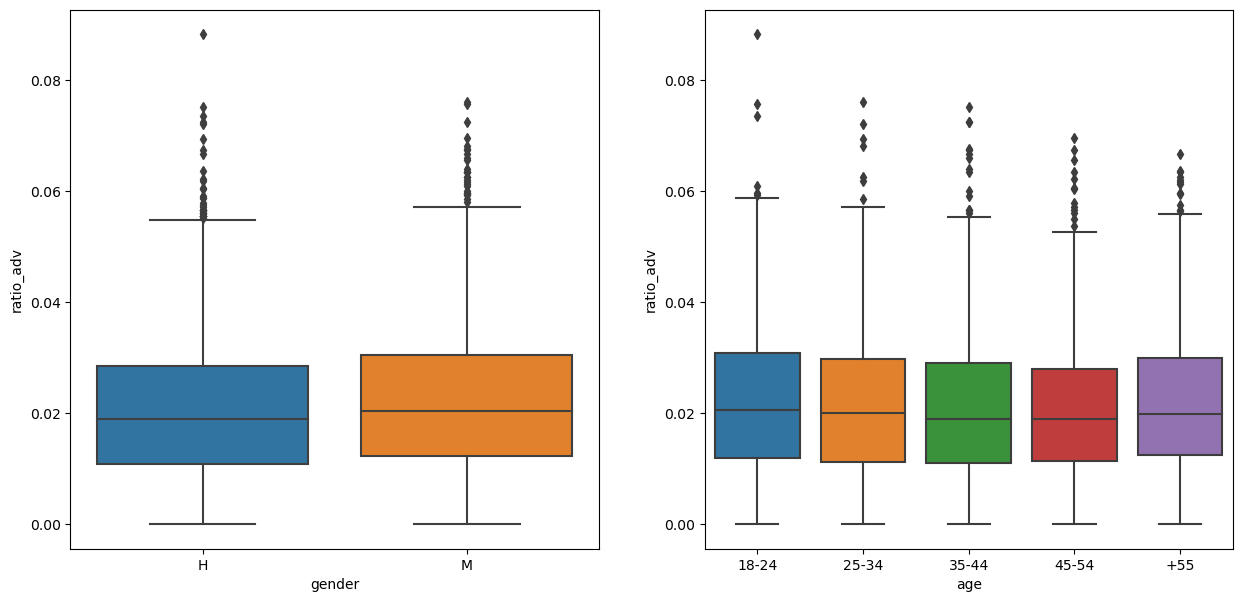

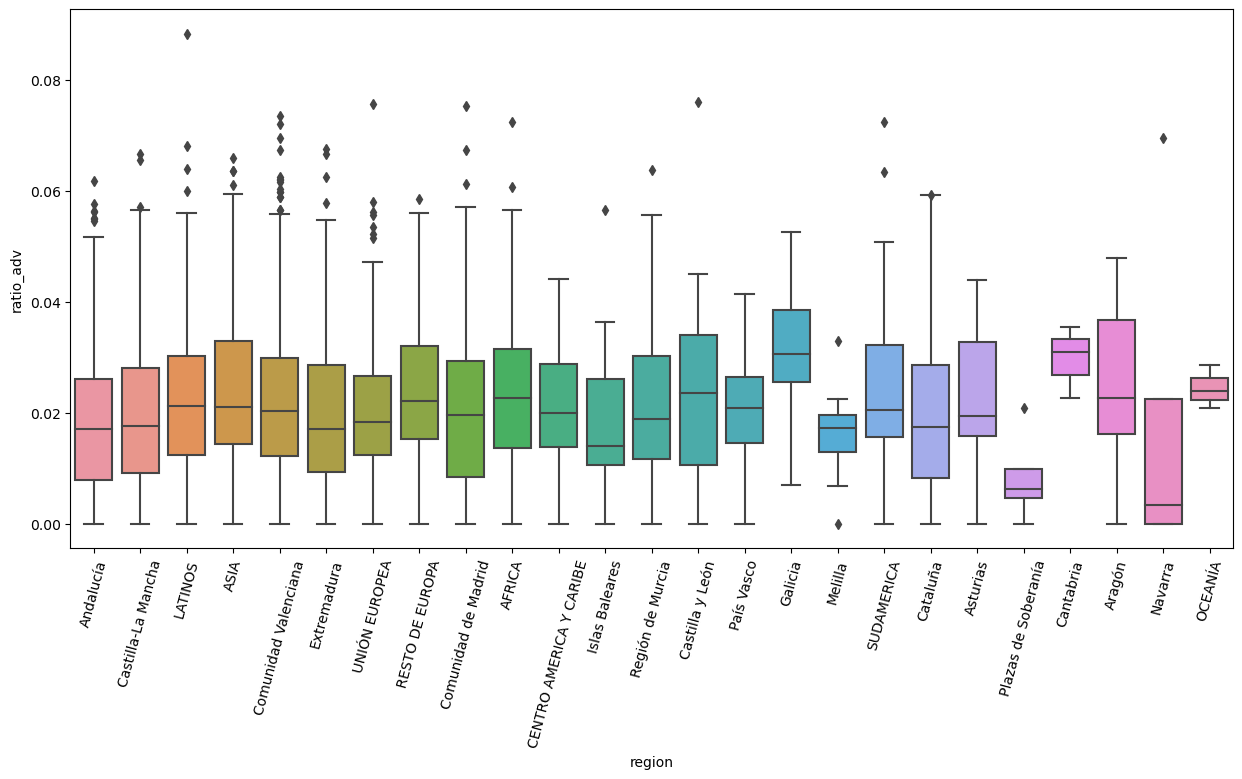

In [213]:
# remove outliers
data = df_syntactic_ratios.copy()
#data = remove_outliers(data,column='num_adv',value=12)
# boxplot
box_plot('ratio_adv',data)
# statistics
statistics('ratio_adv',data)

### 6. Ratio of adjetives

In [214]:
# Mann-Whitney U test
data = df_syntactic_ratios.copy()
res = mann_whitney(data,'ratio_adj')
print(res)

MannwhitneyuResult(statistic=1665403.5, pvalue=0.45974713787735366)


In [215]:
# Kruskal-Wallis test
kruskal_posthoc(df_syntactic_ratios,'ratio_adj')


AGE: KruskalResult(statistic=1.4603940579592904, pvalue=0.8336332368045452)
AGE:        18-24  25-34  35-44  45-54  +55
18-24    1.0    1.0    1.0    1.0  1.0
25-34    1.0    1.0    1.0    1.0  1.0
35-44    1.0    1.0    1.0    1.0  1.0
45-54    1.0    1.0    1.0    1.0  1.0
+55      1.0    1.0    1.0    1.0  1.0
REGION: KruskalResult(statistic=26.24095238391775, pvalue=0.28962363543387426)
REGION:                          Comunidad de Madrid  Andalucía  Extremadura  \
Comunidad de Madrid                      1.0        1.0     1.000000   
Andalucía                                1.0        1.0     1.000000   
Extremadura                              1.0        1.0     1.000000   
Castilla y León                          1.0        1.0     1.000000   
Comunidad Valenciana                     1.0        1.0     1.000000   
Galicia                                  1.0        1.0     1.000000   
Cataluña                                 1.0        1.0     1.000000   
Plazas de Soberanía   

/var/folders/_x/cddkf2k97y19q18kzrrrxrzw0000gn/T/ipykernel_36317/2864299129.py:42: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  posthoc.set_axis(['18-24','25-34','35-44','45-54','+55'],axis=0,inplace=True)
/var/folders/_x/cddkf2k97y19q18kzrrrxrzw0000gn/T/ipykernel_36317/2864299129.py:43: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  posthoc.set_axis(['18-24','25-34','35-44','45-54','+55'],axis=1,inplace=True)
/var/folders/_x/cddkf2k97y19q18kzrrrxrzw0000gn/T/ipykernel_36317/2864299129.py:80: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  posthoc.set_axis(['Comunidad de Madrid','Andalucía','Extremadura','Castilla y León','Comunidad Valenciana','Galicia','

The d of Cohen for gender is: -0.04154520980202669
The f of Cohen for age is: 0.0004175556728358366
The f of Cohen normalized for age is: 0.3602863148559849
The f of Cohen for demography is: 0.001984516422599923
The f of Cohen normalized for demography is: 0.08724812699055555


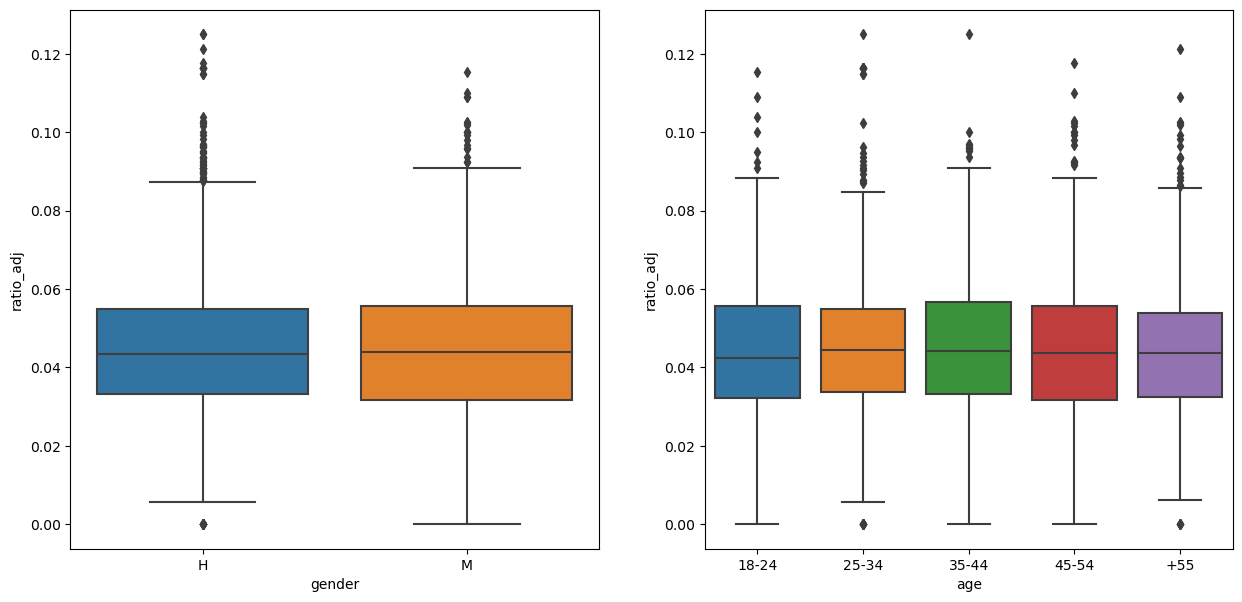

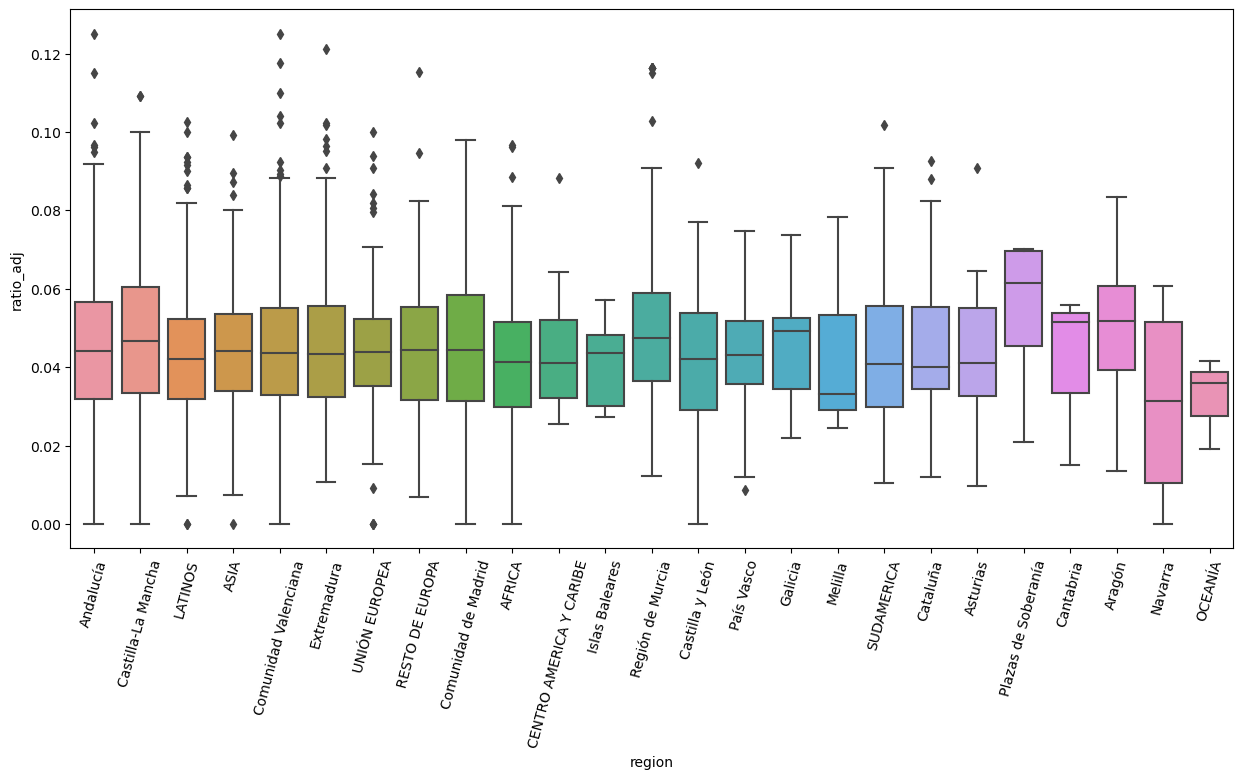

In [216]:
# remove outliers
data = df_syntactic_ratios.copy()
#data = remove_outliers(data,column='num_adj',value=18)
# boxplot
box_plot('ratio_adj',data)
# statistics
statistics('ratio_adj',data)

### 7. Ratio of proper nouns

In [217]:
# Mann-Whitney U test
data = df_syntactic_ratios.copy()
res = mann_whitney(data,'ratio_prop')
print(res)

MannwhitneyuResult(statistic=1601197.5, pvalue=0.0001708522805947207)


In [218]:
# Kruskal-Wallis test
kruskal_posthoc(df_syntactic_ratios,'ratio_prop')


AGE: KruskalResult(statistic=28.144582201877977, pvalue=1.1658989212440472e-05)
AGE:           18-24     25-34     35-44     45-54       +55
18-24  1.000000  0.000036  0.000829  0.106764  0.413258
25-34  0.000036  1.000000  0.932313  0.137733  0.028616
35-44  0.000829  0.932313  1.000000  0.413258  0.139604
45-54  0.106764  0.137733  0.413258  1.000000  0.932313
+55    0.413258  0.028616  0.139604  0.932313  1.000000
REGION: KruskalResult(statistic=89.36586451555742, pvalue=9.080724429185152e-10)
REGION:                          Comunidad de Madrid     Andalucía  Extremadura  \
Comunidad de Madrid                 1.000000  7.692062e-05     1.000000   
Andalucía                           0.000077  1.000000e+00     0.000008   
Extremadura                         1.000000  7.573757e-06     1.000000   
Castilla y León                     1.000000  7.731223e-02     1.000000   
Comunidad Valenciana                1.000000  2.430552e-08     1.000000   
Galicia                             1.00

/var/folders/_x/cddkf2k97y19q18kzrrrxrzw0000gn/T/ipykernel_36317/2864299129.py:42: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  posthoc.set_axis(['18-24','25-34','35-44','45-54','+55'],axis=0,inplace=True)
/var/folders/_x/cddkf2k97y19q18kzrrrxrzw0000gn/T/ipykernel_36317/2864299129.py:43: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  posthoc.set_axis(['18-24','25-34','35-44','45-54','+55'],axis=1,inplace=True)
/var/folders/_x/cddkf2k97y19q18kzrrrxrzw0000gn/T/ipykernel_36317/2864299129.py:80: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  posthoc.set_axis(['Comunidad de Madrid','Andalucía','Extremadura','Castilla y León','Comunidad Valenciana','Galicia','

The d of Cohen for gender is: -0.09022519207312872
The f of Cohen for age is: 0.0003883435966928736
The f of Cohen normalized for age is: 0.38477342347943594
The f of Cohen for demography is: 0.0007166505845590299
The f of Cohen normalized for demography is: 0.17242326034543404


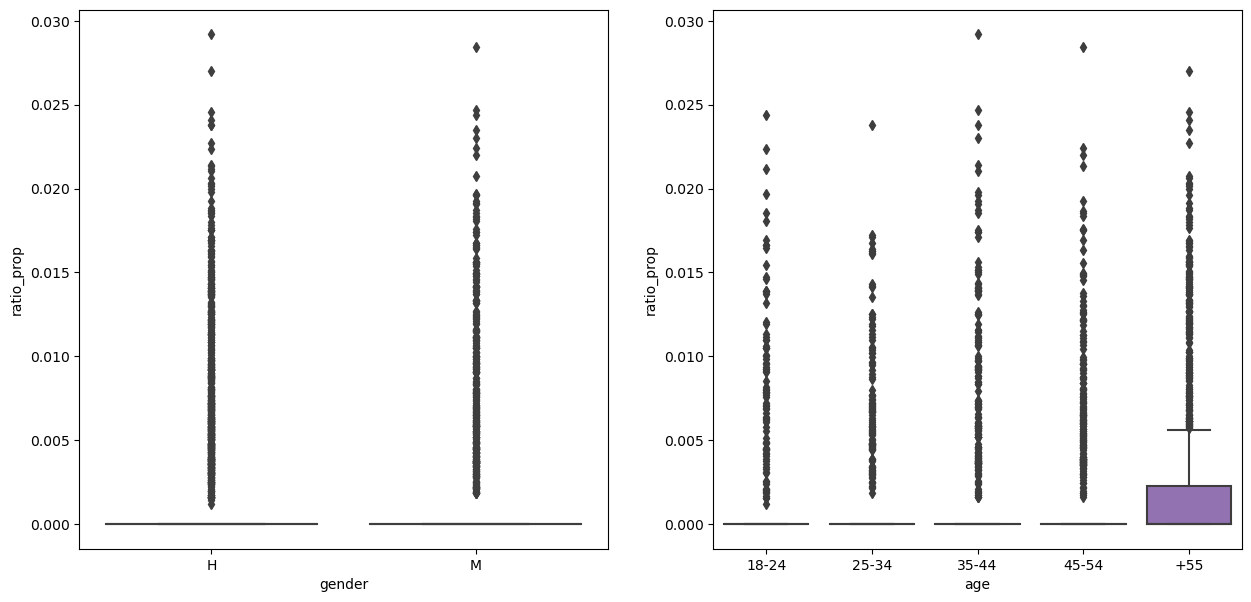

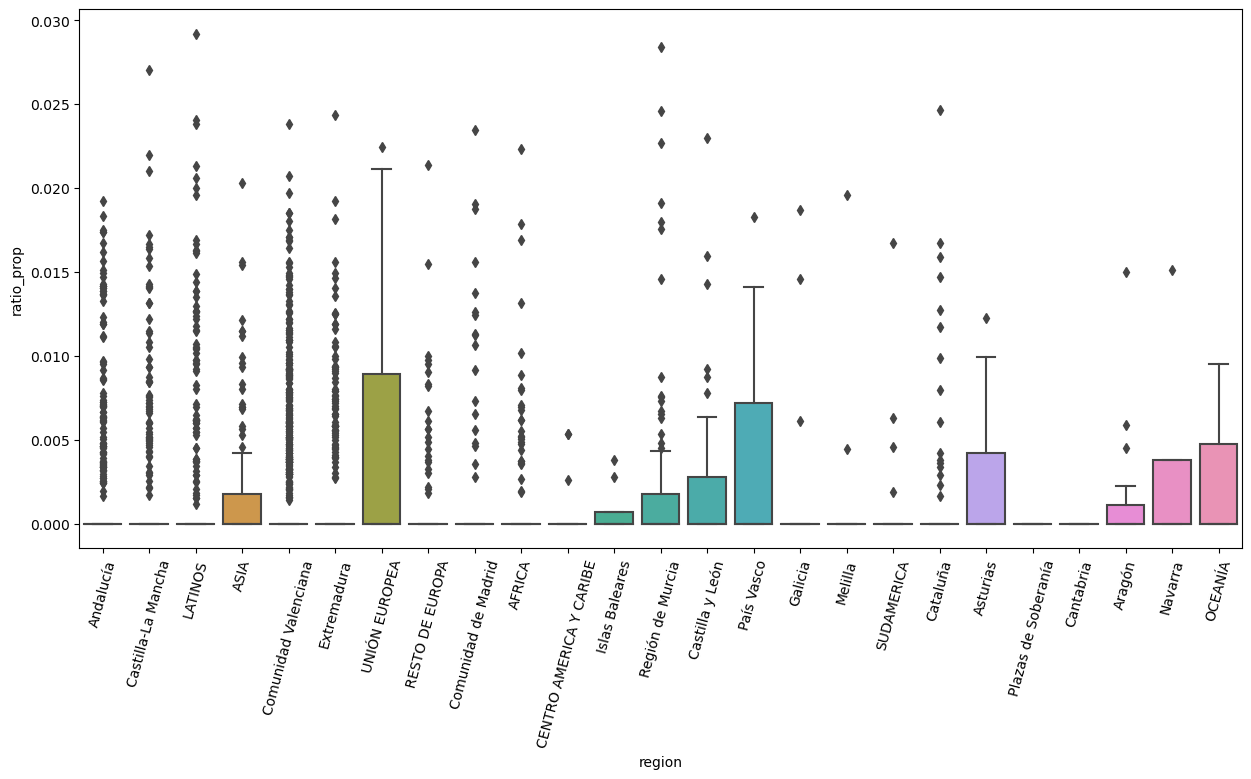

In [219]:
# remove outliers
data = df_syntactic_ratios.copy()
#data = remove_outliers(data,column='num_prop',value=2)
# boxplot
box_plot('ratio_prop',data)
# statistics
statistics('ratio_prop',data)

### 8. Ratio of pronouns

In [220]:
# Mann-Whitney U test
data = df_syntactic_ratios.copy()
res = mann_whitney(data,'ratio_pronouns')
print(res)

MannwhitneyuResult(statistic=1802298.0, pvalue=0.0004695752403109778)


In [221]:
# Kruskal-Wallis test
kruskal_posthoc(df_syntactic_ratios,'ratio_pronouns')


AGE: KruskalResult(statistic=24.649097144933236, pvalue=5.9179196918924984e-05)
AGE:           18-24     25-34     35-44     45-54       +55
18-24  1.000000  1.000000  0.069075  0.000665  0.017995
25-34  1.000000  1.000000  0.102986  0.003722  0.042828
35-44  0.069075  0.102986  1.000000  1.000000  1.000000
45-54  0.000665  0.003722  1.000000  1.000000  1.000000
+55    0.017995  0.042828  1.000000  1.000000  1.000000
REGION: KruskalResult(statistic=41.88173902374735, pvalue=0.00937076485510533)
REGION:                          Comunidad de Madrid  Andalucía  Extremadura  \
Comunidad de Madrid                      1.0   1.000000     1.000000   
Andalucía                                1.0   1.000000     1.000000   
Extremadura                              1.0   1.000000     1.000000   
Castilla y León                          1.0   1.000000     1.000000   
Comunidad Valenciana                     1.0   1.000000     1.000000   
Galicia                                  1.0   1.000000     

/var/folders/_x/cddkf2k97y19q18kzrrrxrzw0000gn/T/ipykernel_36317/2864299129.py:42: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  posthoc.set_axis(['18-24','25-34','35-44','45-54','+55'],axis=0,inplace=True)
/var/folders/_x/cddkf2k97y19q18kzrrrxrzw0000gn/T/ipykernel_36317/2864299129.py:43: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  posthoc.set_axis(['18-24','25-34','35-44','45-54','+55'],axis=1,inplace=True)
/var/folders/_x/cddkf2k97y19q18kzrrrxrzw0000gn/T/ipykernel_36317/2864299129.py:80: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  posthoc.set_axis(['Comunidad de Madrid','Andalucía','Extremadura','Castilla y León','Comunidad Valenciana','Galicia','

The d of Cohen for gender is: 0.12571117156356854
The f of Cohen for age is: 0.002083296711480255
The f of Cohen normalized for age is: 0.3887806518660985
The f of Cohen for demography is: 0.0028418199402898453
The f of Cohen normalized for demography is: 0.08209571487402909


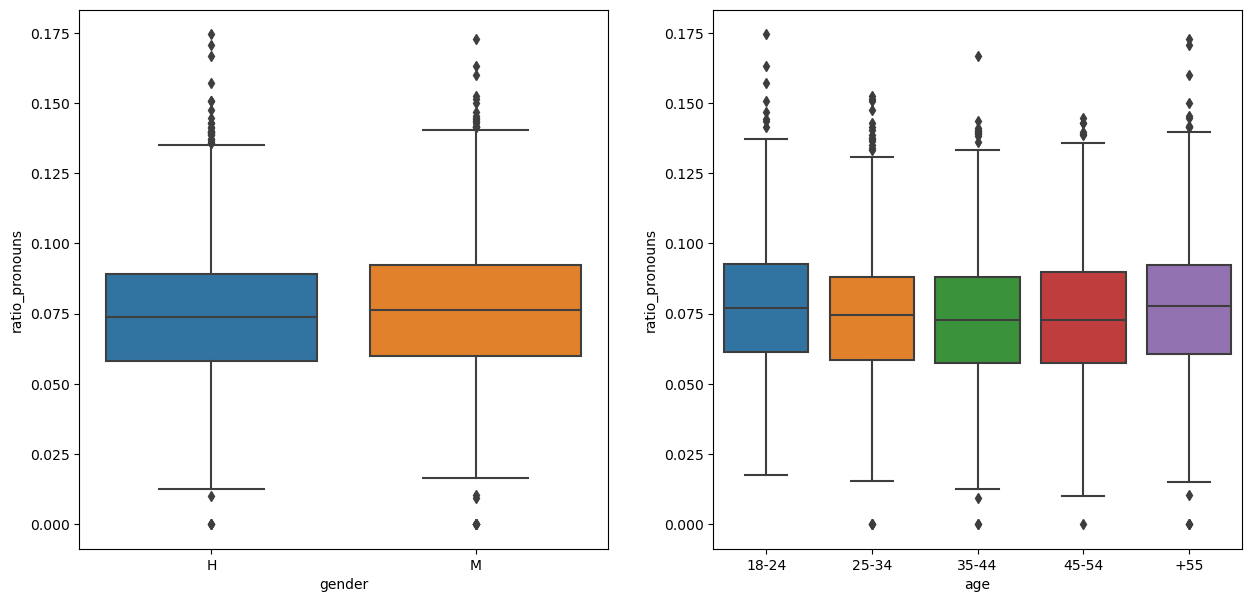

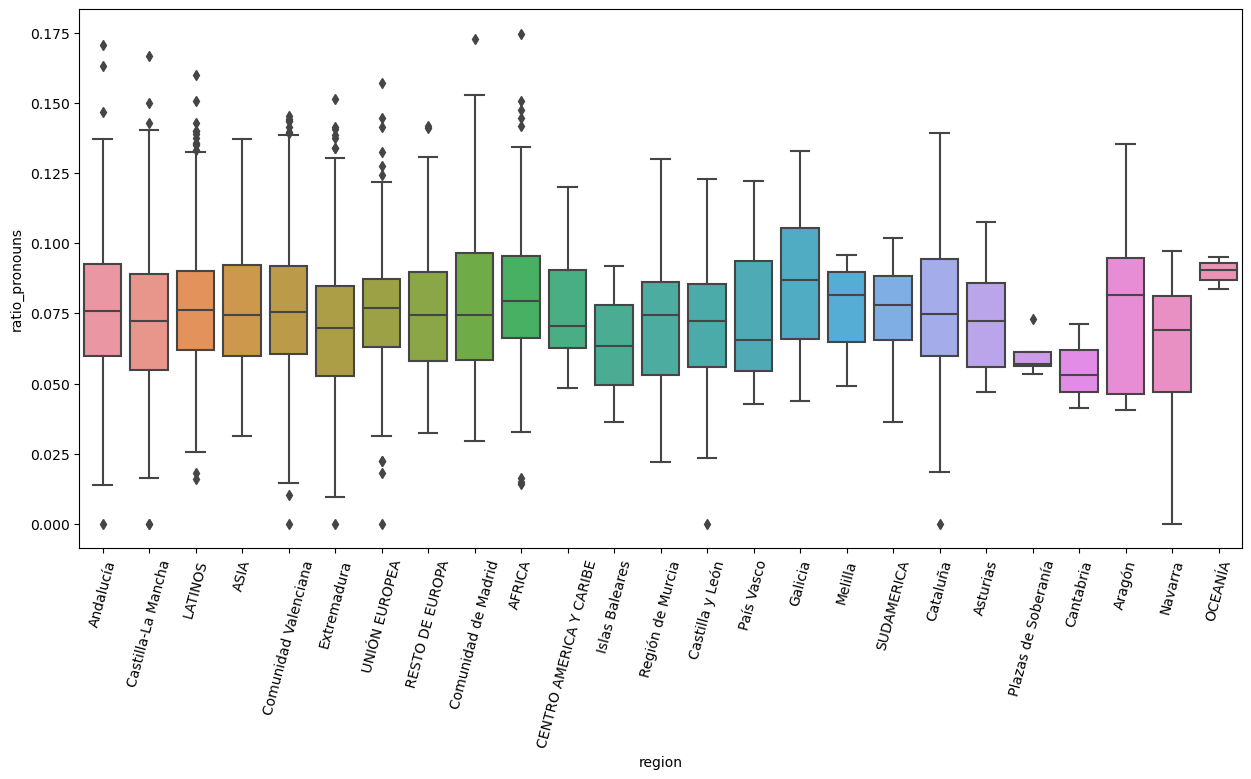

In [222]:
# remove outliers
data = df_syntactic_ratios.copy()
#data = remove_outliers(data,column='ratio_pronouns',value=37)
# boxplot
box_plot('ratio_pronouns',data)
# statistics
statistics('ratio_pronouns',data)

### 9. Ratio of past tense verbs

In [223]:
# Mann-Whitney U test
data = df_syntactic_ratios.copy()
res = mann_whitney(data,'ratio_past')
print(res)

MannwhitneyuResult(statistic=1735350.5, pvalue=0.10495617141563479)


In [224]:
# Kruskal-Wallis test
kruskal_posthoc(df_syntactic_ratios,'ratio_past')


AGE: KruskalResult(statistic=27.62360762873366, pvalue=1.4866809255875437e-05)
AGE:           18-24     25-34     35-44     45-54       +55
18-24  1.000000  0.001318  0.566976  0.566976  0.785740
25-34  0.001318  1.000000  0.200022  0.000009  0.001339
35-44  0.566976  0.200022  1.000000  0.044157  0.566976
45-54  0.566976  0.000009  0.044157  1.000000  0.566976
+55    0.785740  0.001339  0.566976  0.566976  1.000000
REGION: KruskalResult(statistic=33.48198380678732, pvalue=0.07302855898774897)
REGION:                          Comunidad de Madrid  Andalucía  Extremadura  \
Comunidad de Madrid                      1.0   1.000000          1.0   
Andalucía                                1.0   1.000000          1.0   
Extremadura                              1.0   1.000000          1.0   
Castilla y León                          1.0   1.000000          1.0   
Comunidad Valenciana                     1.0   1.000000          1.0   
Galicia                                  1.0   1.000000      

/var/folders/_x/cddkf2k97y19q18kzrrrxrzw0000gn/T/ipykernel_36317/2864299129.py:42: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  posthoc.set_axis(['18-24','25-34','35-44','45-54','+55'],axis=0,inplace=True)
/var/folders/_x/cddkf2k97y19q18kzrrrxrzw0000gn/T/ipykernel_36317/2864299129.py:43: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  posthoc.set_axis(['18-24','25-34','35-44','45-54','+55'],axis=1,inplace=True)
/var/folders/_x/cddkf2k97y19q18kzrrrxrzw0000gn/T/ipykernel_36317/2864299129.py:80: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  posthoc.set_axis(['Comunidad de Madrid','Andalucía','Extremadura','Castilla y León','Comunidad Valenciana','Galicia','

The d of Cohen for gender is: 0.07300877266654465
The f of Cohen for age is: 0.0006201069424876151
The f of Cohen normalized for age is: 0.33620755811277897
The f of Cohen for demography is: 0.0007037935199845183
The f of Cohen normalized for demography is: 0.04846995372415117


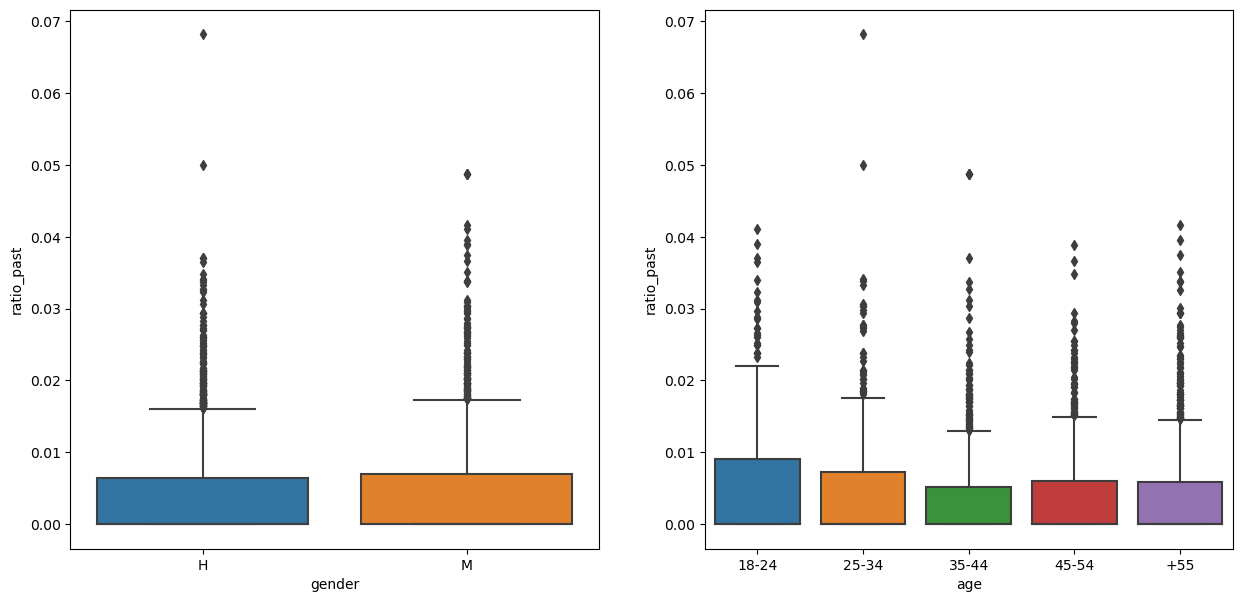

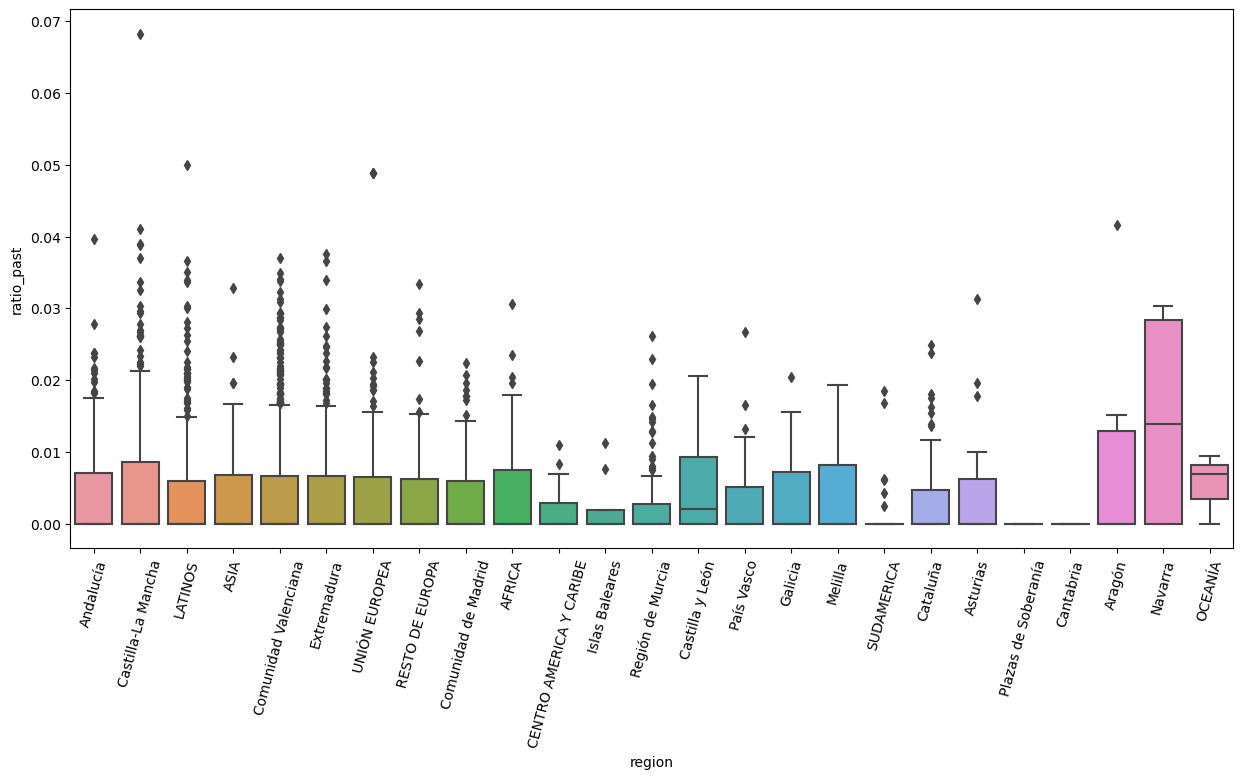

In [225]:
# remove outliers
data = df_syntactic_ratios.copy()
#data = remove_outliers(data,column='num_past',value=4)
# boxplot
box_plot('ratio_past',data)
# statistics
statistics('ratio_past',data)

### 10. Ratio of future tense verbs

In [226]:
# Mann-Whitney U test
data = df_syntactic_ratios.copy()
res = mann_whitney(data,'ratio_future')
print(res)

MannwhitneyuResult(statistic=1687675.0, pvalue=0.21410685891004988)


In [227]:
# Kruskal-Wallis test
kruskal_posthoc(df_syntactic_ratios,'ratio_future')


AGE: KruskalResult(statistic=2.8223085264242185, pvalue=0.5879880332082127)
AGE:        18-24  25-34  35-44  45-54  +55
18-24    1.0    1.0    1.0    1.0  1.0
25-34    1.0    1.0    1.0    1.0  1.0
35-44    1.0    1.0    1.0    1.0  1.0
45-54    1.0    1.0    1.0    1.0  1.0
+55      1.0    1.0    1.0    1.0  1.0
REGION: KruskalResult(statistic=8.879935847557684, pvalue=0.9963463918554384)
REGION:                          Comunidad de Madrid  Andalucía  Extremadura  \
Comunidad de Madrid                      1.0        1.0          1.0   
Andalucía                                1.0        1.0          1.0   
Extremadura                              1.0        1.0          1.0   
Castilla y León                          1.0        1.0          1.0   
Comunidad Valenciana                     1.0        1.0          1.0   
Galicia                                  1.0        1.0          1.0   
Cataluña                                 1.0        1.0          1.0   
Plazas de Soberanía    

/var/folders/_x/cddkf2k97y19q18kzrrrxrzw0000gn/T/ipykernel_36317/2864299129.py:42: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  posthoc.set_axis(['18-24','25-34','35-44','45-54','+55'],axis=0,inplace=True)
/var/folders/_x/cddkf2k97y19q18kzrrrxrzw0000gn/T/ipykernel_36317/2864299129.py:43: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  posthoc.set_axis(['18-24','25-34','35-44','45-54','+55'],axis=1,inplace=True)
/var/folders/_x/cddkf2k97y19q18kzrrrxrzw0000gn/T/ipykernel_36317/2864299129.py:80: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  posthoc.set_axis(['Comunidad de Madrid','Andalucía','Extremadura','Castilla y León','Comunidad Valenciana','Galicia','

The d of Cohen for gender is: -0.040566618895300235
The f of Cohen for age is: 2.4680037747782495e-06
The f of Cohen normalized for age is: 0.4412395868699545
The f of Cohen for demography is: 5.089062819333809e-06
The f of Cohen normalized for demography is: 0.27547605947335846


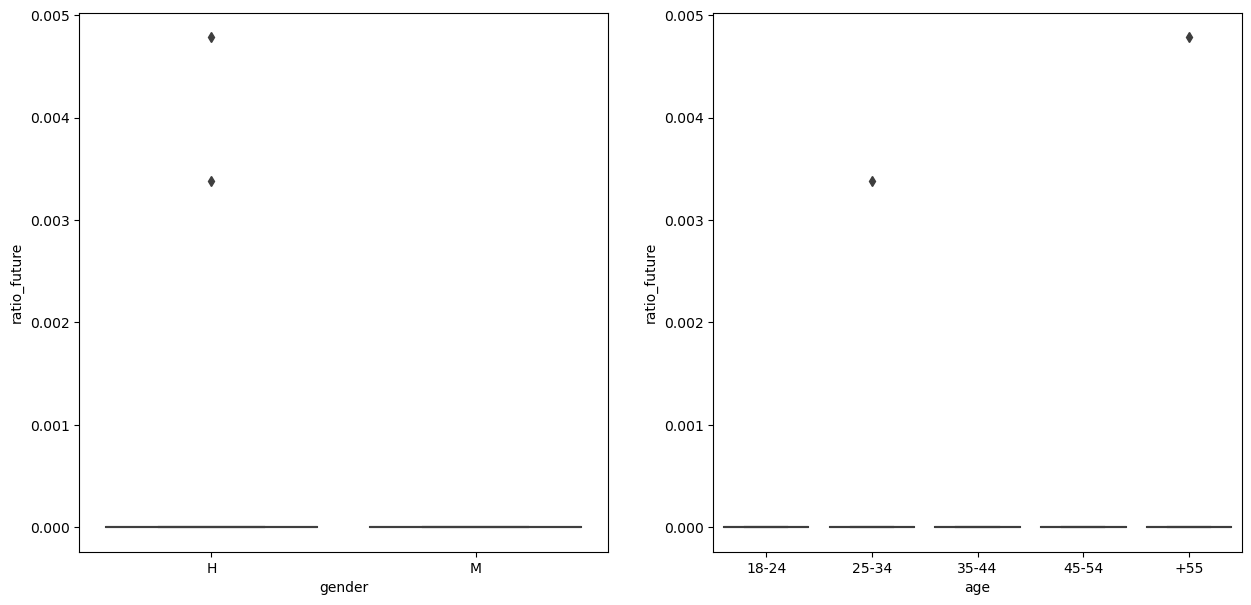

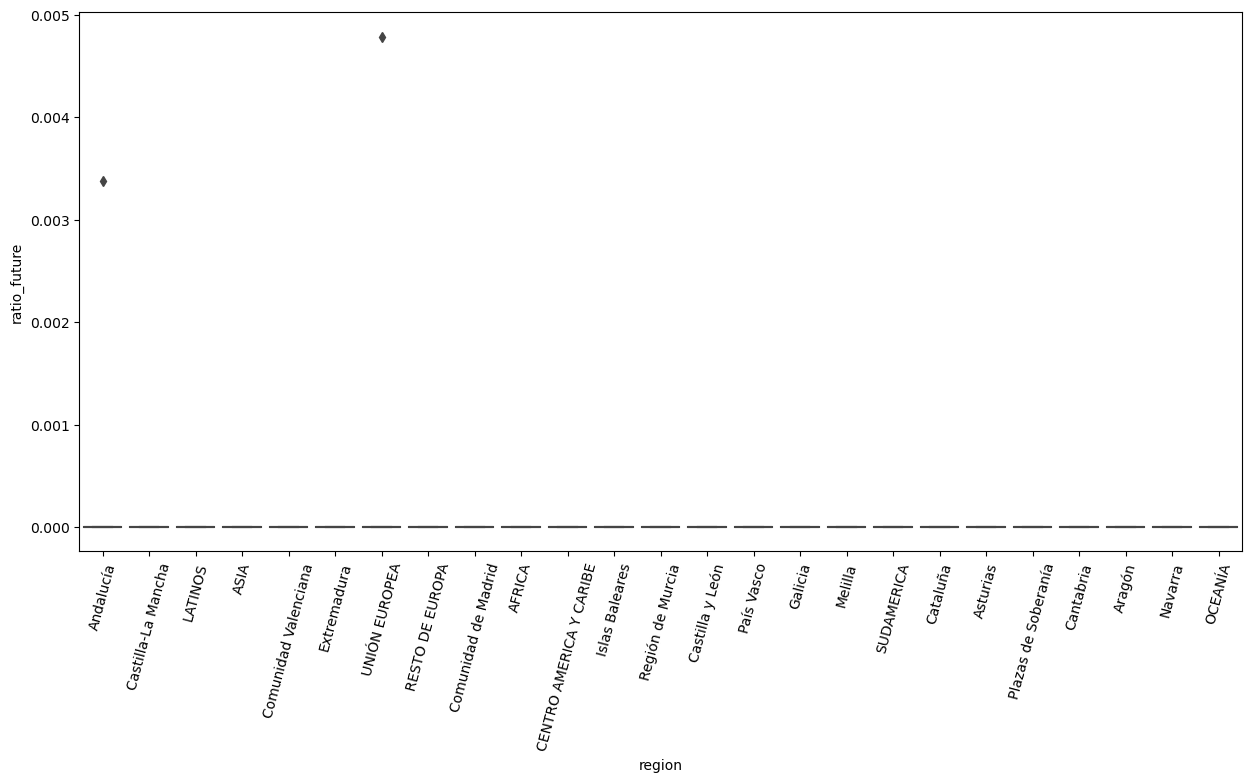

In [228]:
# remove outliers
data = df_syntactic_ratios.copy()
#data = remove_outliers(data,column='num_future',value=4)
# boxplot
box_plot('ratio_future',data)
# statistics
statistics('ratio_future',data)

### 11. Ratio of conjunctions

In [229]:
# Mann-Whitney U test
data = df_syntactic_ratios.copy()
res = mann_whitney(data,'ratio_conj')
print(res)

MannwhitneyuResult(statistic=1745919.5, pvalue=0.07966147806784309)


In [230]:
# Kruskal-Wallis test
kruskal_posthoc(df_syntactic_ratios,'ratio_conj')


AGE: KruskalResult(statistic=26.85272657876797, pvalue=2.1289299706763126e-05)
AGE:           18-24     25-34     35-44     45-54       +55
18-24  1.000000  0.000035  0.348838  1.000000  1.000000
25-34  0.000035  1.000000  0.083188  0.000060  0.003984
35-44  0.348838  0.083188  1.000000  0.348838  1.000000
45-54  1.000000  0.000060  0.348838  1.000000  1.000000
+55    1.000000  0.003984  1.000000  1.000000  1.000000
REGION: KruskalResult(statistic=32.466780858659, pvalue=0.09081852774313069)
REGION:                          Comunidad de Madrid  Andalucía  Extremadura  \
Comunidad de Madrid                      1.0   1.000000          1.0   
Andalucía                                1.0   1.000000          1.0   
Extremadura                              1.0   1.000000          1.0   
Castilla y León                          1.0   1.000000          1.0   
Comunidad Valenciana                     1.0   1.000000          1.0   
Galicia                                  1.0   1.000000        

/var/folders/_x/cddkf2k97y19q18kzrrrxrzw0000gn/T/ipykernel_36317/2864299129.py:42: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  posthoc.set_axis(['18-24','25-34','35-44','45-54','+55'],axis=0,inplace=True)
/var/folders/_x/cddkf2k97y19q18kzrrrxrzw0000gn/T/ipykernel_36317/2864299129.py:43: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  posthoc.set_axis(['18-24','25-34','35-44','45-54','+55'],axis=1,inplace=True)
/var/folders/_x/cddkf2k97y19q18kzrrrxrzw0000gn/T/ipykernel_36317/2864299129.py:80: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  posthoc.set_axis(['Comunidad de Madrid','Andalucía','Extremadura','Castilla y León','Comunidad Valenciana','Galicia','

The d of Cohen for gender is: 0.050886451582096655
The f of Cohen for age is: 0.001547546117228573
The f of Cohen normalized for age is: 0.34540882466203904
The f of Cohen for demography is: 0.0015420721666062813
The f of Cohen normalized for demography is: 0.07770915562510589


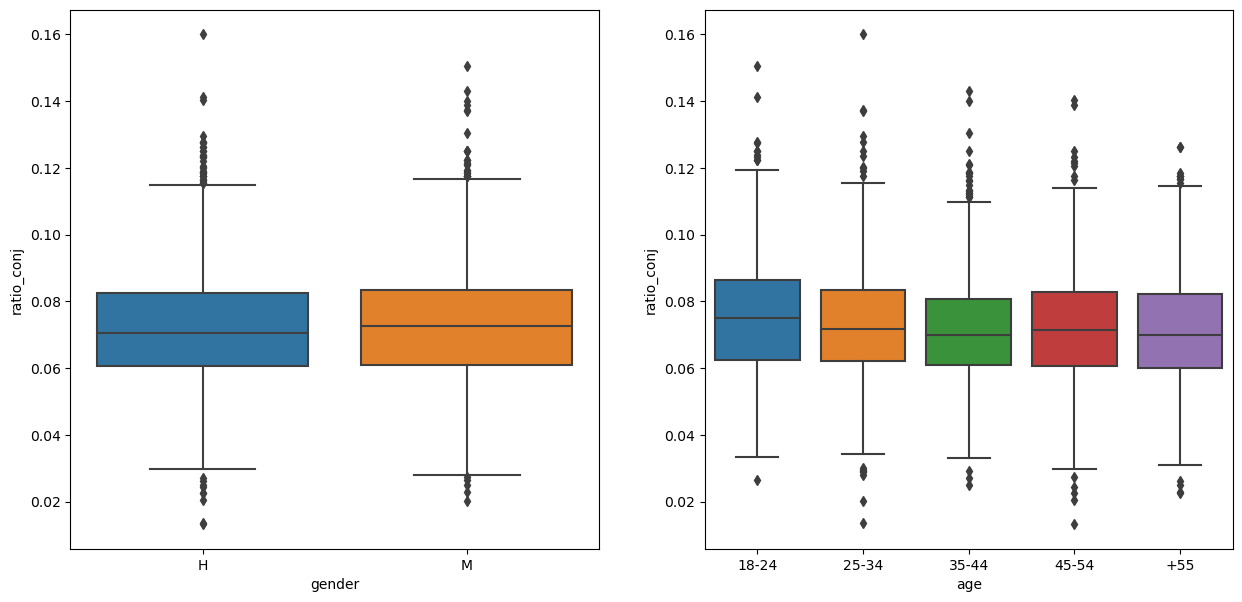

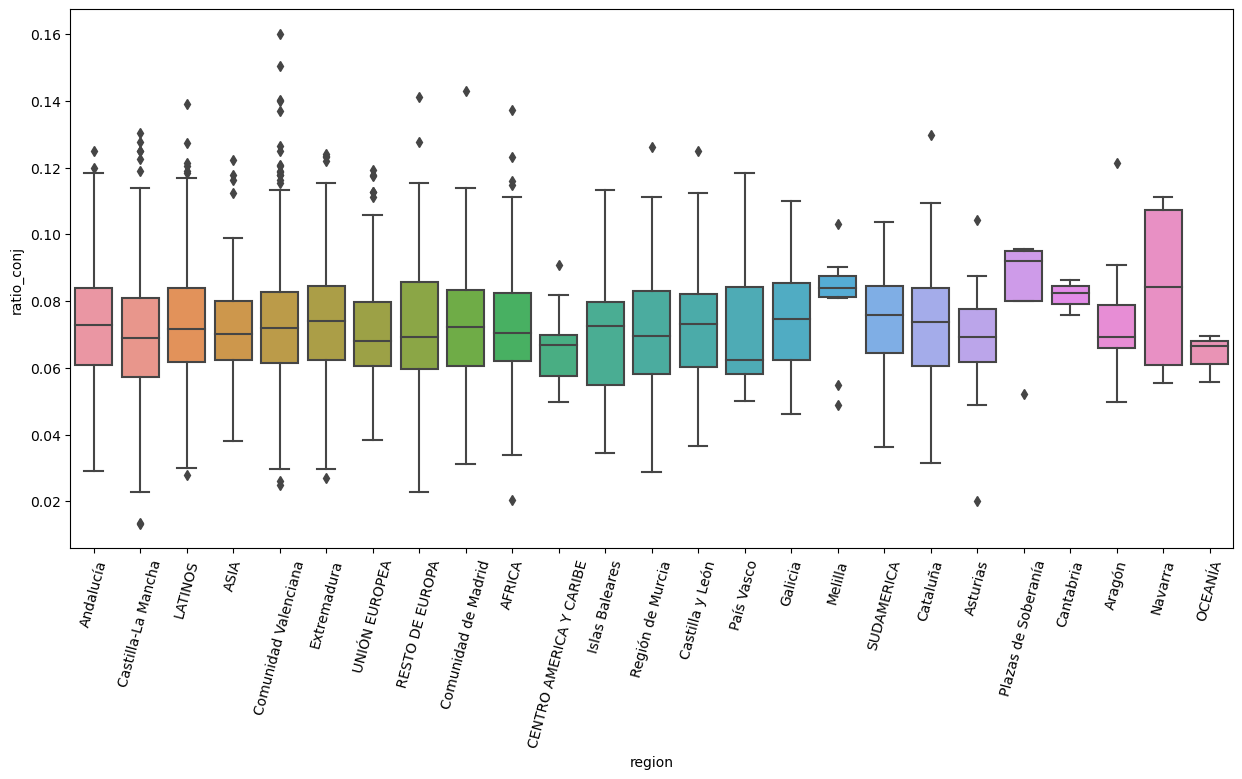

In [231]:
# remove outliers
data = df_syntactic_ratios.copy()
#data = remove_outliers(data,column='num_conj',value=22)
# boxplot
box_plot('ratio_conj',data)
# statistics
statistics('ratio_conj',data)

## WORD FEATURES ANALYSIS: 

1. Count of words
2. Count of positive words
3. Count of negative words
4. Unique words count
5. Count of words that occur twice
6. Average word length
7. Maximum length of a word
8. Count of words with numbers
9. Count of words with length greater than 6
10. Count of words with length smaller than 3
11. Count of stop words
12. Number of locations
13. Number of mentions to people
14. Number of telefones

#### Steps:

- Create boxplots to visualize independence between studied features and the users personal traits (gender, age and demography)
- Statistical measures: d of Cohen for traits with only 2 options, f of Cohen for traits with more than 2 possibilities.
The d of Cohen can be either positive or negative. Two variables are considered independant when the absolute value of d is 0 or very close to 0, and as the absolute value of d gets bigger, the relationship between the variables becomes stronger. Normaly, when the value is below 0.2 the dependency between the variables is considered small, when it is around 0.5 it's considered moderate, and the dependency is big when the value is greater than 0.8. These measures apply as well for the f of Cohen normilized. This measure is calculated dividing the f of Cohen between the difference of the max and min values of the groups of each of the studied features.

### SENTIMENT ANALYSIS FOR COUNT OF POSITIVE AND NEGATIVE WORDS: 

We are going to use a file from the NRC Association http://saifmohammad.com which indicates if a word is positive or negative, and the corresponding emotions associated to it. The emotions are anger, anticipation, disgust, fear, joy, sadness, surprise and trust. If the word isn't classified as positive or negative, we will classify it based on the emotion: if anger, disgust, fear or sadness we'll classify it as negative; if joy or trust we'll classify it as positive.

In [232]:
sent_analysis_data = pd.read_csv('../Spanish-NRC-EmoLex.txt',sep='\t')
sent_analysis_data.head()

English Word  anger  anticipation  disgust  fear  joy  negative  positive  \
0        aback      0             0        0     0    0         0         0   
1       abacus      0             0        0     0    0         0         0   
2      abandon      0             0        0     1    0         1         0   
3    abandoned      1             0        0     1    0         1         0   
4  abandonment      1             0        0     1    0         1         0   

   sadness  surprise  trust Spanish Word  
0        0         0      0       detrás  
1        0         0      1        ábaco  
2        1         0      0    abandonar  
3        1         0      0   abandonado  
4        1         1      0     abandono

In [233]:
def sent_analysis(word):
    columns = sent_analysis_data.keys()
    negative = ['negative','fear','anger','disgust','sadness']
    positive = ['positive','joy','trust']

    row = sent_analysis_data.loc[sent_analysis_data['Spanish Word'] == word]
    cols = np.where(row == 1)
    attributes = [columns[i] for i in cols]

    intersection_neg = list(set(negative) & set(attributes[0]))
    intersection_pos = list(set(positive) & set(attributes[0]))

    if len(intersection_neg) != 0:
        if len(intersection_pos) != 0:
            return 'Both'
        else:
            return 'Negative'
    elif len(intersection_pos) != 0:
        return 'Positive'

    return None

In [234]:
# returns a list of words that occur exactly 'num' times or None if no coincidence
def num_occurences(lista,num):
    aux_dict = {}
    for item in lista:
        if item in aux_dict.keys():
            aux_dict[item] += 1
        else:
            aux_dict[item] = 1

    try:
        idx = list(aux_dict.values()).index(num)
        words = list(aux_dict.keys())[idx]
        return len(words)
    except:
        return 0

In [235]:
# load data for character based features analysis
def df_word_based():

    data = pd.DataFrame() 

    # load spanish stop words
    stop_words_df = pd.read_csv('../spanish-stop-words.txt',header=None)
    stop_words = list(stop_words_df[0])

    num_words = []
    num_pos_words = []
    num_neg_words = []
    num_unique = []
    num_twice = []
    av_length = []
    max_length = []
    num_numbers = []
    num_greater = []
    num_smaller = []
    num_stop = []
    num_locations = []
    num_telefono = []
    num_fechas = []
    num_personas = []

    for file in files:
        with open(f'Atestados/{file}') as f:
            _dict = json.load(f)

            # denuncia
            text = _dict['denuncia']

            # before cleaning, count num of tags
            tags = re.findall('LOC|NUM|TIEM|PER',text)
            counter = Counter(tags)
            for k in ['LOC','NUM','TIEM','PER']:
                if k not in counter.keys():
                    counter[k] = 0
                    
            for k,v in counter.items():
                if k == 'LOC':
                    num_locations.append(v)
                elif k == 'NUM':
                    num_telefono.append(v)
                elif k == 'TIEM':
                    num_fechas.append(v)
                elif k == 'PER':
                    num_personas.append(v)

            # remove punctuation
            # clean text
            text = quitar_tags(text)
            cleaned_text = clean_text(text,file)
            cleaned_text = cleaned_text.translate(str.maketrans('','',string.punctuation))
            sentences = cleaned_text.split('\n')
            words = []
            for sentence in sentences:
                words += sentence.split(' ')
            words = [w for w in words if len(w) != 0]
            words_lower = [w.lower() for w in words if len(w) != 0]

            num_words.append(len(words))

            # sentiment analysis
            pos = 0
            neg = 0
            for word in words:
                sentiment = sent_analysis(word)
                if sentiment == 'Both':
                    neg += 1
                    pos += 1
                elif sentiment == 'Positive':
                    pos += 1
                elif sentiment == 'Negative':
                    neg += 1

            num_pos_words.append(pos)
            num_neg_words.append(neg)

            # unique words
            num_unique.append(num_occurences(words,1))
            # twice occurrences
            num_twice.append(num_occurences(words,2))
            
            # max, av, >6, <3 length and num words with digits, count english words
            max_len = 0
            sum_length = 0
            digits = 0
            len_greater = 0
            len_smaller = 0
            for word in words:
                sum_length += len(word)
                if len(word) > max_len:
                    max_len = len(word)

                if len(re.findall('\d',word)) > 0:
                    digits += 1

                if len(word) > 6:
                    len_greater += 1
                elif len(word) < 3:
                    len_smaller += 1
            
            av_length.append(sum_length/len(words))
            max_length.append(max_len)
            num_numbers.append(digits)
            num_greater.append(len_greater)
            num_smaller.append(len_smaller)


            # count stop-words 
            intersection_stop = list(set(stop_words) & set(words_lower))
            num_stop.append(len(intersection_stop))

    data['num_locations'] = num_locations
    data['num_fechas'] = num_fechas
    data['num_personas'] = num_personas
    data['num_telefono'] = num_telefono
    data['num_words'] = num_words
    data['num_pos_words'] = num_pos_words
    data['num_neg_words'] = num_neg_words
    data['num_unique'] = num_unique
    data['num_twice'] = num_twice
    data['av_length'] = av_length
    data['max_length'] = max_length
    data['num_numbers'] = num_numbers
    data['num_greater'] = num_greater
    data['num_smaller'] = num_smaller
    data['num_stop'] = num_stop

    return pd.concat([denunciante_df,data],axis=1)         

In [236]:
df_word = df_word_based()
df_word.head()

gender    age                region  num_locations  num_fechas  \
0      H  25-34             Andalucía              1           2   
1      M    +55    Castilla-La Mancha              2           6   
2      M  25-34               LATINOS              1           4   
3      M    +55                  ASIA              4           2   
4      M    +55  Comunidad Valenciana              4           3   

   num_personas  num_telefono  num_words  num_pos_words  num_neg_words  \
0             0             0         40              0              1   
1             0             0        155              0              8   
2             0             0        116              0              1   
3             3             4        304              0              3   
4             0             0        697              0             24   

   num_unique  num_twice  av_length  max_length  num_numbers  num_greater  \
0           2          3   5.475000          15            2           16   
1           8          3   4.612903          15            0           47   
2           8          3   4.732759          15            2           30   
3           8          3   5.013158          15           20           94   
4          12          9   4.658537          15           19          196   

   num_smaller  num_stop  
0           10        13  
1           56        38  
2           32        38  
3           96        32  
4          234        70

### 1. Number of words

In [237]:
# Mann-Whitney U test
data = df_word.copy()
res = mann_whitney(data,'num_words')
print(res)

MannwhitneyuResult(statistic=1564017.0, pvalue=0.00010568562252645649)


In [238]:
# Kruskal-Wallis test
kruskal_posthoc(df_word,'num_words')


AGE: KruskalResult(statistic=37.62759219193096, pvalue=1.337333923300718e-07)
AGE:               18-24         25-34     35-44     45-54       +55
18-24  1.000000e+00  3.595488e-07  0.004721  0.027120  0.909064
25-34  3.595488e-07  1.000000e+00  0.202378  0.041483  0.000066
35-44  4.720785e-03  2.023777e-01  1.000000  0.909064  0.057038
45-54  2.712016e-02  4.148350e-02  0.909064  1.000000  0.202378
+55    9.090638e-01  6.641100e-05  0.057038  0.202378  1.000000
REGION: KruskalResult(statistic=245.93982321132574, pvalue=3.166773766687061e-39)
REGION:                          Comunidad de Madrid     Andalucía  Extremadura  \
Comunidad de Madrid                 1.000000  1.000000e+00     1.000000   
Andalucía                           1.000000  1.000000e+00     0.020952   
Extremadura                         1.000000  2.095160e-02     1.000000   
Castilla y León                     1.000000  1.971710e-01     1.000000   
Comunidad Valenciana                1.000000  1.528720e-11     1.000

/var/folders/_x/cddkf2k97y19q18kzrrrxrzw0000gn/T/ipykernel_36317/2864299129.py:42: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  posthoc.set_axis(['18-24','25-34','35-44','45-54','+55'],axis=0,inplace=True)
/var/folders/_x/cddkf2k97y19q18kzrrrxrzw0000gn/T/ipykernel_36317/2864299129.py:43: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  posthoc.set_axis(['18-24','25-34','35-44','45-54','+55'],axis=1,inplace=True)
/var/folders/_x/cddkf2k97y19q18kzrrrxrzw0000gn/T/ipykernel_36317/2864299129.py:80: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  posthoc.set_axis(['Comunidad de Madrid','Andalucía','Extremadura','Castilla y León','Comunidad Valenciana','Galicia','

The d of Cohen for gender is: -0.11010655881800563
The f of Cohen for age is: 9.196402521678195
The f of Cohen normalized for age is: 0.33846307741809295
The f of Cohen for demography is: 19.082769230413486
The f of Cohen normalized for demography is: 0.11779487179267584


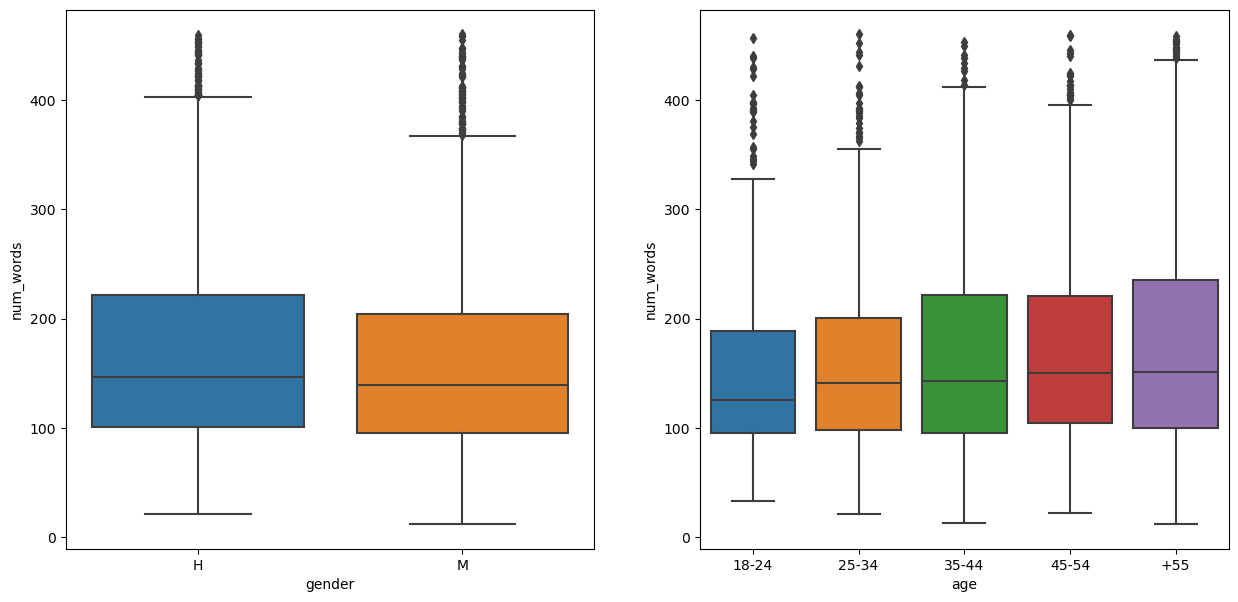

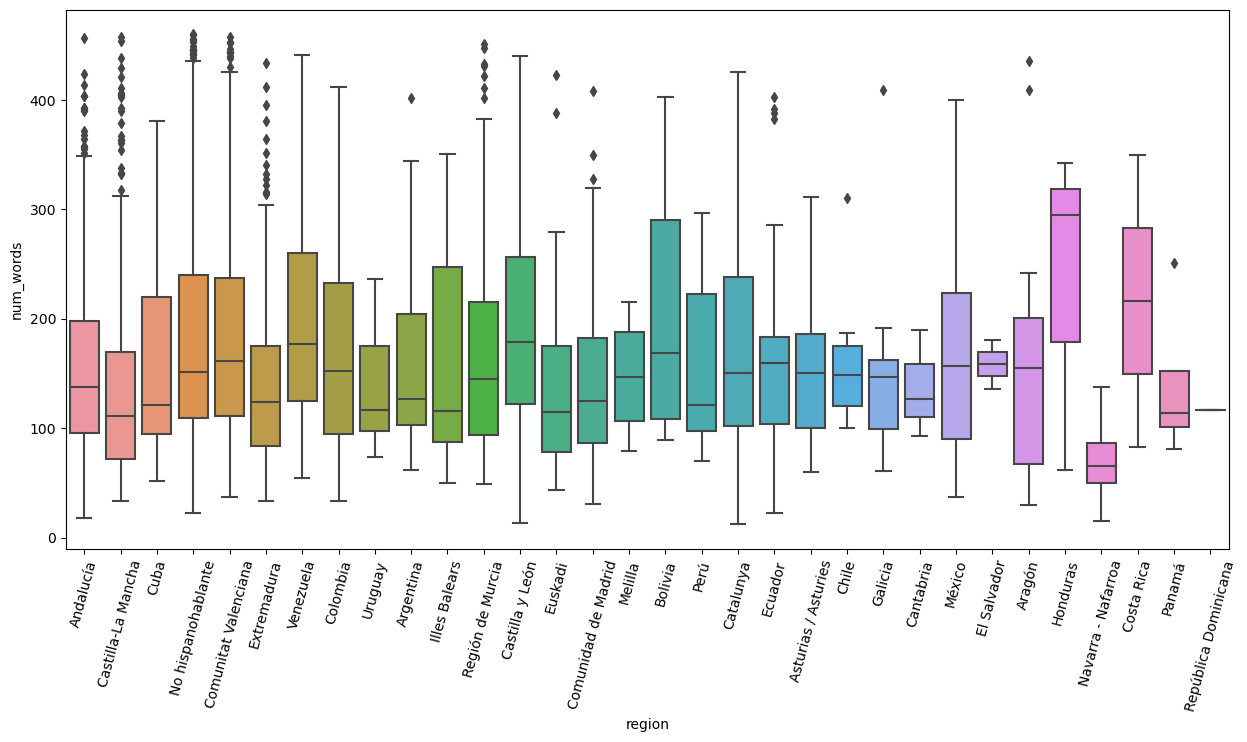

In [103]:
# remove outliers
data = df_word.copy()
data = remove_outliers(data,column='num_words',value=460)
# boxplot
box_plot('num_words',data)
# statistics
statistics('num_words',data)

### 2. Number of positive words

In [239]:
# Mann-Whitney U test
data = df_word.copy()
res = mann_whitney(data,'num_pos_words')
print(res)

MannwhitneyuResult(statistic=1684564.0, pvalue=0.40186648925327584)


In [240]:
# Kruskal-Wallis test
kruskal_posthoc(df_word,'num_pos_words')


AGE: KruskalResult(statistic=2.9987588427500658, pvalue=0.55803312656144)
AGE:        18-24  25-34  35-44  45-54  +55
18-24    1.0    1.0    1.0    1.0  1.0
25-34    1.0    1.0    1.0    1.0  1.0
35-44    1.0    1.0    1.0    1.0  1.0
45-54    1.0    1.0    1.0    1.0  1.0
+55      1.0    1.0    1.0    1.0  1.0
REGION: KruskalResult(statistic=20.775422871191232, pvalue=0.5948000532187343)
REGION:                          Comunidad de Madrid  Andalucía  Extremadura  \
Comunidad de Madrid                      1.0        1.0          1.0   
Andalucía                                1.0        1.0          1.0   
Extremadura                              1.0        1.0          1.0   
Castilla y León                          1.0        1.0          1.0   
Comunidad Valenciana                     1.0        1.0          1.0   
Galicia                                  1.0        1.0          1.0   
Cataluña                                 1.0        1.0          1.0   
Plazas de Soberanía     

/var/folders/_x/cddkf2k97y19q18kzrrrxrzw0000gn/T/ipykernel_36317/2864299129.py:42: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  posthoc.set_axis(['18-24','25-34','35-44','45-54','+55'],axis=0,inplace=True)
/var/folders/_x/cddkf2k97y19q18kzrrrxrzw0000gn/T/ipykernel_36317/2864299129.py:43: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  posthoc.set_axis(['18-24','25-34','35-44','45-54','+55'],axis=1,inplace=True)
/var/folders/_x/cddkf2k97y19q18kzrrrxrzw0000gn/T/ipykernel_36317/2864299129.py:80: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  posthoc.set_axis(['Comunidad de Madrid','Andalucía','Extremadura','Castilla y León','Comunidad Valenciana','Galicia','

The d of Cohen for gender is: -0.01604196011300059
The f of Cohen for age is: 0.0037384608759595487
The f of Cohen normalized for age is: 0.3801342565581929
The f of Cohen for demography is: 0.011140252828732633
The f of Cohen normalized for demography is: 0.07798176980112843


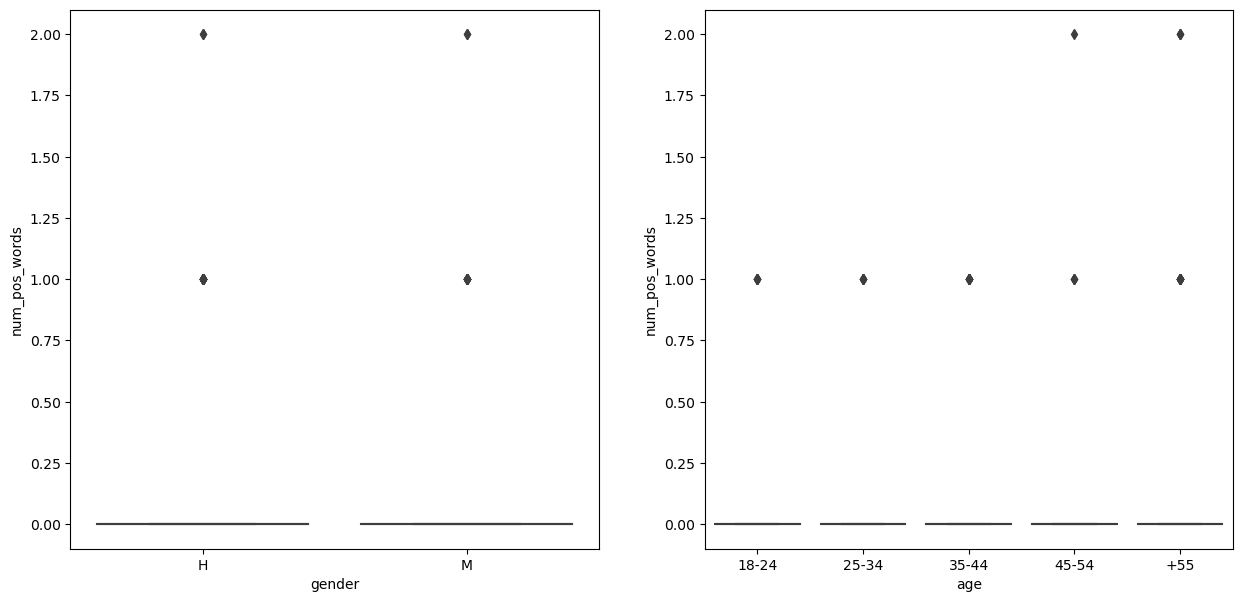

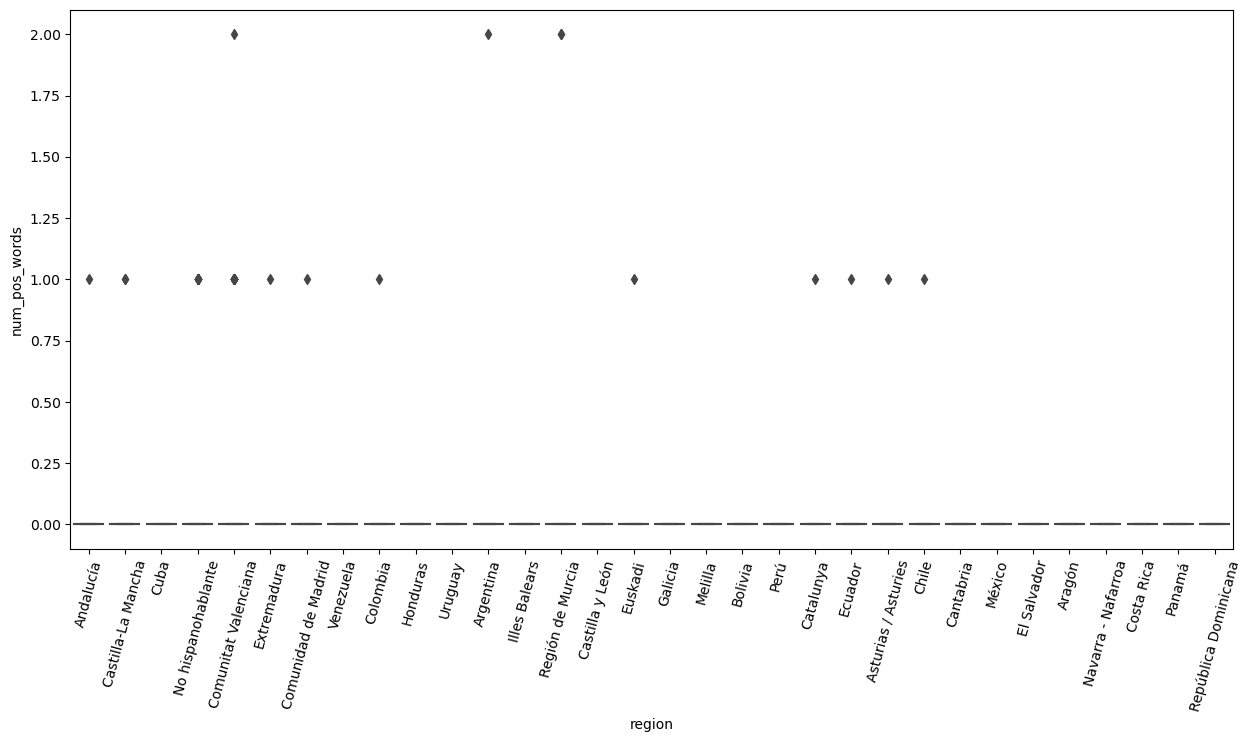

In [104]:
# remove outliers
data = df_word.copy()
#data = remove_outliers(data,column='num_pos_words',value=150)
# boxplot
box_plot('num_pos_words',data)
# statistics
statistics('num_pos_words',data)

### 3. Number of negative words

In [241]:
# Mann-Whitney U test
data = df_word.copy()
res = mann_whitney(data,'num_neg_words')
print(res)

MannwhitneyuResult(statistic=1655474.5, pvalue=0.29338213822325865)


In [242]:
# Kruskal-Wallis test
kruskal_posthoc(df_word,'num_neg_words')


AGE: KruskalResult(statistic=23.046356710475855, pvalue=0.00012395435567196577)
AGE:           18-24     25-34     35-44     45-54       +55
18-24  1.000000  0.000140  0.023946  0.444588  0.801788
25-34  0.000140  1.000000  0.786070  0.061298  0.008118
35-44  0.023946  0.786070  1.000000  0.786070  0.262870
45-54  0.444588  0.061298  0.786070  1.000000  0.801788
+55    0.801788  0.008118  0.262870  0.801788  1.000000
REGION: KruskalResult(statistic=221.21044777284706, pvalue=2.4646410884413582e-34)
REGION:                          Comunidad de Madrid     Andalucía  Extremadura  \
Comunidad de Madrid                 1.000000  1.000000e+00     1.000000   
Andalucía                           1.000000  1.000000e+00     1.000000   
Extremadura                         1.000000  1.000000e+00     1.000000   
Castilla y León                     1.000000  2.967557e-01     1.000000   
Comunidad Valenciana                1.000000  4.243164e-08     1.000000   
Galicia                             1.

/var/folders/_x/cddkf2k97y19q18kzrrrxrzw0000gn/T/ipykernel_36317/2864299129.py:42: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  posthoc.set_axis(['18-24','25-34','35-44','45-54','+55'],axis=0,inplace=True)
/var/folders/_x/cddkf2k97y19q18kzrrrxrzw0000gn/T/ipykernel_36317/2864299129.py:43: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  posthoc.set_axis(['18-24','25-34','35-44','45-54','+55'],axis=1,inplace=True)
/var/folders/_x/cddkf2k97y19q18kzrrrxrzw0000gn/T/ipykernel_36317/2864299129.py:80: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  posthoc.set_axis(['Comunidad de Madrid','Andalucía','Extremadura','Castilla y León','Comunidad Valenciana','Galicia','

The d of Cohen for gender is: -0.031178626293815986
The f of Cohen for age is: 0.29706355671978435
The f of Cohen normalized for age is: 0.35409417479802024
The f of Cohen for demography is: 0.7653640240238843
The f of Cohen normalized for demography is: 0.10933771771769775


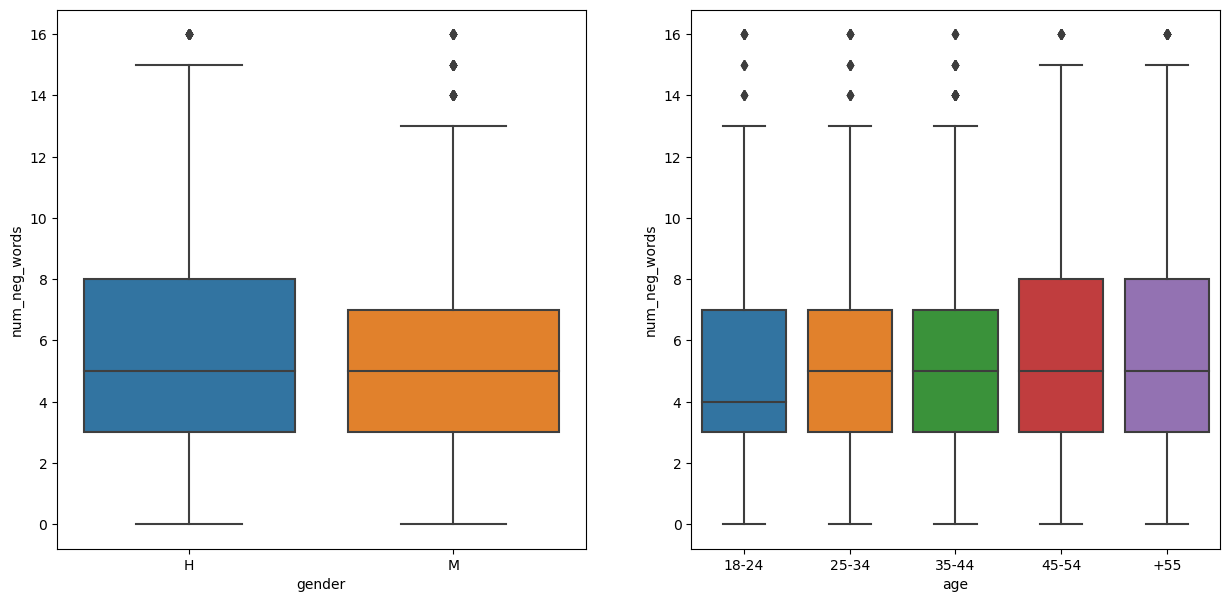

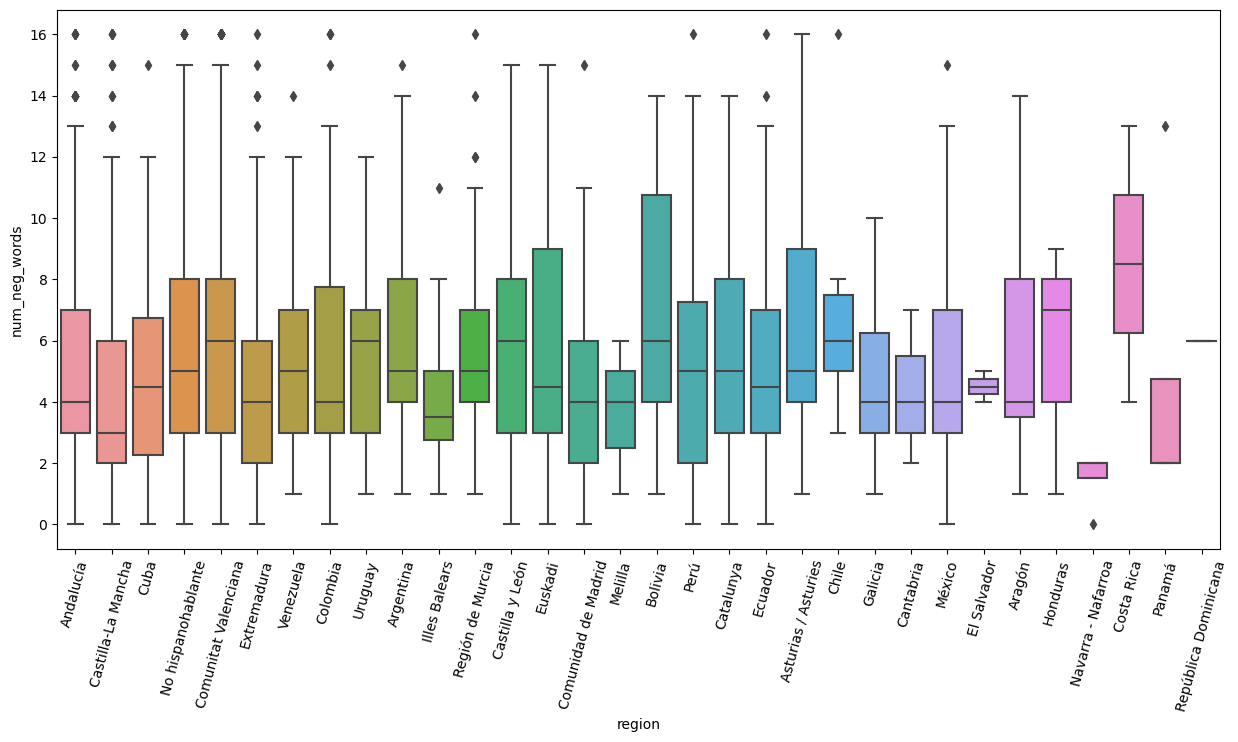

In [107]:
data = df_word.copy()
# remove outliers
data = remove_outliers(data,column='num_neg_words',value=16)
# boxplot
box_plot('num_neg_words',data)
# statistics
statistics('num_neg_words',data)

### 4. Unique words count

In [243]:
# Mann-Whitney U test
data = df_word.copy()
res = mann_whitney(data,'num_unique')
print(res)

MannwhitneyuResult(statistic=1712832.5, pvalue=0.23156153753578623)


In [244]:
# Kruskal-Wallis test
kruskal_posthoc(df_word,'num_unique')


AGE: KruskalResult(statistic=16.07629238756968, pvalue=0.0029184806966710023)
AGE:           18-24    25-34     35-44     45-54       +55
18-24  1.000000  1.00000  1.000000  0.016528  1.000000
25-34  1.000000  1.00000  1.000000  0.004630  1.000000
35-44  1.000000  1.00000  1.000000  0.198991  1.000000
45-54  0.016528  0.00463  0.198991  1.000000  0.016528
+55    1.000000  1.00000  1.000000  0.016528  1.000000
REGION: KruskalResult(statistic=56.947112499445204, pvalue=0.0001042274006167989)
REGION:                          Comunidad de Madrid  Andalucía  Extremadura  \
Comunidad de Madrid                 1.000000        1.0          1.0   
Andalucía                           1.000000        1.0          1.0   
Extremadura                         1.000000        1.0          1.0   
Castilla y León                     1.000000        1.0          1.0   
Comunidad Valenciana                1.000000        1.0          1.0   
Galicia                             1.000000        1.0          

/var/folders/_x/cddkf2k97y19q18kzrrrxrzw0000gn/T/ipykernel_36317/2864299129.py:42: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  posthoc.set_axis(['18-24','25-34','35-44','45-54','+55'],axis=0,inplace=True)
/var/folders/_x/cddkf2k97y19q18kzrrrxrzw0000gn/T/ipykernel_36317/2864299129.py:43: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  posthoc.set_axis(['18-24','25-34','35-44','45-54','+55'],axis=1,inplace=True)
/var/folders/_x/cddkf2k97y19q18kzrrrxrzw0000gn/T/ipykernel_36317/2864299129.py:80: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  posthoc.set_axis(['Comunidad de Madrid','Andalucía','Extremadura','Castilla y León','Comunidad Valenciana','Galicia','

The d of Cohen for gender is: 0.04969912039017453
The f of Cohen for age is: 0.10516852922052426
The f of Cohen normalized for age is: 0.36464577822241095
The f of Cohen for demography is: 0.1898224246732416
The f of Cohen normalized for demography is: 0.09400729602865295


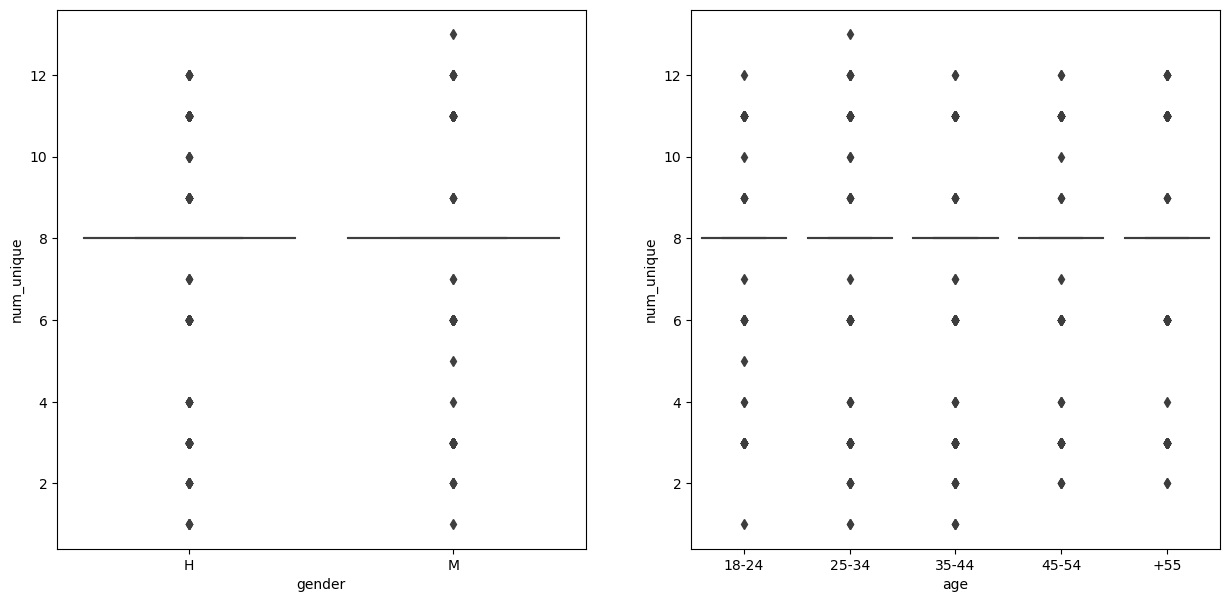

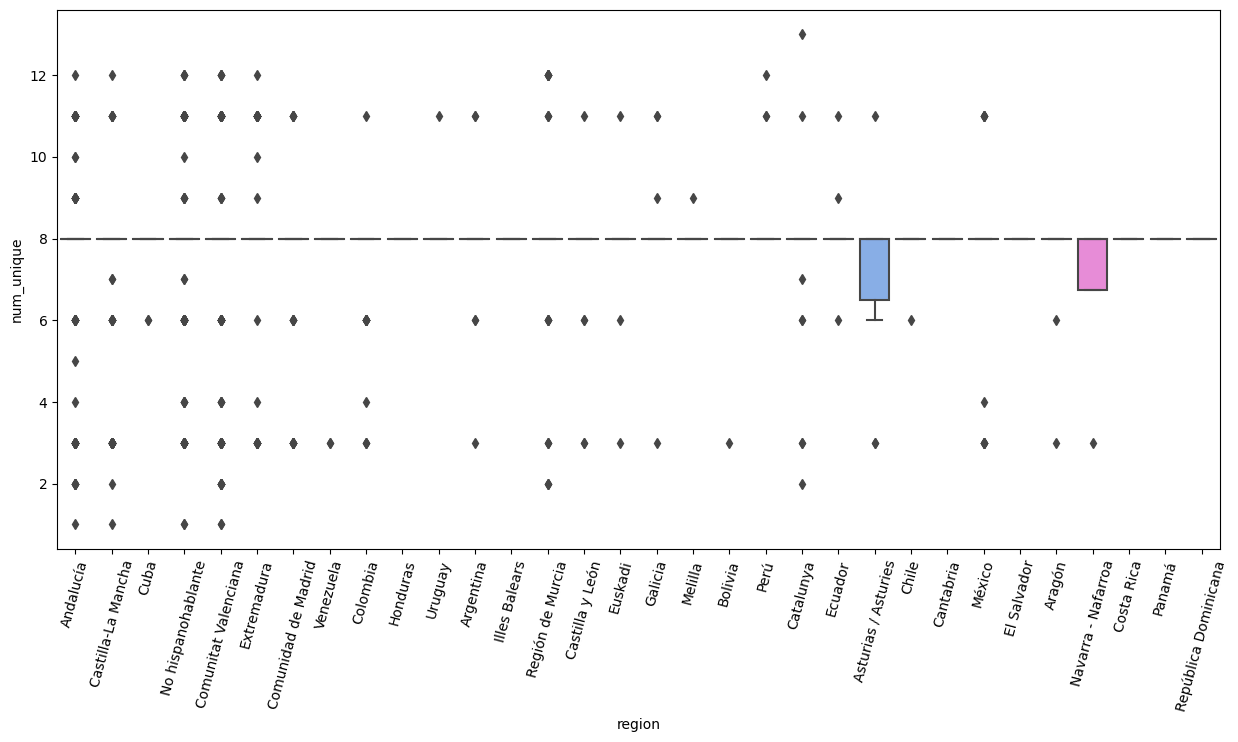

In [108]:
data = df_word.copy()
# remove outliers
#data = remove_outliers(data,column='num_unique',value=12)
# boxplot
box_plot('num_unique',data)
# statistics
statistics('num_unique',data)

### 5. Number of words that occur twice

In [245]:
# Mann-Whitney U test
data = df_word.copy()
res = mann_whitney(data,'num_twice')
print(res)

MannwhitneyuResult(statistic=1656807.0, pvalue=0.29118100429952476)


In [246]:
# Kruskal-Wallis test
kruskal_posthoc(df_word,'num_twice')


AGE: KruskalResult(statistic=13.530957445453517, pvalue=0.008952785046895619)
AGE:           18-24     25-34     35-44     45-54       +55
18-24  1.000000  0.052744  1.000000  1.000000  1.000000
25-34  0.052744  1.000000  0.936874  0.144831  0.005752
35-44  1.000000  0.936874  1.000000  1.000000  0.314981
45-54  1.000000  0.144831  1.000000  1.000000  1.000000
+55    1.000000  0.005752  0.314981  1.000000  1.000000
REGION: KruskalResult(statistic=48.492878171935004, pvalue=0.00144634815352724)
REGION:                          Comunidad de Madrid  Andalucía  Extremadura  \
Comunidad de Madrid                 1.000000   1.000000          1.0   
Andalucía                           1.000000   1.000000          1.0   
Extremadura                         1.000000   1.000000          1.0   
Castilla y León                     1.000000   1.000000          1.0   
Comunidad Valenciana                1.000000   1.000000          1.0   
Galicia                             1.000000   1.000000      

/var/folders/_x/cddkf2k97y19q18kzrrrxrzw0000gn/T/ipykernel_36317/2864299129.py:42: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  posthoc.set_axis(['18-24','25-34','35-44','45-54','+55'],axis=0,inplace=True)
/var/folders/_x/cddkf2k97y19q18kzrrrxrzw0000gn/T/ipykernel_36317/2864299129.py:43: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  posthoc.set_axis(['18-24','25-34','35-44','45-54','+55'],axis=1,inplace=True)
/var/folders/_x/cddkf2k97y19q18kzrrrxrzw0000gn/T/ipykernel_36317/2864299129.py:80: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  posthoc.set_axis(['Comunidad de Madrid','Andalucía','Extremadura','Castilla y León','Comunidad Valenciana','Galicia','

The d of Cohen for gender is: -0.021403069209952944
The f of Cohen for age is: 0.15139500517041904
The f of Cohen normalized for age is: 0.310889667314109
The f of Cohen for demography is: 0.2879623480168185
The f of Cohen normalized for demography is: 0.06260051043843881


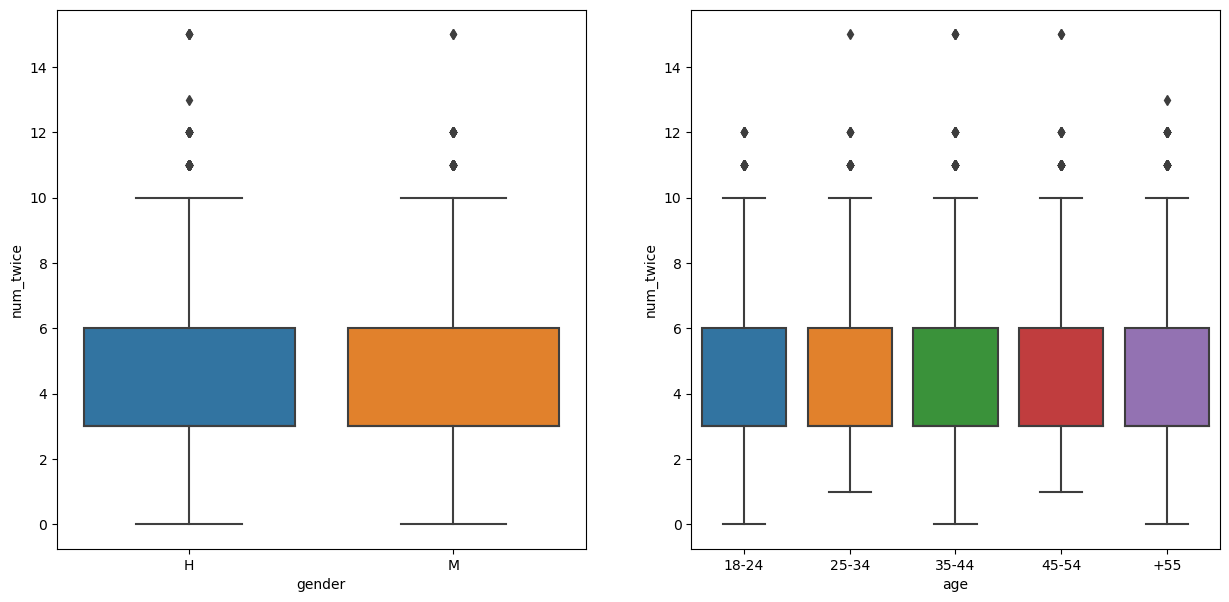

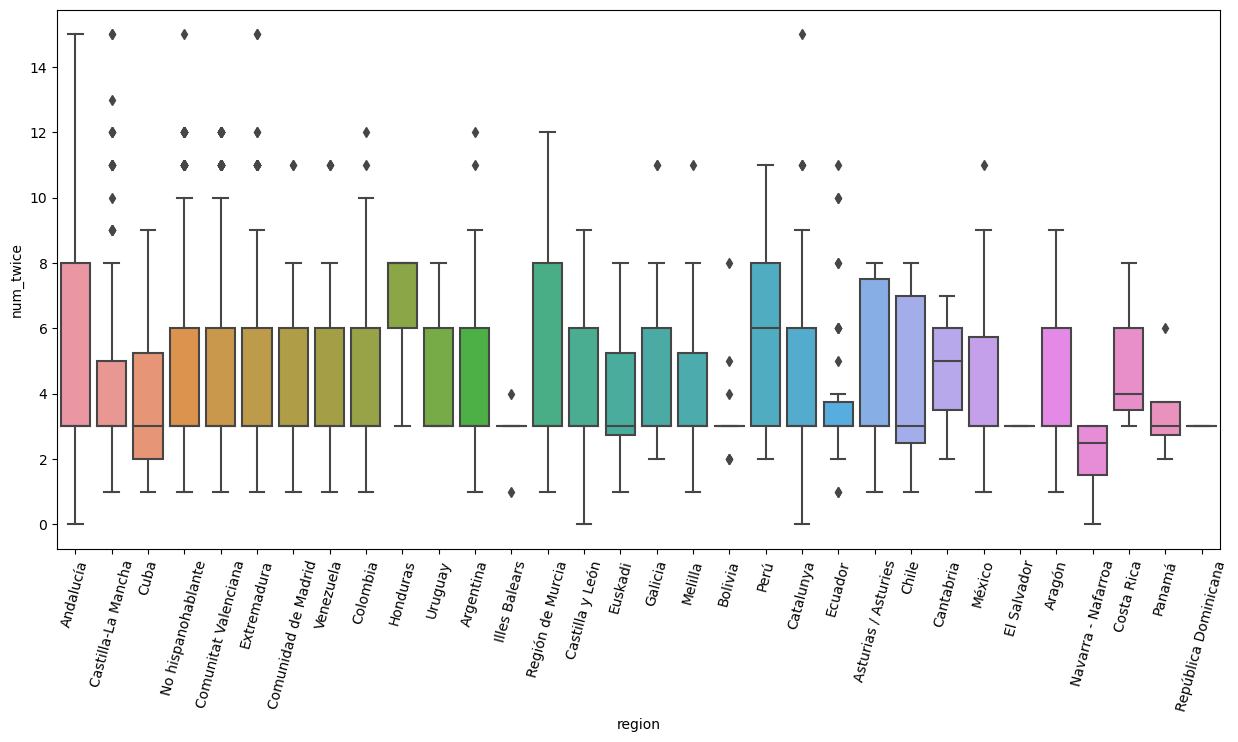

In [109]:
data = df_word.copy()
# remove outliers
#data = remove_outliers(data,column='num_twice',value=12)
# boxplot
box_plot('num_twice',data)
# statistics
statistics('num_twice',data)

### 6. Average word length

In [247]:
# Mann-Whitney U test
data = df_word.copy()
res = mann_whitney(data,'av_length')
print(res)

MannwhitneyuResult(statistic=1545840.5, pvalue=9.00942333321882e-06)


In [248]:
# Kruskal-Wallis test
kruskal_posthoc(df_word,'av_length')


AGE: KruskalResult(statistic=67.93259637781435, pvalue=6.198316988393319e-14)
AGE:               18-24         25-34     35-44         45-54       +55
18-24  1.000000e+00  4.832767e-02  0.003636  9.190932e-08  0.011091
25-34  4.832767e-02  1.000000e+00  0.000001  4.293029e-12  0.000005
35-44  3.635540e-03  1.450634e-06  1.000000  1.465757e-01  0.616654
45-54  9.190932e-08  4.293029e-12  0.146576  1.000000e+00  0.048328
+55    1.109129e-02  5.057304e-06  0.616654  4.832767e-02  1.000000
REGION: KruskalResult(statistic=92.94608540348848, pvalue=2.2648451540478864e-10)
REGION:                          Comunidad de Madrid  Andalucía  Extremadura  \
Comunidad de Madrid                 1.000000   1.000000      1.00000   
Andalucía                           1.000000   1.000000      1.00000   
Extremadura                         1.000000   1.000000      1.00000   
Castilla y León                     1.000000   1.000000      1.00000   
Comunidad Valenciana                0.002012   0.000041    

/var/folders/_x/cddkf2k97y19q18kzrrrxrzw0000gn/T/ipykernel_36317/2864299129.py:42: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  posthoc.set_axis(['18-24','25-34','35-44','45-54','+55'],axis=0,inplace=True)
/var/folders/_x/cddkf2k97y19q18kzrrrxrzw0000gn/T/ipykernel_36317/2864299129.py:43: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  posthoc.set_axis(['18-24','25-34','35-44','45-54','+55'],axis=1,inplace=True)
/var/folders/_x/cddkf2k97y19q18kzrrrxrzw0000gn/T/ipykernel_36317/2864299129.py:80: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  posthoc.set_axis(['Comunidad de Madrid','Andalucía','Extremadura','Castilla y León','Comunidad Valenciana','Galicia','

The d of Cohen for gender is: -0.14440798319603615
The f of Cohen for age is: 0.031515269048354645
The f of Cohen normalized for age is: 0.33612413574468175
The f of Cohen for demography is: 0.03773623615391757
The f of Cohen normalized for demography is: 0.06822513004879147


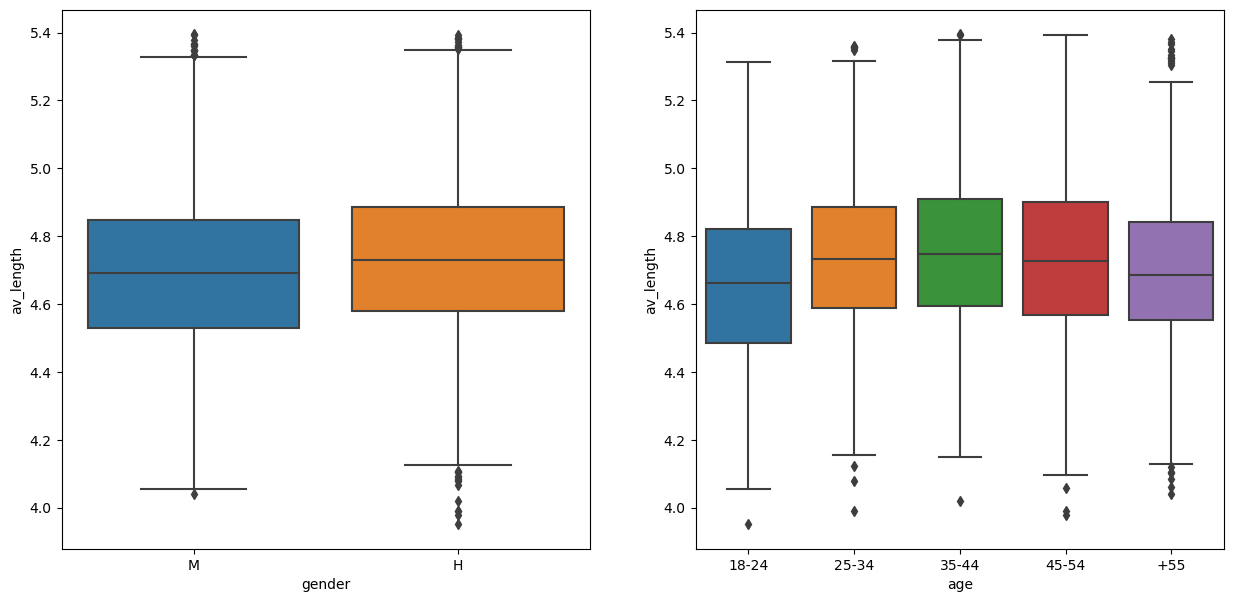

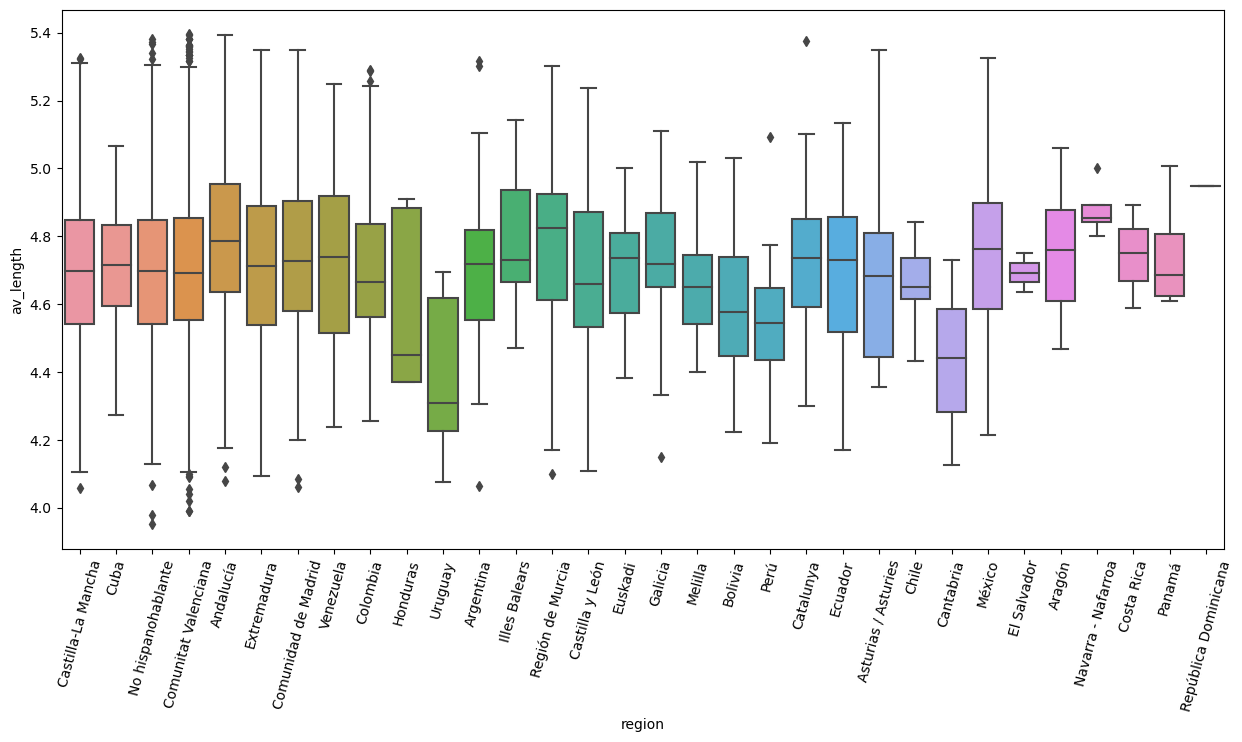

In [111]:
data = df_word.copy()
# remove outliers
data = remove_outliers(data,column='av_length',value=5.4)
# boxplot
box_plot('av_length',data)
# statistics
statistics('av_length',data)

### 7. Max word length

In [249]:
# Mann-Whitney U test
data = df_word.copy()
res = mann_whitney(data,'max_length')
print(res)

MannwhitneyuResult(statistic=1630588.5, pvalue=0.053934661590078266)


In [250]:
# Kruskal-Wallis test
kruskal_posthoc(df_word,'max_length')


AGE: KruskalResult(statistic=56.76492242430697, pvalue=1.385931878300859e-11)
AGE:           18-24         25-34     35-44         45-54       +55
18-24  1.000000  5.176381e-04  0.223886  2.530905e-04  0.223886
25-34  0.000518  1.000000e+00  0.000006  5.550663e-12  0.000002
35-44  0.223886  5.504024e-06  1.000000  1.705334e-01  0.997534
45-54  0.000253  5.550663e-12  0.170533  1.000000e+00  0.164185
+55    0.223886  2.012735e-06  0.997534  1.641852e-01  1.000000
REGION: KruskalResult(statistic=67.11467292176727, pvalue=3.363861783407407e-06)
REGION:                          Comunidad de Madrid  Andalucía  Extremadura  \
Comunidad de Madrid                 1.000000   1.000000     0.880453   
Andalucía                           1.000000   1.000000     0.357934   
Extremadura                         0.880453   0.357934     1.000000   
Castilla y León                     1.000000   1.000000     0.053503   
Comunidad Valenciana                1.000000   1.000000     0.470938   
Galicia     

/var/folders/_x/cddkf2k97y19q18kzrrrxrzw0000gn/T/ipykernel_36317/2864299129.py:42: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  posthoc.set_axis(['18-24','25-34','35-44','45-54','+55'],axis=0,inplace=True)
/var/folders/_x/cddkf2k97y19q18kzrrrxrzw0000gn/T/ipykernel_36317/2864299129.py:43: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  posthoc.set_axis(['18-24','25-34','35-44','45-54','+55'],axis=1,inplace=True)
/var/folders/_x/cddkf2k97y19q18kzrrrxrzw0000gn/T/ipykernel_36317/2864299129.py:80: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  posthoc.set_axis(['Comunidad de Madrid','Andalucía','Extremadura','Castilla y León','Comunidad Valenciana','Galicia','

The d of Cohen for gender is: -0.050631512872297293
The f of Cohen for age is: 0.17503744432245286
The f of Cohen normalized for age is: 0.3110251874367972
The f of Cohen for demography is: 0.2020628735782856
The f of Cohen normalized for demography is: 0.08840250719049991


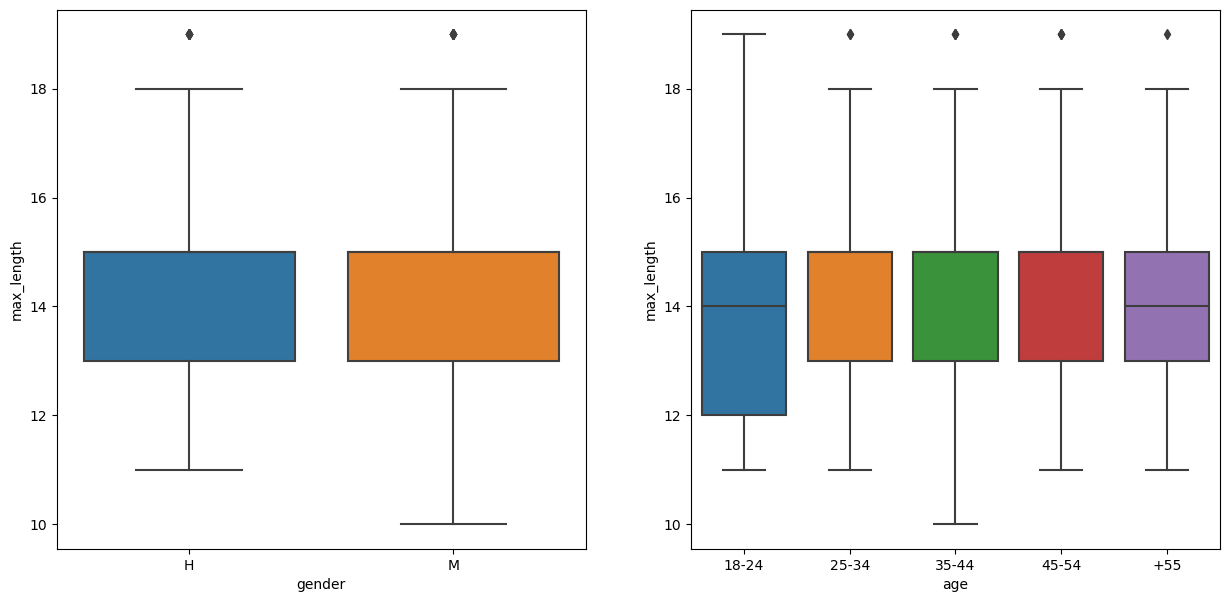

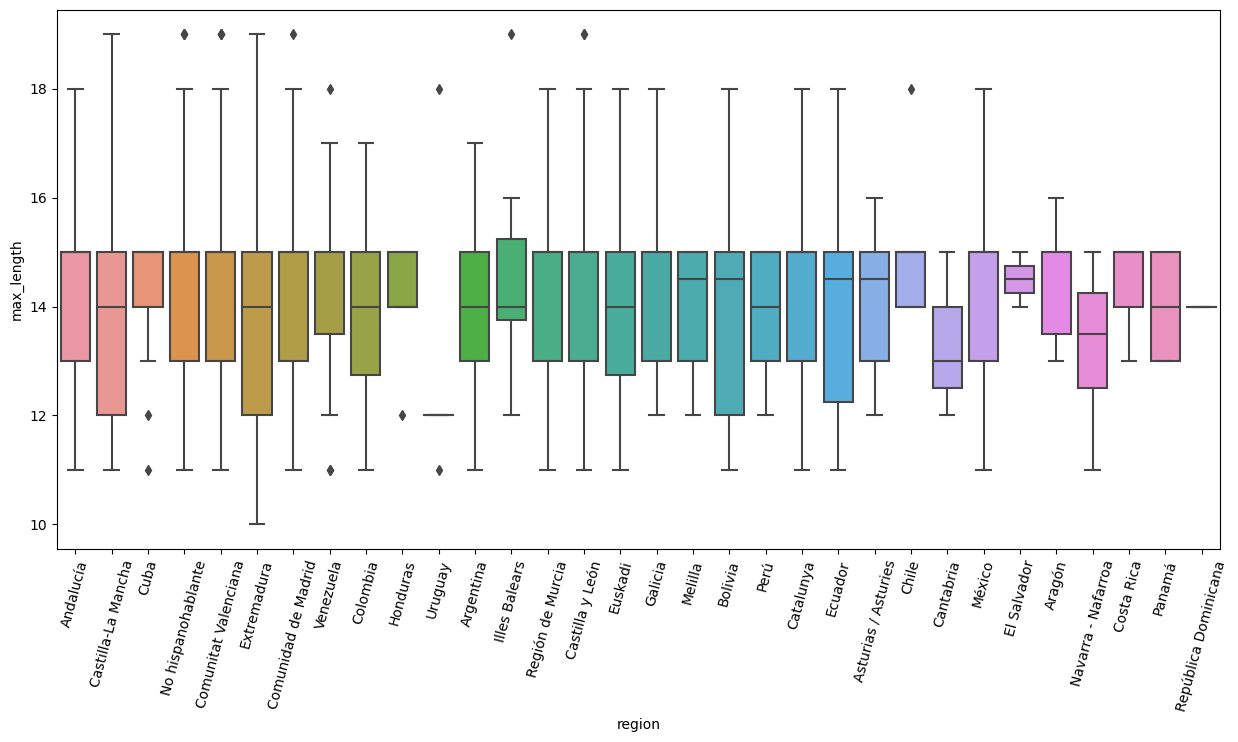

In [113]:
data = df_word.copy()
# remove outliers
data = remove_outliers(data,column='max_length',value=19)
# boxplot
box_plot('max_length',data)
# statistics
statistics('max_length',data)

### 8. Count of words with numbers

In [251]:
# Mann-Whitney U test
data = df_word.copy()
res = mann_whitney(data,'num_numbers')
print(res)

MannwhitneyuResult(statistic=1457985.5, pvalue=2.9500258376633854e-13)


In [252]:
# Kruskal-Wallis test
kruskal_posthoc(df_word,'num_numbers')


AGE: KruskalResult(statistic=30.831872322793604, pvalue=3.3129100646234113e-06)
AGE:           18-24     25-34     35-44     45-54       +55
18-24  1.000000  0.000001  0.408213  0.408213  1.000000
25-34  0.000001  1.000000  0.011727  0.004702  0.000070
35-44  0.408213  0.011727  1.000000  1.000000  0.895866
45-54  0.408213  0.004702  1.000000  1.000000  0.895866
+55    1.000000  0.000070  0.895866  0.895866  1.000000
REGION: KruskalResult(statistic=140.29341894908532, pvalue=8.173541602782641e-19)
REGION:                          Comunidad de Madrid     Andalucía  Extremadura  \
Comunidad de Madrid                 1.000000  3.057499e-02     1.000000   
Andalucía                           0.030575  1.000000e+00     0.000271   
Extremadura                         1.000000  2.713665e-04     1.000000   
Castilla y León                     1.000000  2.548630e-01     1.000000   
Comunidad Valenciana                1.000000  9.831755e-18     1.000000   
Galicia                             1.0

/var/folders/_x/cddkf2k97y19q18kzrrrxrzw0000gn/T/ipykernel_36317/2864299129.py:42: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  posthoc.set_axis(['18-24','25-34','35-44','45-54','+55'],axis=0,inplace=True)
/var/folders/_x/cddkf2k97y19q18kzrrrxrzw0000gn/T/ipykernel_36317/2864299129.py:43: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  posthoc.set_axis(['18-24','25-34','35-44','45-54','+55'],axis=1,inplace=True)
/var/folders/_x/cddkf2k97y19q18kzrrrxrzw0000gn/T/ipykernel_36317/2864299129.py:80: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  posthoc.set_axis(['Comunidad de Madrid','Andalucía','Extremadura','Castilla y León','Comunidad Valenciana','Galicia','

The d of Cohen for gender is: -0.20435783058637194
The f of Cohen for age is: 0.17446717484583335
The f of Cohen normalized for age is: 0.3401878920208525
The f of Cohen for demography is: 0.3064739483885066
The f of Cohen normalized for demography is: 0.12258957935540264


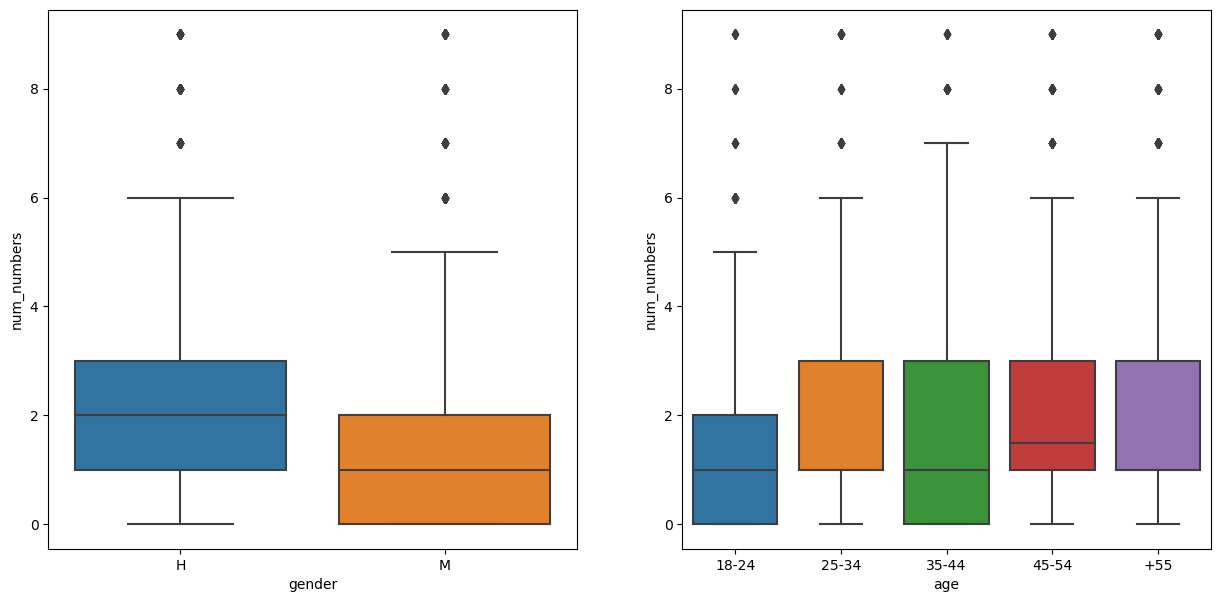

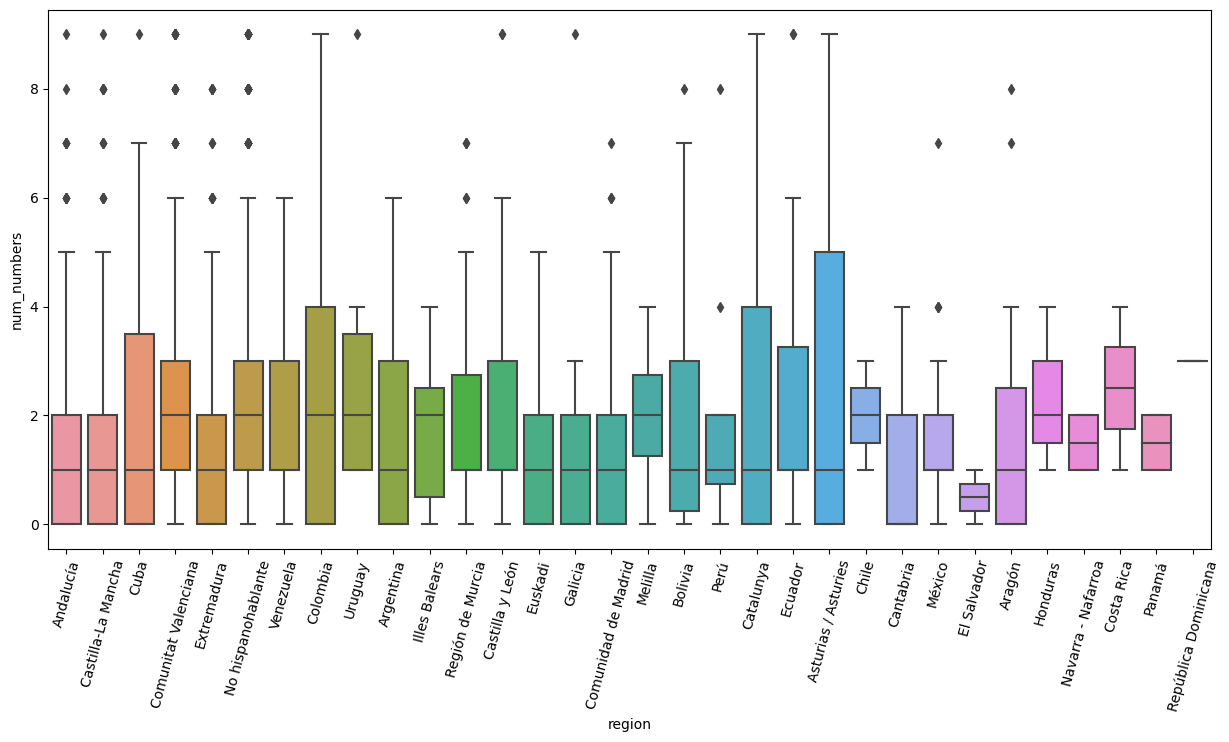

In [115]:
data = df_word.copy()
# remove outliers
data = remove_outliers(data,column='num_numbers',value=9)
# boxplot
box_plot('num_numbers',data)
# statistics
statistics('num_numbers',data)

### 9. Count of words with length greater than 6

In [253]:
# Mann-Whitney U test
data = df_word.copy()
res = mann_whitney(data,'num_greater')
print(res)

MannwhitneyuResult(statistic=1540433.5, pvalue=4.07577737677067e-06)


In [254]:
# Kruskal-Wallis test
kruskal_posthoc(df_word,'num_greater')


AGE: KruskalResult(statistic=44.45623273864216, pvalue=5.157814405790028e-09)
AGE:               18-24         25-34     35-44     45-54           +55
18-24  1.000000e+00  1.074632e-08  0.011416  0.070093  7.651782e-01
25-34  1.074632e-08  1.000000e+00  0.042381  0.001789  8.929192e-07
35-44  1.141636e-02  4.238087e-02  1.000000  0.765178  5.082953e-02
45-54  7.009332e-02  1.789459e-03  0.765178  1.000000  2.117195e-01
+55    7.651782e-01  8.929192e-07  0.050830  0.211719  1.000000e+00
REGION: KruskalResult(statistic=232.60797740669045, pvalue=1.3922927822426562e-36)
REGION:                          Comunidad de Madrid     Andalucía  Extremadura  \
Comunidad de Madrid                 1.000000  5.523251e-01     1.000000   
Andalucía                           0.552325  1.000000e+00     0.007041   
Extremadura                         1.000000  7.040594e-03     1.000000   
Castilla y León                     1.000000  5.656375e-02     1.000000   
Comunidad Valenciana                1.00000

/var/folders/_x/cddkf2k97y19q18kzrrrxrzw0000gn/T/ipykernel_36317/2864299129.py:42: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  posthoc.set_axis(['18-24','25-34','35-44','45-54','+55'],axis=0,inplace=True)
/var/folders/_x/cddkf2k97y19q18kzrrrxrzw0000gn/T/ipykernel_36317/2864299129.py:43: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  posthoc.set_axis(['18-24','25-34','35-44','45-54','+55'],axis=1,inplace=True)
/var/folders/_x/cddkf2k97y19q18kzrrrxrzw0000gn/T/ipykernel_36317/2864299129.py:80: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  posthoc.set_axis(['Comunidad de Madrid','Andalucía','Extremadura','Castilla y León','Comunidad Valenciana','Galicia','

The d of Cohen for gender is: -0.12173913631892182
The f of Cohen for age is: 2.3898040851950744
The f of Cohen normalized for age is: 0.3402189848877953
The f of Cohen for demography is: 4.707495473018897
The f of Cohen normalized for demography is: 0.09807282235456034


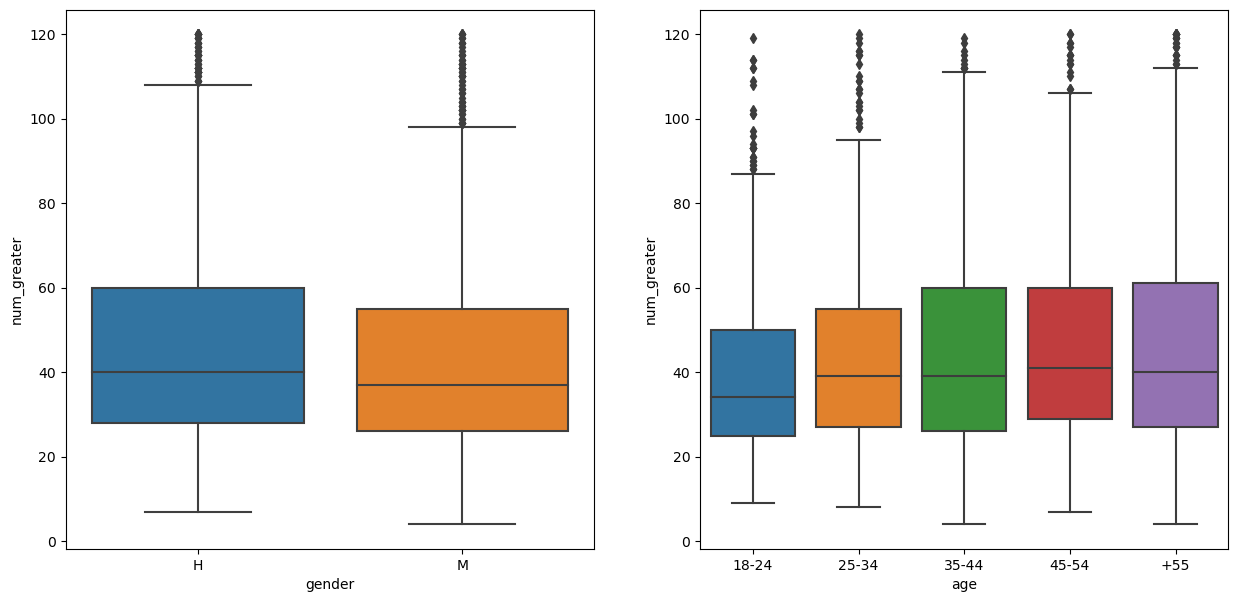

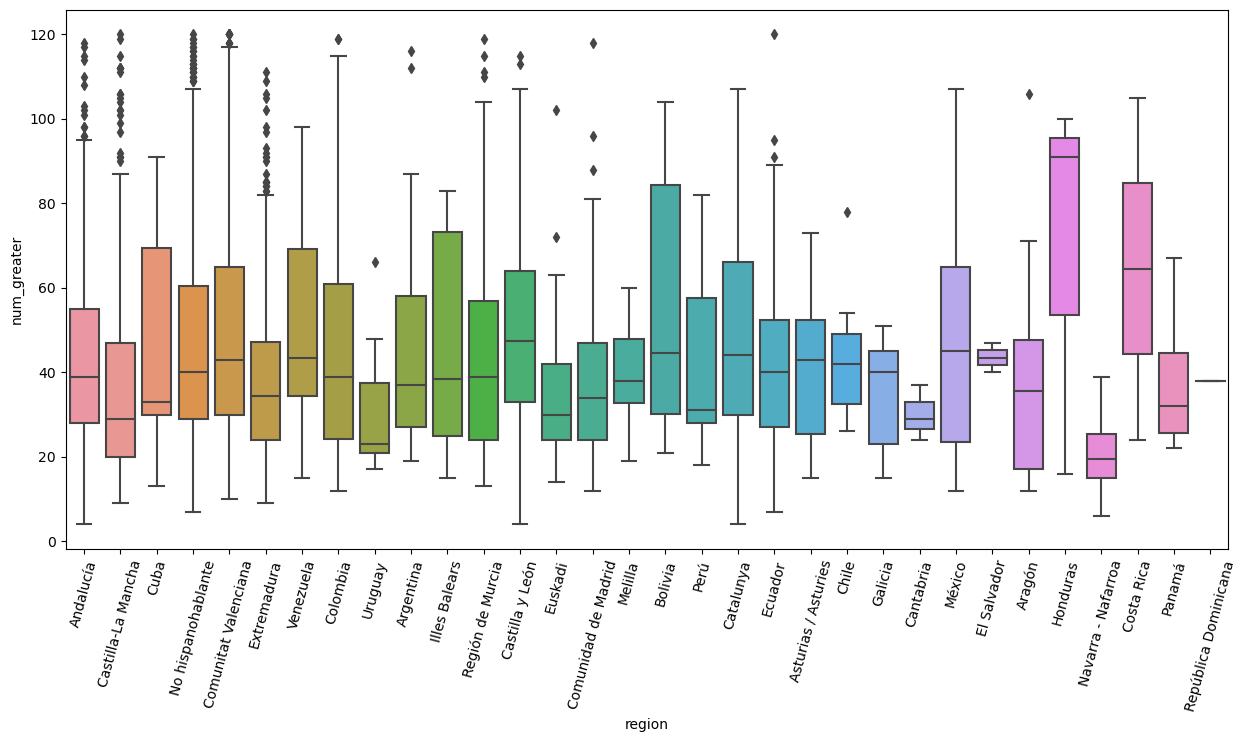

In [118]:
data = df_word.copy()
# remove outliers
data = remove_outliers(data,column='num_greater',value=120)
# boxplot
box_plot('num_greater',data)
# statistics
statistics('num_greater',data)

### 10. Count of words with length smaller than 3

In [255]:
# Mann-Whitney U test
data = df_word.copy()
res = mann_whitney(data,'num_smaller')
print(res)

MannwhitneyuResult(statistic=1595277.0, pvalue=0.0036160958970659876)


In [256]:
# Kruskal-Wallis test
kruskal_posthoc(df_word,'num_smaller')


AGE: KruskalResult(statistic=39.25473881871812, pvalue=6.171427303044728e-08)
AGE:               18-24         25-34     35-44     45-54       +55
18-24  1.000000e+00  3.976150e-07  0.000356  0.001452  0.320192
25-34  3.976150e-07  1.000000e+00  0.374146  0.253614  0.001452
35-44  3.557536e-04  3.741463e-01  1.000000  0.563854  0.099025
45-54  1.452074e-03  2.536137e-01  0.563854  1.000000  0.253614
+55    3.201920e-01  1.452074e-03  0.099025  0.253614  1.000000
REGION: KruskalResult(statistic=242.84336714652278, pvalue=1.3053710529335908e-38)
REGION:                          Comunidad de Madrid     Andalucía  Extremadura  \
Comunidad de Madrid                 1.000000  1.000000e+00     1.000000   
Andalucía                           1.000000  1.000000e+00     0.024440   
Extremadura                         1.000000  2.444003e-02     1.000000   
Castilla y León                     1.000000  1.513462e-01     1.000000   
Comunidad Valenciana                0.788183  9.518264e-13     1.00

/var/folders/_x/cddkf2k97y19q18kzrrrxrzw0000gn/T/ipykernel_36317/2864299129.py:42: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  posthoc.set_axis(['18-24','25-34','35-44','45-54','+55'],axis=0,inplace=True)
/var/folders/_x/cddkf2k97y19q18kzrrrxrzw0000gn/T/ipykernel_36317/2864299129.py:43: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  posthoc.set_axis(['18-24','25-34','35-44','45-54','+55'],axis=1,inplace=True)
/var/folders/_x/cddkf2k97y19q18kzrrrxrzw0000gn/T/ipykernel_36317/2864299129.py:80: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  posthoc.set_axis(['Comunidad de Madrid','Andalucía','Extremadura','Castilla y León','Comunidad Valenciana','Galicia','

The d of Cohen for gender is: -0.0816376470006434
The f of Cohen for age is: 2.6035158901910656
The f of Cohen normalized for age is: 0.33483427104202224
The f of Cohen for demography is: 5.779797770211416
The f of Cohen normalized for demography is: 0.10670395883467228


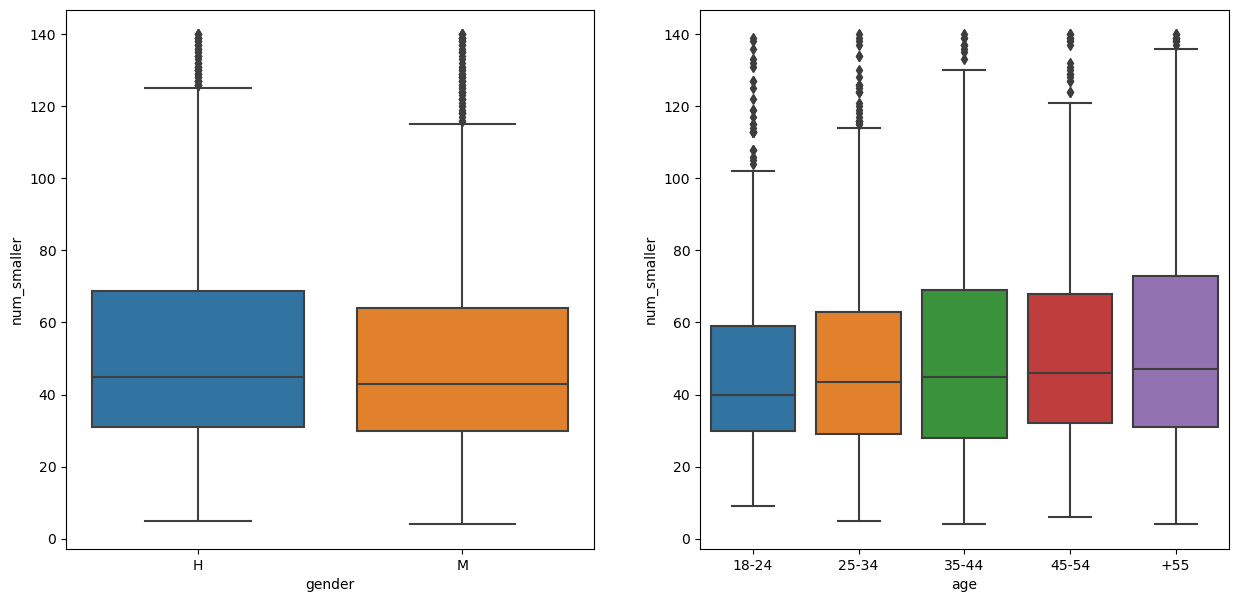

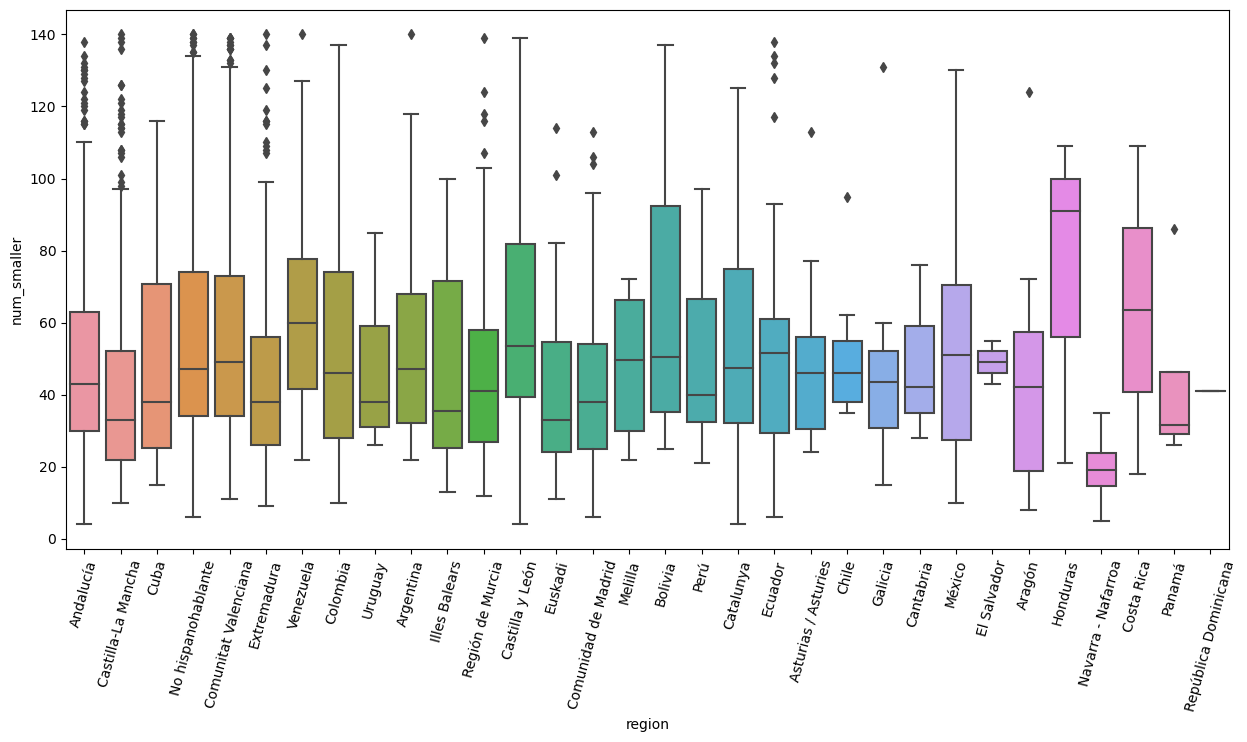

In [121]:
data = df_word.copy()
# remove outliers
data = remove_outliers(data,column='num_smaller',value=140)
# boxplot
box_plot('num_smaller',data)
# statistics
statistics('num_smaller',data)

### 11. Count of stop words

In [257]:
# Mann-Whitney U test
data = df_word.copy()
res = mann_whitney(data,'num_stop')
print(res)

MannwhitneyuResult(statistic=1598871.5, pvalue=0.005123542689919485)


In [258]:
# Kruskal-Wallis test
kruskal_posthoc(df_word,'num_stop')


AGE: KruskalResult(statistic=26.683416792613887, pvalue=2.3034063102062356e-05)
AGE:           18-24     25-34    35-44     45-54       +55
18-24  1.000000  0.000134  0.00387  0.010387  0.725974
25-34  0.000134  1.000000  0.82755  0.725974  0.019381
35-44  0.003870  0.827550  1.00000  0.827550  0.173420
45-54  0.010387  0.725974  0.82755  1.000000  0.354310
+55    0.725974  0.019381  0.17342  0.354310  1.000000
REGION: KruskalResult(statistic=241.7246954662072, pvalue=2.1766181068983531e-38)
REGION:                          Comunidad de Madrid     Andalucía  Extremadura  \
Comunidad de Madrid                 1.000000  1.000000e+00     1.000000   
Andalucía                           1.000000  1.000000e+00     0.072784   
Extremadura                         1.000000  7.278440e-02     1.000000   
Castilla y León                     1.000000  1.564710e-01     1.000000   
Comunidad Valenciana                0.226368  9.041825e-14     1.000000   
Galicia                             1.000000 

/var/folders/_x/cddkf2k97y19q18kzrrrxrzw0000gn/T/ipykernel_36317/2864299129.py:42: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  posthoc.set_axis(['18-24','25-34','35-44','45-54','+55'],axis=0,inplace=True)
/var/folders/_x/cddkf2k97y19q18kzrrrxrzw0000gn/T/ipykernel_36317/2864299129.py:43: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  posthoc.set_axis(['18-24','25-34','35-44','45-54','+55'],axis=1,inplace=True)
/var/folders/_x/cddkf2k97y19q18kzrrrxrzw0000gn/T/ipykernel_36317/2864299129.py:80: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  posthoc.set_axis(['Comunidad de Madrid','Andalucía','Extremadura','Castilla y León','Comunidad Valenciana','Galicia','

The d of Cohen for gender is: -0.0867326535611534
The f of Cohen for age is: 1.2017310232578815
The f of Cohen normalized for age is: 0.38295682822290306
The f of Cohen for demography is: 3.074225286157103
The f of Cohen normalized for demography is: 0.15017150734891643


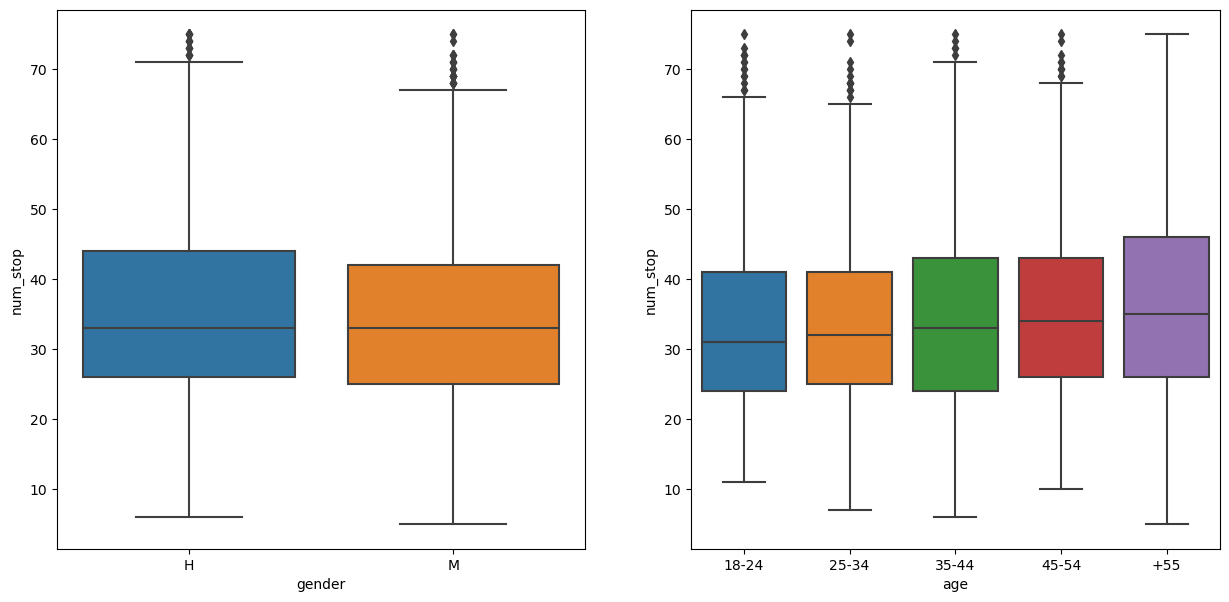

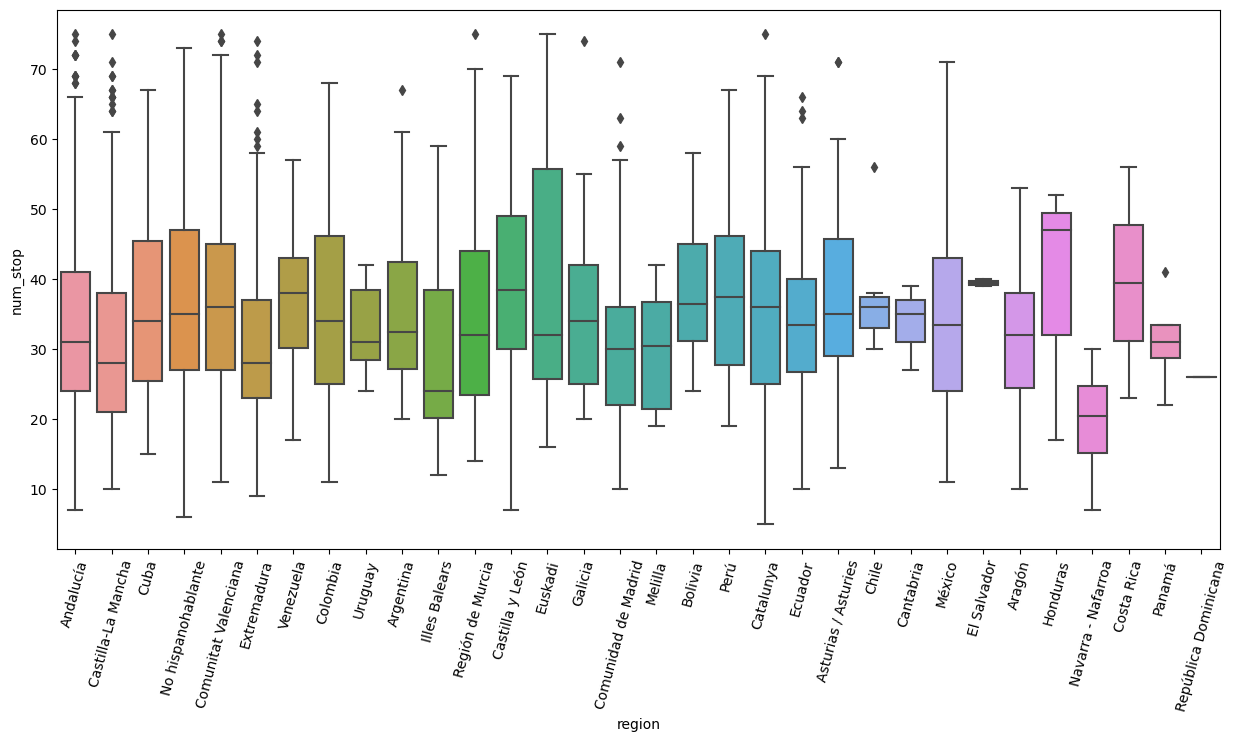

In [123]:
data = df_word.copy()
# remove outliers
data = remove_outliers(data,column='num_stop',value=75)
# boxplot
box_plot('num_stop',data)
# statistics
statistics('num_stop',data)

### 12. Count of location words

In [259]:
# Mann-Whitney U test
data = df_word.copy()
res = mann_whitney(data,'num_locations')
print(res)

MannwhitneyuResult(statistic=1647064.5, pvalue=0.15921005355874684)


In [260]:
# Kruskal-Wallis test
kruskal_posthoc(df_word,'num_locations')


AGE: KruskalResult(statistic=4.193001501104585, pvalue=0.38051561410413165)
AGE:           18-24     25-34  35-44     45-54  +55
18-24  1.000000  1.000000    1.0  0.598175  1.0
25-34  1.000000  1.000000    1.0  0.964194  1.0
35-44  1.000000  1.000000    1.0  1.000000  1.0
45-54  0.598175  0.964194    1.0  1.000000  1.0
+55    1.000000  1.000000    1.0  1.000000  1.0
REGION: KruskalResult(statistic=93.5908094573393, pvalue=1.7609372867721452e-10)
REGION:                          Comunidad de Madrid     Andalucía  Extremadura  \
Comunidad de Madrid                 1.000000  4.445418e-01          1.0   
Andalucía                           0.444542  1.000000e+00          1.0   
Extremadura                         1.000000  1.000000e+00          1.0   
Castilla y León                     1.000000  1.000000e+00          1.0   
Comunidad Valenciana                1.000000  3.950087e-09          1.0   
Galicia                             1.000000  1.000000e+00          1.0   
Cataluña         

/var/folders/_x/cddkf2k97y19q18kzrrrxrzw0000gn/T/ipykernel_36317/2864299129.py:42: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  posthoc.set_axis(['18-24','25-34','35-44','45-54','+55'],axis=0,inplace=True)
/var/folders/_x/cddkf2k97y19q18kzrrrxrzw0000gn/T/ipykernel_36317/2864299129.py:43: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  posthoc.set_axis(['18-24','25-34','35-44','45-54','+55'],axis=1,inplace=True)
/var/folders/_x/cddkf2k97y19q18kzrrrxrzw0000gn/T/ipykernel_36317/2864299129.py:80: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  posthoc.set_axis(['Comunidad de Madrid','Andalucía','Extremadura','Castilla y León','Comunidad Valenciana','Galicia','

The d of Cohen for gender is: -0.023278847602625264
The f of Cohen for age is: 0.034551809177199
The f of Cohen normalized for age is: 0.35848054918339617
The f of Cohen for demography is: 0.16818630932368522
The f of Cohen normalized for demography is: 0.07207984685300795


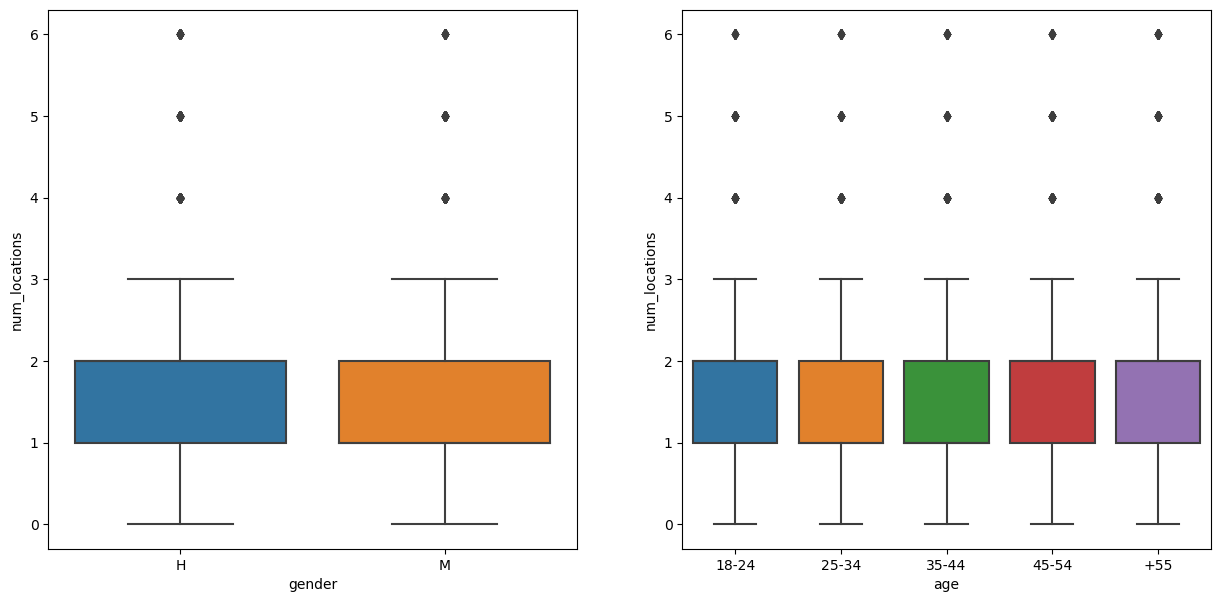

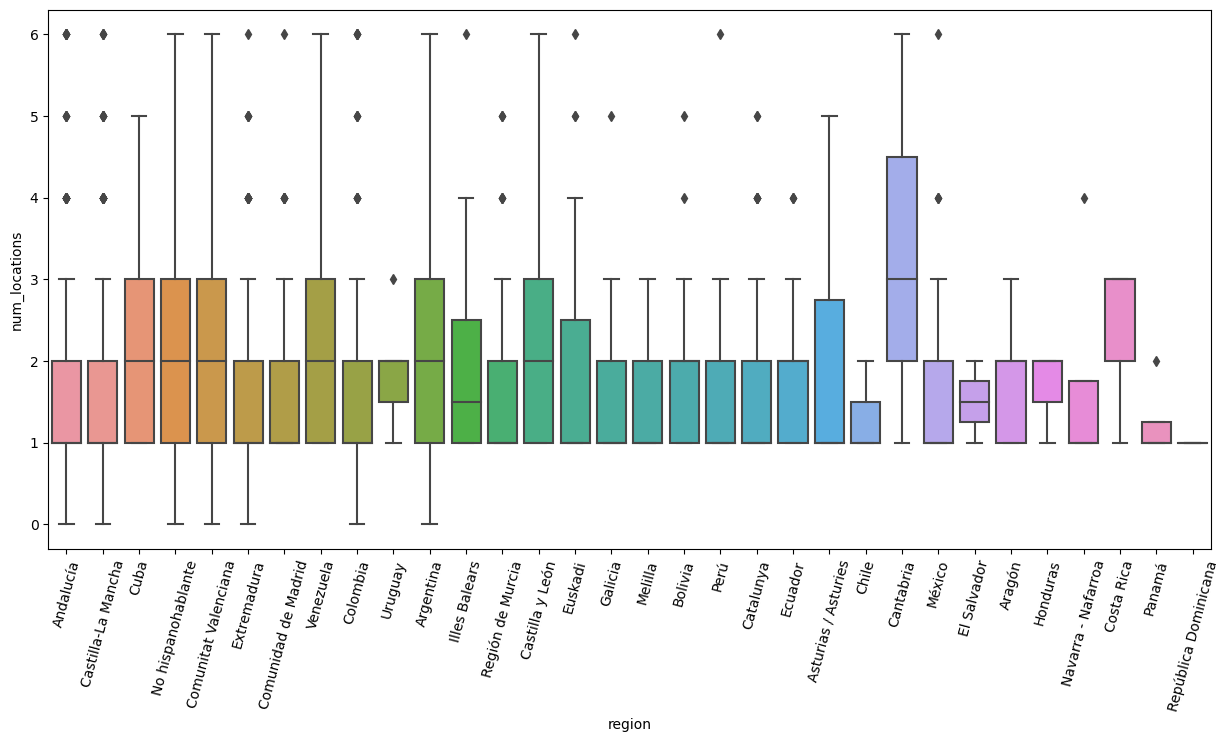

In [125]:
data = df_word.copy()
# remove outliers
data = remove_outliers(data,column='num_locations',value=6)
# boxplot
box_plot('num_locations',data)
# statistics
statistics('num_locations',data)

### 13. Count of telefone numbers

In [261]:
# Mann-Whitney U test
data = df_word.copy()
res = mann_whitney(data,'num_telefono')
print(res)

MannwhitneyuResult(statistic=1635705.5, pvalue=0.028658297625919663)


In [262]:
# Kruskal-Wallis test
kruskal_posthoc(df_word,'num_telefono')


AGE: KruskalResult(statistic=10.80512661859381, pvalue=0.02884366535063524)
AGE:           18-24     25-34     35-44     45-54       +55
18-24  1.000000  1.000000  1.000000  1.000000  0.019775
25-34  1.000000  1.000000  1.000000  1.000000  0.254682
35-44  1.000000  1.000000  1.000000  1.000000  0.157012
45-54  1.000000  1.000000  1.000000  1.000000  0.157012
+55    0.019775  0.254682  0.157012  0.157012  1.000000
REGION: KruskalResult(statistic=102.97082233809955, pvalue=4.303551815813205e-12)
REGION:                          Comunidad de Madrid     Andalucía  Extremadura  \
Comunidad de Madrid                      1.0  1.000000e+00     1.000000   
Andalucía                                1.0  1.000000e+00     0.098307   
Extremadura                              1.0  9.830690e-02     1.000000   
Castilla y León                          1.0  1.064011e-01     1.000000   
Comunidad Valenciana                     1.0  1.174043e-10     1.000000   
Galicia                                  1.

/var/folders/_x/cddkf2k97y19q18kzrrrxrzw0000gn/T/ipykernel_36317/2864299129.py:42: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  posthoc.set_axis(['18-24','25-34','35-44','45-54','+55'],axis=0,inplace=True)
/var/folders/_x/cddkf2k97y19q18kzrrrxrzw0000gn/T/ipykernel_36317/2864299129.py:43: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  posthoc.set_axis(['18-24','25-34','35-44','45-54','+55'],axis=1,inplace=True)
/var/folders/_x/cddkf2k97y19q18kzrrrxrzw0000gn/T/ipykernel_36317/2864299129.py:80: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  posthoc.set_axis(['Comunidad de Madrid','Andalucía','Extremadura','Castilla y León','Comunidad Valenciana','Galicia','

The d of Cohen for gender is: -0.05197185207818822
The f of Cohen for age is: 0.026236323455927166
The f of Cohen normalized for age is: 0.36274543085674527
The f of Cohen for demography is: 0.08424853043009199
The f of Cohen normalized for demography is: 0.08424853043009199


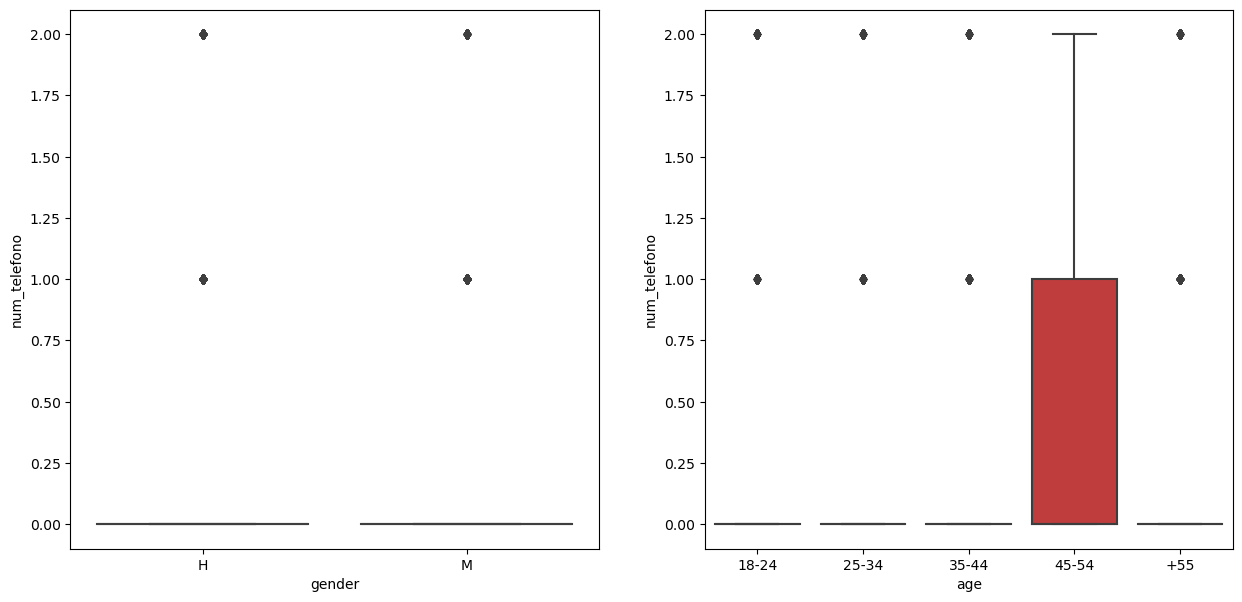

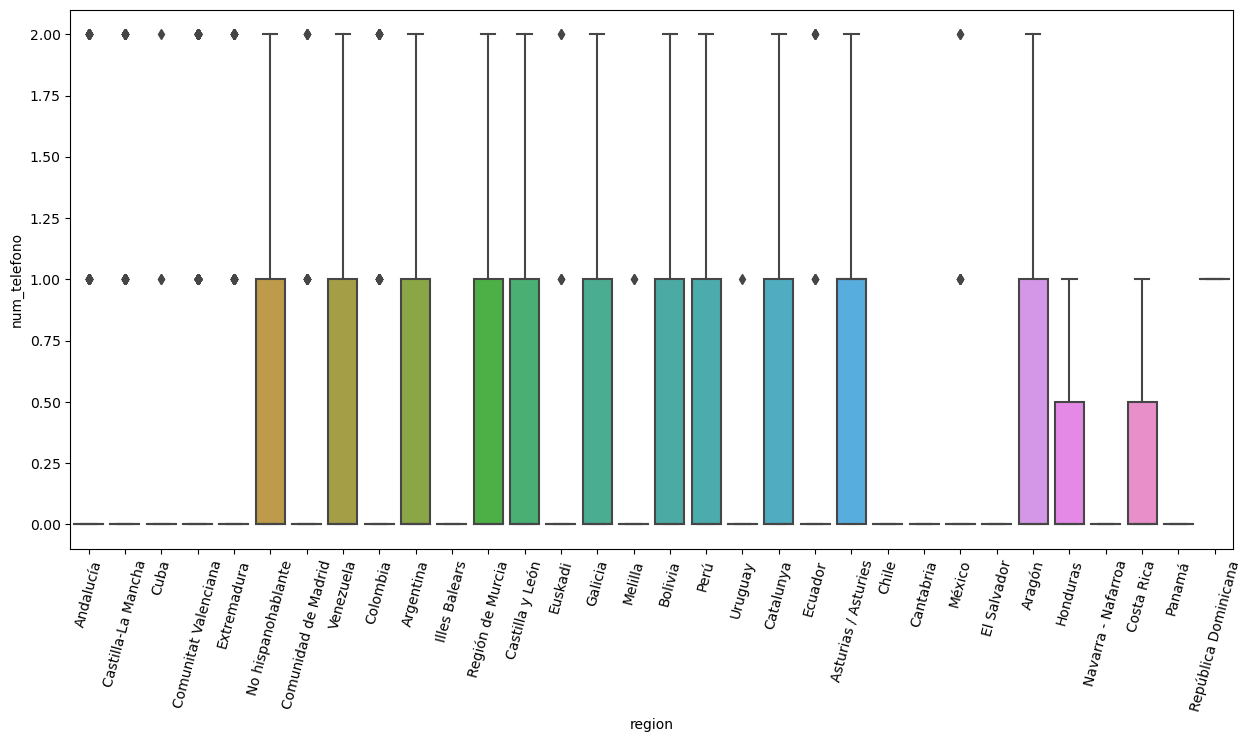

In [127]:
data = df_word.copy()
# remove outliers
data = remove_outliers(data,column='num_telefono',value=2)
# boxplot
box_plot('num_telefono',data)
# statistics
statistics('num_telefono',data)

### 14. Count of mentions to people

In [263]:
# Mann-Whitney U test
data = df_word.copy()
res = mann_whitney(data,'num_personas')
print(res)

MannwhitneyuResult(statistic=1626785.0, pvalue=0.014110283889429337)


In [264]:
# Kruskal-Wallis test
kruskal_posthoc(df_word,'num_personas')


AGE: KruskalResult(statistic=25.530769963163255, pvalue=3.934160784980357e-05)
AGE:           18-24     25-34     35-44     45-54       +55
18-24  1.000000  1.000000  1.000000  0.267703  0.000223
25-34  1.000000  1.000000  1.000000  0.267703  0.001066
35-44  1.000000  1.000000  1.000000  0.267703  0.001145
45-54  0.267703  0.267703  0.267703  1.000000  0.267703
+55    0.000223  0.001066  0.001145  0.267703  1.000000
REGION: KruskalResult(statistic=65.60532009303377, pvalue=5.6879463894962925e-06)
REGION:                          Comunidad de Madrid  Andalucía  Extremadura  \
Comunidad de Madrid                 1.000000        1.0     1.000000   
Andalucía                           1.000000        1.0     1.000000   
Extremadura                         1.000000        1.0     1.000000   
Castilla y León                     1.000000        1.0     1.000000   
Comunidad Valenciana                0.000698        1.0     0.019563   
Galicia                             1.000000        1.0   

/var/folders/_x/cddkf2k97y19q18kzrrrxrzw0000gn/T/ipykernel_36317/2864299129.py:42: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  posthoc.set_axis(['18-24','25-34','35-44','45-54','+55'],axis=0,inplace=True)
/var/folders/_x/cddkf2k97y19q18kzrrrxrzw0000gn/T/ipykernel_36317/2864299129.py:43: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  posthoc.set_axis(['18-24','25-34','35-44','45-54','+55'],axis=1,inplace=True)
/var/folders/_x/cddkf2k97y19q18kzrrrxrzw0000gn/T/ipykernel_36317/2864299129.py:80: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  posthoc.set_axis(['Comunidad de Madrid','Andalucía','Extremadura','Castilla y León','Comunidad Valenciana','Galicia','

The d of Cohen for gender is: -0.04575809007279803
The f of Cohen for age is: 0.04879935271571567
The f of Cohen normalized for age is: 0.37034009984819616
The f of Cohen for demography is: 0.08775567246183474
The f of Cohen normalized for demography is: 0.08775567246183474


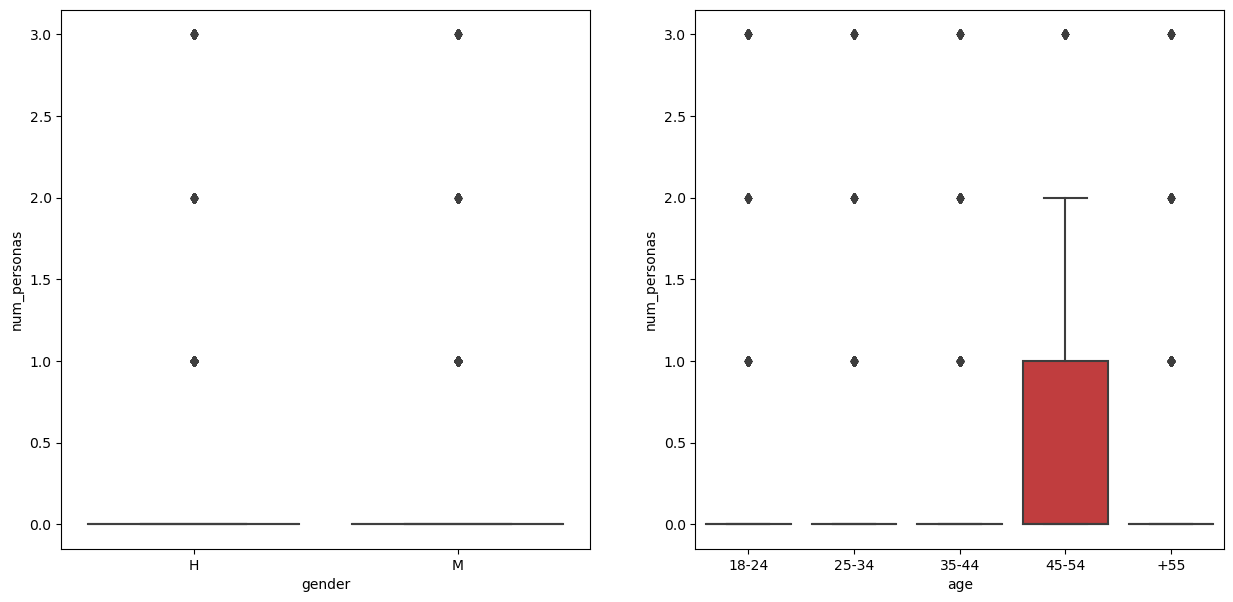

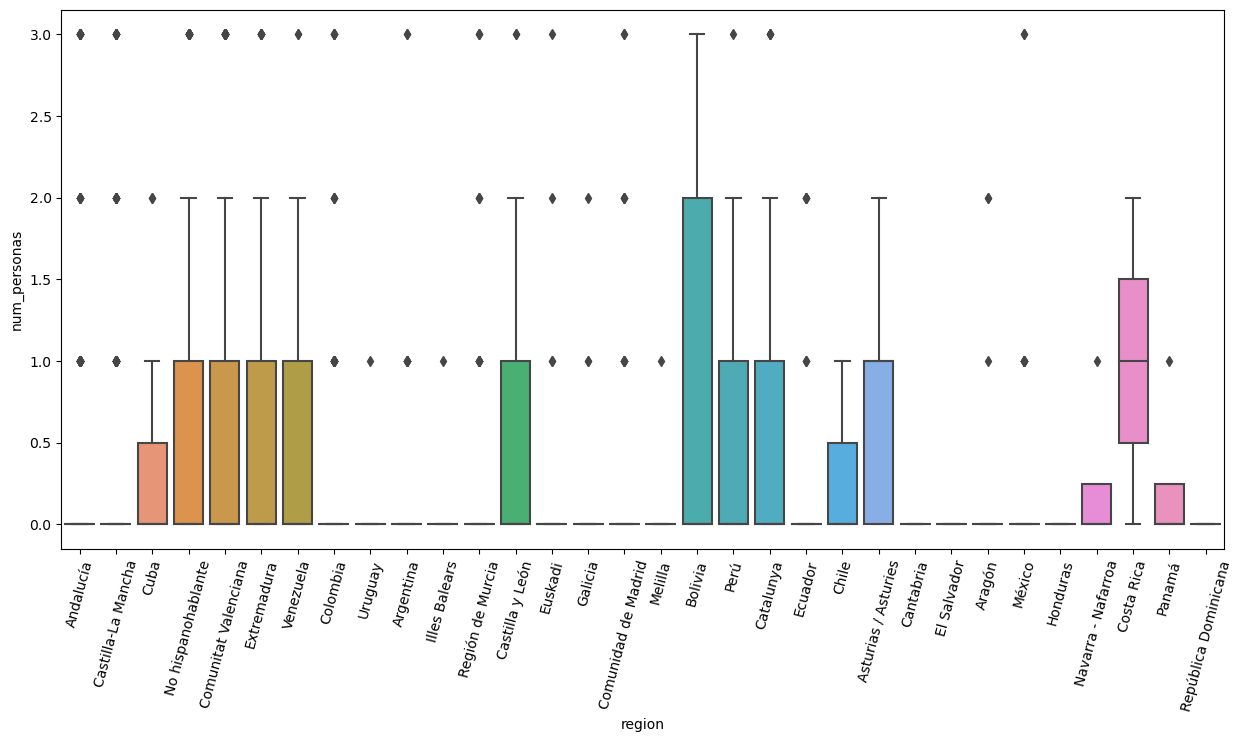

In [129]:
data = df_word.copy()
# remove outliers
data = remove_outliers(data,column='num_personas',value=3)
# boxplot
box_plot('num_personas',data)
# statistics
statistics('num_personas',data)

### 15. Count of timestamps

In [265]:
# Mann-Whitney U test
data = df_word.copy()
res = mann_whitney(data,'num_fechas')
print(res)

MannwhitneyuResult(statistic=1594136.5, pvalue=0.0021954969856442406)


In [266]:
# Kruskal-Wallis test
kruskal_posthoc(df_word,'num_fechas')


AGE: KruskalResult(statistic=8.938602314076194, pvalue=0.06265258684989805)
AGE:           18-24     25-34     35-44  45-54       +55
18-24  1.000000  0.813337  0.143759    1.0  0.143759
25-34  0.813337  1.000000  1.000000    1.0  1.000000
35-44  0.143759  1.000000  1.000000    1.0  1.000000
45-54  1.000000  1.000000  1.000000    1.0  1.000000
+55    0.143759  1.000000  1.000000    1.0  1.000000
REGION: KruskalResult(statistic=86.33687287715911, pvalue=2.903986709002202e-09)
REGION:                          Comunidad de Madrid     Andalucía  Extremadura  \
Comunidad de Madrid                 1.000000  1.807041e-01     1.000000   
Andalucía                           0.180704  1.000000e+00     0.896172   
Extremadura                         1.000000  8.961719e-01     1.000000   
Castilla y León                     1.000000  1.000000e+00     1.000000   
Comunidad Valenciana                1.000000  2.733824e-04     1.000000   
Galicia                             1.000000  1.000000e+00    

/var/folders/_x/cddkf2k97y19q18kzrrrxrzw0000gn/T/ipykernel_36317/2864299129.py:42: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  posthoc.set_axis(['18-24','25-34','35-44','45-54','+55'],axis=0,inplace=True)
/var/folders/_x/cddkf2k97y19q18kzrrrxrzw0000gn/T/ipykernel_36317/2864299129.py:43: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  posthoc.set_axis(['18-24','25-34','35-44','45-54','+55'],axis=1,inplace=True)
/var/folders/_x/cddkf2k97y19q18kzrrrxrzw0000gn/T/ipykernel_36317/2864299129.py:80: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  posthoc.set_axis(['Comunidad de Madrid','Andalucía','Extremadura','Castilla y León','Comunidad Valenciana','Galicia','

The d of Cohen for gender is: -0.07544891981478599
The f of Cohen for age is: 0.05003501841750761
The f of Cohen normalized for age is: 0.4087606589362486
The f of Cohen for demography is: 0.19942392110843113
The f of Cohen normalized for demography is: 0.06647464036947705


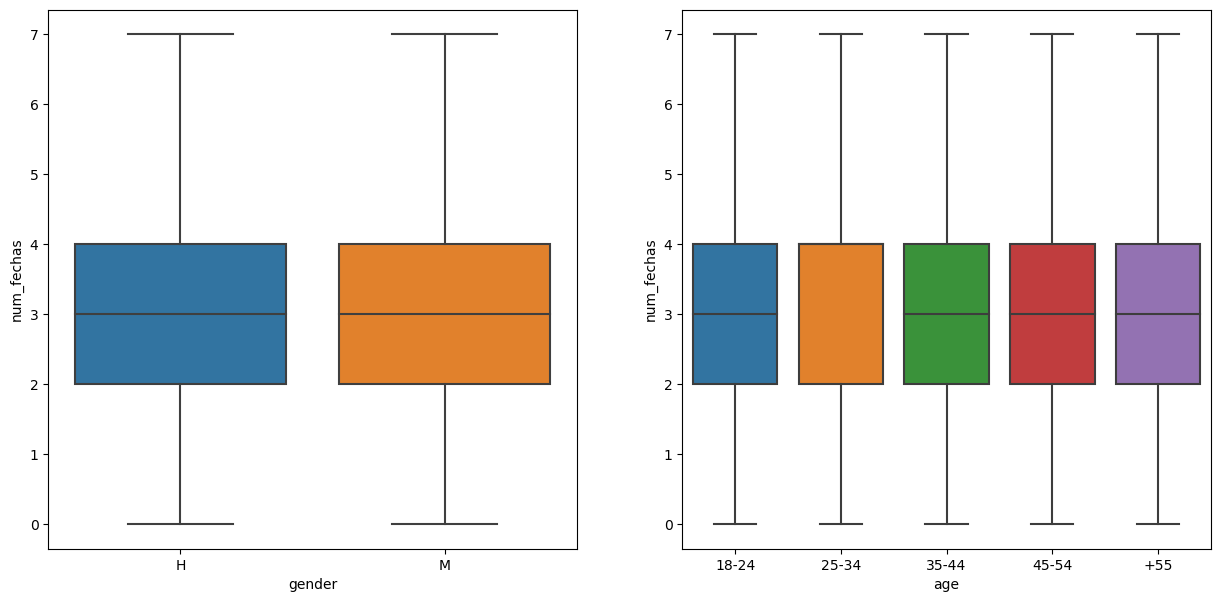

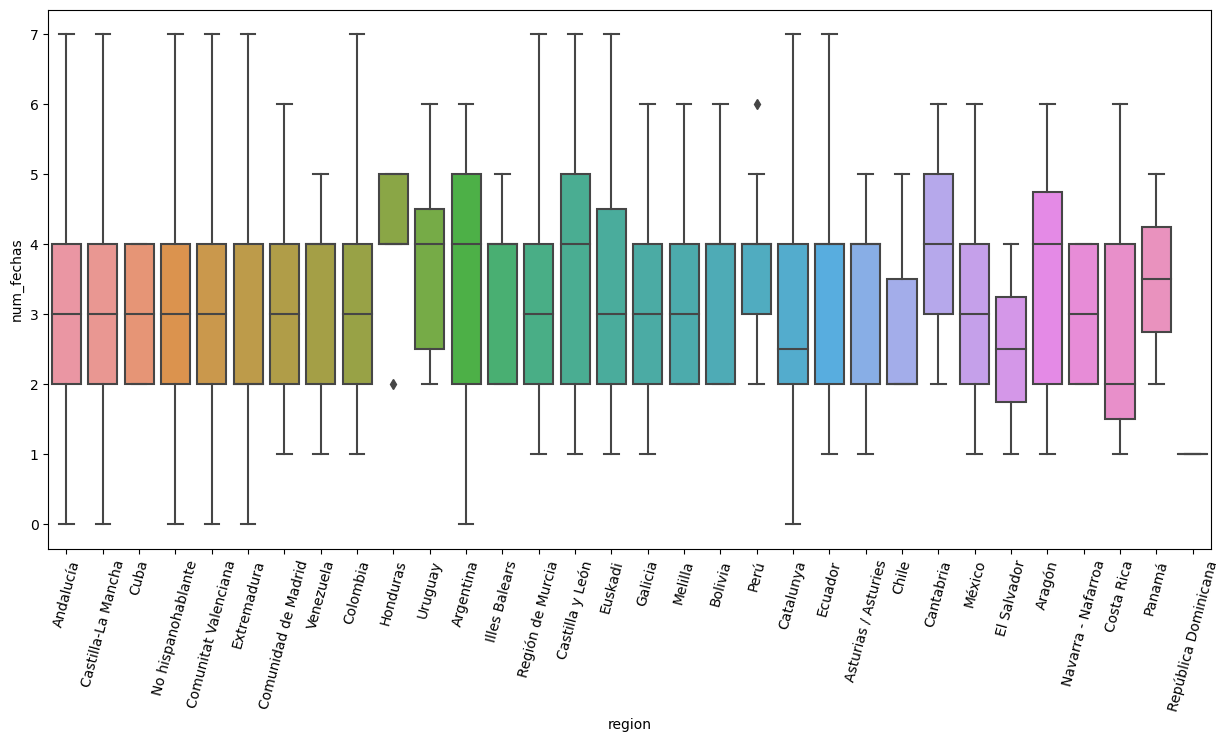

In [131]:
data = df_word.copy()
# remove outliers
data = remove_outliers(data,column='num_fechas',value=7)
# boxplot
box_plot('num_fechas',data)
# statistics
statistics('num_fechas',data)

## Conclusions
For the crime report dataset, with the police officer's demographic traits as targets, we can conclude that the statistical significant features are:

1. Gender:
    * Character based:
        - Number of characters
        - Number of capital letters
        - Number of punctuation marks
    * Structural based: 
        - Average number of sentences per paragraph
        - Number of sentences
    * Syntactic based:
        - Number of determiners
        - Number of prepositions
    * Word based:
        - Number of words
        - Average word length
        - Count of words with numbers
        - Length greater than 6
        - Count of timestamps
2. Age:
    * Character based:
        - Number of characters
        - Number of capital letters
        - Number of punctuation marks
    * Structural based:
        - Average number of sentences per paragraph
        - Average number of words per paragraph
        - Number of sentences
    * Syntactic based:
        - Number of determiners
        - Number of prepositions
        - Number of singular nouns
        - Number of plural nouns
        - Number of adjectives
        - Number of pronouns
        - Number of conjunctions
        - Number of adverbs
    * Word based:
        - Number of words
        - Unique word count
        - Count of words with numbers
        - Count of words with length > 6
        - Count of stop words
        - Count of locations
        - Count of timestamps
3. Region:
    * Character based: 
        - Number of characters
        - Number of capital letters
        - Number of punctuation marks
    * Structural based: 
        - Average number of sentences per paragraph
        - Variation
        - Number of sentences
    * Stylistic based:
        - Number of determiners
        - Number of pronouns
        - Number of adverbs
        - Number of adjectives
        - Number of conjunctions
    * Word based:
        - Number of words
        - Number of negative words
        - Count of words with numbers
        - Lenght > 6
        - Length < 3
        - Count of stop words
        - Count of timestamps